# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
import datetime

from tqdm import tqdm
from fbprophet import Prophet

In [2]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df['total_count'] = df['# Vehicles - E-ZPass'] + df['# Vehicles - VToll']
    
    sub_df = df[['Date_Hour', 'plaza_id', 'total_count']]
    sub_df.columns = ['datetime', 'plaza_id', 'total_count']
    sub_df.set_index('datetime', inplace=True)
    sub_df = sub_df.groupby('plaza_id')['total_count'].resample('1D').sum()
    
    return sub_df


In [3]:
df = return_series('mta.csv')

In [4]:
_df = df.unstack().T

In [5]:
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

In [6]:
import holidays
holidays_2018_2020 = []
for year in [2018, 2019, 2020]:
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])

In [7]:

def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter


    conditions = [
        (_df.index >= '2020-03-21') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df

In [8]:
_df = date_features(_df)
print(_df.shape)
_df.head()

(986, 18)


plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
datetime,,,,,,,,,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,140775,81923,109286,1,0,2018,1,1,1,-1,0,1
2018-01-02,47160,21875,60610,19887,67000,106264,164930,95649,117211,1,1,2018,1,2,1,-1,0,0
2018-01-03,54005,24607,67983,22067,71725,115952,175150,103506,123974,1,2,2018,1,3,1,-1,0,0
2018-01-04,20484,8303,14502,6167,26625,28406,64137,37820,38114,1,3,2018,1,4,1,-1,0,0
2018-01-05,38007,16839,49850,13929,55153,80477,135253,74375,91229,1,4,2018,1,5,1,-1,0,0


In [9]:
ohe = OneHotEncoder(drop='first')
categorical_columns = ['month', 'dayofweek', 'quarter', 'Phase']
_df_ohe = ohe.fit_transform(_df[categorical_columns]).toarray()
_df_ohe_df = pd.DataFrame(data = _df_ohe,
                           index = _df.index,
                          columns = ohe.get_feature_names(categorical_columns))

_df_merged = _df.merge(_df_ohe_df, left_index=True, right_index=True)
_df_ohe_df['weekend'] = _df['weekend']
_df_ohe_df['holiday'] = _df['holiday']
_df_ohe_df.head()

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,...,quarter_2,quarter_3,quarter_4,Phase_0,Phase_1,Phase_2,Phase_3,Phase_4,weekend,holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2018-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2018-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2018-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2018-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [10]:
tr_start,tr_end = '2018-01-01','2020-08-22'
te_start,te_end = '2020-08-23','2020-09-12'
tra = _df_merged[tr_start:tr_end]['Brooklyn Battery']
tes = _df_merged[te_start:te_end]['Brooklyn Battery']
exog_train = _df_ohe_df[tr_start:tr_end]
exog_test = _df_ohe_df[te_start:te_end]

In [65]:
stepwise_fit = auto_arima(_df_merged['Throgs Neck'], start_p=0, start_q=0, 
                          exogenous = _df_ohe_df, 
                          information_criterion='oob',
                         max_p=3, max_q=3, max_d = 2, m=7, out_of_sample_size=21,
                         seasonal=True,
                         d=None, trace=True,
                         error_action='ignore',   
                         suppress_warnings=True,  
                         stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize oob
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=22614.068, BIC=22765.771, Time=3.614 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=22990.138, BIC=23132.054, Time=0.465 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 7) (constant=True); AIC=22448.408, BIC=22600.111, Time=2.923 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 7) (constant=True); AIC=22654.751, BIC=22806.455, Time=3.906 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 7) (constant=False); AIC=28838.807, BIC=28975.829, Time=0.438 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 7) (constant=True); AIC=22794.133, BIC=22940.942, Time=1.116 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 0, 7) (constant=True); AIC=22385.870, BIC=22542.467, Time=13.282 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 1, 7) (constant=True); AIC=22386.588, BIC=22548.078, Time=13.440 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 7) (constant=True); AIC=22406.499, BIC=22563.096, Time=3.941 seconds
Fit ARIMA: (0, 0, 0)x(2, 0, 0, 7) (constant=True); AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  986
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 7)   Log Likelihood              -11123.287
Date:                           Mon, 21 Sep 2020   AIC                          22314.574
Time:                                   00:51:43   BIC                          22480.959
Sample:                                        0   HQIC                         22377.855
                                           - 986                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2048.3636   1874.478      1.093      0.274   -1625.546    5722.273
x1          6.738e+04   5379.493     12.526      0.000    5.68e+04    7.79e+04
x2          6.966e+04   1.24e+04      5.633      0.000    4.54e+04    9.39e+04
x3          1.309e+04   1.05e+04      1.245      0.213   -7519.187    3.37e+04
x4          2.602e+04   6556.885      3.968      0.000    1.32e+04    3.89e+04
x5          2.525e+04   1.14e+04      2.210      0.027    2860.254    4.76e+04
x6          2.166e+04   1.21e+04      1.785      0.074   -2128.330    4.54e+04
x7          2.323e+04   1.19e+04      1.959      0.050      -7.008    4.65e+04
x8          1.873e+04   1.33e+04      1.409      0.159   -7326.266    4.48e+04
x9           2.23e+04   1.87e+04      1.194      0.232   -1.43e+04    5.89e+04
x10         1.791e+04   1.59e+04      1.125      0.260   -1.33e+04    4.91e+04
x11         1.668e+04   1.22e+04      1.366      0.172   -7260.143    4.06e+04
x12         4.554e+04   1.38e+04      3.312      0.001    1.86e+04    7.25e+04
x13         4.676e+04   1.41e+04      3.314      0.001    1.91e+04    7.44e+04
x14         5.139e+04   1.22e+04      4.219      0.000    2.75e+04    7.53e+04
x15         5.332e+04   1.61e+04      3.315      0.001    2.18e+04    8.48e+04
x16          1.79e+04   9430.227      1.898      0.058    -583.477    3.64e+04
x17         1.603e+04   7109.924      2.254      0.024    2090.049       3e+04
x18         6.437e+04   1.41e+04      4.567      0.000    3.67e+04     9.2e+04
x19         6.361e+04    1.6e+04      3.967      0.000    3.22e+04     9.5e+04
x20         5.688e+04   1.14e+04      4.998      0.000    3.46e+04    7.92e+04
x21        -6.318e+04   1.54e+04     -4.115      0.000   -9.33e+04   -3.31e+04
x22        -3.351e+04   2.85e+04     -1.176      0.239   -8.93e+04    2.23e+04
x23        -3.257e+04   3.41e+04     -0.956      0.339   -9.94e+04    3.42e+04
x24        -2.275e+04   4.29e+04     -0.531      0.596   -1.07e+05    6.13e+04
x25        -2.337e+04   4.79e+04     -0.488      0.626   -1.17e+05    7.05e+04
x26         3.392e+04   7482.627      4.534      0.000    1.93e+04    4.86e+04
x27         3.532e+04   3859.322      9.151      0.000    2.78e+04    4.29e+04
ar.L1          0.3156      0.026     12.014      0.000       0.264       0.367
ar.L2          0.1814      0.034      5.356      0.000       0.115       0.248
ar.L3          0.0942      0.044      2.156      0.031       0.009       0.180
ar.S.L7        0.3553      0.028     12.858      0.000       0.301       0.409
ar.S.L14       0.3654      0.023     15.644      0.000       0.320       0.411
sigma2      5.574e+08      9.848   5.66e+07      0.000    5.57e+08    5.57e+08
===================================================================================
Ljung-Box (Q):                      140.01   Jarque-Bera (JB):            109191.28
Prob(Q):                              0.00   Prob(J

In [13]:
model_SARIMAX = SARIMAX(tra,order=(7,0,7), exog = exog_train,
                    freq='D', enforce_stationarity=False, enforce_invertibility=False)
results = model_SARIMAX.fit()

C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [14]:
results.summary()

C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning:

invalid value encountered in sqrt



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Brooklyn Battery   No. Observations:                  963
Model:               SARIMAX(7, 0, 7)   Log Likelihood               -9800.624
Date:                Sun, 20 Sep 2020   AIC                          19685.249
Time:                        22:31:03   BIC                          19889.441
Sample:                    01-01-2018   HQIC                         19763.029
                         - 08-20-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
month_2      3.362e+04   1597.869     21.043      0.000    3.05e+04    3.68e+04
month_3      3.234e+04   6098.025      5.303      0.000    2.04e+04    4.43e+04
month_4      6298.5118   4212.407      1.495      0.135   -1957.654    1.46e+04
month_5      1.084e+04   2608.347      4.158      0.000    5732.703     1.6e+04
month_6      1.123e+04   3948.768      2.845      0.004    3493.213     1.9e+04
month_7      7563.1615   4036.400      1.874      0.061    -348.037    1.55e+04
month_8      7948.3783   4310.921      1.844      0.065    -500.871    1.64e+04
month_9      1.072e+04   3323.794      3.225      0.001    4204.192    1.72e+04
month_10     9940.8326   6064.850      1.639      0.101   -1946.056    2.18e+04
month_11     8798.0616   5418.591      1.624      0.104   -1822.181    1.94e+04
month_12     8767.4374   3551.068      2.469      0.014    1807.471    1.57e+04
dayofweek_1  2.372e+04   4819.307      4.922      0.000    1.43e+04    3.32e+04
dayofweek_2  2.449e+04   7420.254      3.300      0.001    9943.524     3.9e+04
dayofweek_3  2.655e+04   6795.230      3.907      0.000    1.32e+04    3.99e+04
dayofweek_4  2.463e+04   6731.712      3.659      0.000    1.14e+04    3.78e+04
dayofweek_5  4931.9111   4810.342      1.025      0.305   -4496.185    1.44e+04
dayofweek_6  2871.9379   3649.528      0.787      0.431   -4281.005       1e+04
quarter_2    2.838e+04   3964.583      7.157      0.000    2.06e+04    3.61e+04
quarter_3    2.623e+04   4497.573      5.832      0.000    1.74e+04     3.5e+04
quarter_4    2.751e+04   3122.290      8.810      0.000    2.14e+04    3.36e+04
Phase_0     -3.499e+04   2362.770    -14.807      0.000   -3.96e+04   -3.04e+04
Phase_1     -1.954e+04   7990.123     -2.445      0.014   -3.52e+04   -3876.731
Phase_2     -1.514e+04   9629.798     -1.572      0.116    -3.4e+04    3731.901
Phase_3     -7202.5104   1.43e+04     -0.502      0.616   -3.53e+04    2.09e+04
Phase_4     -5093.3851   1.35e+04     -0.376      0.707   -3.16e+04    2.15e+04
weekend      7803.8490   4051.634      1.926      0.054    -137.207    1.57e+04
holiday      1945.9529    757.931      2.567      0.010     460.436    3431.470
ar.L1          -0.0682      0.022     -3.048      0.002      -0.112      -0.024
ar.L2          -0.0594      0.026     -2.303      0.021      -0.110      -0.009
ar.L3          -0.0555      0.026     -2.129      0.033      -0.107      -0.004
ar.L4          -0.0568      0.023     -2.416      0.016      -0.103      -0.011
ar.L5          -0.0648      0.022     -3.014      0.003      -0.107      -0.023
ar.L6          -0.0696      0.020     -3.510      0.000      -0.108      -0.031
ar.L7           0.9270      0.019     47.726      0.000       0.889       0.965
ma.L1           0.5491      0.028     19.289      0.000       0.493       0.605
ma.L2           0.4965      0.038     13.173      0.000       0.423       0.570
ma.L3           0.4347      0.046      9.456      0.000       0.345       0.525
ma.L4           0.4254      0.050      8.

In [15]:
pred = results.predict(te_start,te_end, exog = exog_test)

In [16]:
np.sqrt(mean_squared_error(pred, tes))

5344.437807703012

In [11]:
pred_far = pd.DataFrame()
pred_far['datetime'] = pd.date_range(start='2020-08-21',end='2020-12-31')
pred_far.set_index('datetime', inplace=True)
pred_far = date_features(pred_far)
_far_ohe = ohe.transform(pred_far[categorical_columns]).toarray()
_far_ohe_df = pd.DataFrame(data = _far_ohe,
                          index = pred_far.index,
                          columns = ohe.get_feature_names(categorical_columns))
_far_ohe_df['weekend'] = pred_far['weekend']


In [20]:
def return_arima_rmse(bridge, _order, _seasonal_order, _trend):
    """
    returns arima rmse
    """
    tr_start,tr_end = '2018-01-01','2020-08-21'
    te_start,te_end = '2020-08-22','2020-09-12'
    tra = _df_merged[tr_start:tr_end][bridge]
    tes = _df_merged[te_start:te_end][bridge]
    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    
    model_SARIMAX = SARIMAX(tra, order=_order, seasonal_order= _seasonal_order, exog = exog_train, trend = _trend,
                        freq='D', enforce_stationarity=False, enforce_invertibility=False)
    results = model_SARIMAX.fit(maxiter=1000)
    
    pred = results.predict(te_start,te_end, exog = exog_test)
    return np.sqrt(mean_squared_error(tes,pred))

In [13]:
bridges = ['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway',
       'Queens Midtown', 'Throgs Neck', 'Triboro',
       'Verrazano', 'Whitestone']

# l1 = []
# for i in tqdm(bridges):
#     l1.append(return_arima_rmse(i))

In [20]:
_arimax_707 = pd.DataFrame()
_arimax_707['bridges'] = bridges
_arimax_707['ARIMAX_707'] = l1
_arimax_707

,bridges,ARIMAX_707
0,Brooklyn Battery,5466.343636
1,Cross Bay,3005.667081
2,Henry Hudson,5644.388490
3,Marine Parkway,4502.208485
4,Queens Midtown,6489.452268
5,Throgs Neck,10067.073970
6,Triboro,13761.367526
7,Verrazano,8787.651310
8,Whitestone,10167.209816


In [22]:
l2 = []
for i in tqdm(bridges):
    l2.append(return_arima_rmse(i))
    
_arimax_707['SARIMAX'] = l2
_arimax_707

100%|██████████| 9/9 [11:45<00:00, 78.38s/it] 


,bridges,ARIMAX_707,SARIMAX
0,Brooklyn Battery,5466.343636,5449.618137
1,Cross Bay,3005.667081,2924.831848
2,Henry Hudson,5644.388490,5695.556262
3,Marine Parkway,4502.208485,4533.196172
4,Queens Midtown,6489.452268,6531.787626
5,Throgs Neck,10067.073970,10065.720037
6,Triboro,13761.367526,13757.229038
7,Verrazano,8787.651310,8800.666341
8,Whitestone,10167.209816,10199.318577


In [31]:
l3 = []
for i in tqdm(bridges):
    l3.append(return_arima_rmse(i))
    
_arimax_707['SARIMAX_200_200m'] = l3
_arimax_707

100%|██████████| 9/9 [33:44<00:00, 224.96s/it]


,bridges,ARIMAX_707,SARIMAX,SARIMAX_200_200m
0,Brooklyn Battery,5466.343636,5449.618137,4012.423721
1,Cross Bay,3005.667081,2924.831848,3162.336157
2,Henry Hudson,5644.388490,5695.556262,4449.418325
3,Marine Parkway,4502.208485,4533.196172,4474.174498
4,Queens Midtown,6489.452268,6531.787626,4519.937799
5,Throgs Neck,10067.073970,10065.720037,7536.701656
6,Triboro,13761.367526,13757.229038,8450.211509
7,Verrazano,8787.651310,8800.666341,3797.228845
8,Whitestone,10167.209816,10199.318577,8274.115904


In [35]:
l4 = []
for i in tqdm(bridges):
    l4.append(return_arima_rmse(i, (7,1,7), (0,0,0,12)))
    
_arimax_707['SARIMAX_717_000m'] = l4
_arimax_707

 33%|███▎      | 3/9 [02:04<03:53, 38.99s/it]C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

100%|██████████| 9/9 [07:05<00:00, 47.29s/it]


,bridges,ARIMAX_707,SARIMAX,SARIMAX_200_200m,SARIMAX_717_000m
0,Brooklyn Battery,5466.343636,5449.618137,4012.423721,4040.965476
1,Cross Bay,3005.667081,2924.831848,3162.336157,3350.771097
2,Henry Hudson,5644.388490,5695.556262,4449.418325,4782.372251
3,Marine Parkway,4502.208485,4533.196172,4474.174498,4607.977135
4,Queens Midtown,6489.452268,6531.787626,4519.937799,4694.150556
5,Throgs Neck,10067.073970,10065.720037,7536.701656,7457.653895
6,Triboro,13761.367526,13757.229038,8450.211509,8120.623265
7,Verrazano,8787.651310,8800.666341,3797.228845,3802.154436
8,Whitestone,10167.209816,10199.318577,8274.115904,8180.964827


In [36]:
l5 = []
for i in tqdm(bridges):
    l5.append(return_arima_rmse(i, (7,3,7), (1,0,0,12)))
    
_arimax_707['SARIMAX_737_100m'] = l5
_arimax_707

 78%|███████▊  | 7/9 [16:54<05:39, 169.59s/it]C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

100%|██████████| 9/9 [20:44<00:00, 138.26s/it]


,bridges,ARIMAX_707,SARIMAX,SARIMAX_200_200m,SARIMAX_717_000m,SARIMAX_737_100m
0,Brooklyn Battery,5466.343636,5449.618137,4012.423721,4040.965476,4813.423854
1,Cross Bay,3005.667081,2924.831848,3162.336157,3350.771097,7569.238943
2,Henry Hudson,5644.388490,5695.556262,4449.418325,4782.372251,6584.078951
3,Marine Parkway,4502.208485,4533.196172,4474.174498,4607.977135,7596.075742
4,Queens Midtown,6489.452268,6531.787626,4519.937799,4694.150556,6899.748555
5,Throgs Neck,10067.073970,10065.720037,7536.701656,7457.653895,9407.474609
6,Triboro,13761.367526,13757.229038,8450.211509,8120.623265,7692.650423
7,Verrazano,8787.651310,8800.666341,3797.228845,3802.154436,5208.173985
8,Whitestone,10167.209816,10199.318577,8274.115904,8180.964827,15666.332536


In [37]:
l6 = []
for i in tqdm(bridges):
    l6.append(return_arima_rmse(i, (7,1,7), (1,0,0,12)))
    
_arimax_707['SARIMAX_737_100m'] = l6
_arimax_707

100%|██████████| 9/9 [14:54<00:00, 99.35s/it] 


,bridges,ARIMAX_707,SARIMAX,SARIMAX_200_200m,SARIMAX_717_000m,SARIMAX_737_100m
0,Brooklyn Battery,5466.343636,5449.618137,4012.423721,4040.965476,3865.607768
1,Cross Bay,3005.667081,2924.831848,3162.336157,3350.771097,3127.589875
2,Henry Hudson,5644.388490,5695.556262,4449.418325,4782.372251,4627.114647
3,Marine Parkway,4502.208485,4533.196172,4474.174498,4607.977135,4460.966593
4,Queens Midtown,6489.452268,6531.787626,4519.937799,4694.150556,4672.354410
5,Throgs Neck,10067.073970,10065.720037,7536.701656,7457.653895,7578.391300
6,Triboro,13761.367526,13757.229038,8450.211509,8120.623265,8488.869620
7,Verrazano,8787.651310,8800.666341,3797.228845,3802.154436,3723.401527
8,Whitestone,10167.209816,10199.318577,8274.115904,8180.964827,8340.810505


In [67]:
l7 = []
for i in tqdm(bridges):
    l7.append(return_arima_rmse(i, (1,0,1), (2,1,2,7)))
    
_arimax_707['SARIMAX_101_2127'] = l7
_arimax_707

100%|██████████| 9/9 [05:28<00:00, 36.50s/it]


,bridges,ARIMAX_707,SARIMAX,SARIMAX_200_200m,SARIMAX_717_000m,SARIMAX_737_100m,SARIMAX_101_2127
0,Brooklyn Battery,5466.343636,5449.618137,4012.423721,4040.965476,3865.607768,5181.786259
1,Cross Bay,3005.667081,2924.831848,3162.336157,3350.771097,3127.589875,3535.821705
2,Henry Hudson,5644.388490,5695.556262,4449.418325,4782.372251,4627.114647,5368.828421
3,Marine Parkway,4502.208485,4533.196172,4474.174498,4607.977135,4460.966593,5064.368847
4,Queens Midtown,6489.452268,6531.787626,4519.937799,4694.150556,4672.354410,4816.580721
5,Throgs Neck,10067.073970,10065.720037,7536.701656,7457.653895,7578.391300,11180.581202
6,Triboro,13761.367526,13757.229038,8450.211509,8120.623265,8488.869620,11134.354521
7,Verrazano,8787.651310,8800.666341,3797.228845,3802.154436,3723.401527,5922.836409
8,Whitestone,10167.209816,10199.318577,8274.115904,8180.964827,8340.810505,8460.056841


In [ ]:
l8 = []
for i in tqdm(bridges):
    l8.append(return_arima_rmse(i, (2,1,2), (2,1,1,7)))
    
_arimax_707['SARIMAX_737_100m'] = l8
_arimax_707

In [14]:
models = list()
# define config lists
p_params = [0, 1, 2]
d_params = [0, 1]
q_params = [0, 1, 2]
t_params = ['n','c','t','ct']
P_params = [0, 1, 2]
D_params = [0, 1]
Q_params = [0, 1, 2]
m_params = [7]
# create config instances
for p in p_params:
    for d in d_params:
        for q in q_params:
            for t in t_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                cfg = [(p,d,q), (P,D,Q,m), t]
                                models.append(cfg)


In [15]:
len(models)

1296

In [17]:
models[0]

[(0, 0, 0), (0, 0, 0, 7), 'n']

In [21]:
l8 = []
for model in tqdm(models):
    l7 = []
    for i in bridges:
        l7.append(return_arima_rmse(i, model[0], model[1], model[2]))
    print((sum(l7), model))
    l8.append((sum(l7), model))

  0%|          | 1/1296 [00:02<44:17,  2.05s/it]

(103654.36668288687, [(0, 0, 0), (0, 0, 0, 7), 'n'])


  0%|          | 2/1296 [00:11<1:32:02,  4.27s/it]

(93301.0082499113, [(0, 0, 0), (0, 0, 1, 7), 'n'])


  0%|          | 3/1296 [00:41<4:21:01, 12.11s/it]

(84294.72901371363, [(0, 0, 0), (0, 0, 2, 7), 'n'])


  0%|          | 4/1296 [00:45<3:25:24,  9.54s/it]

(69911.0573216838, [(0, 0, 0), (0, 1, 0, 7), 'n'])


  0%|          | 5/1296 [01:14<5:28:39, 15.27s/it]

(61371.08047019417, [(0, 0, 0), (0, 1, 1, 7), 'n'])


  0%|          | 6/1296 [02:23<11:16:52, 31.48s/it]

(61085.55575387701, [(0, 0, 0), (0, 1, 2, 7), 'n'])


  1%|          | 7/1296 [02:28<8:26:13, 23.56s/it] 

(67958.66528043727, [(0, 0, 0), (1, 0, 0, 7), 'n'])


  1%|          | 8/1296 [02:42<7:27:00, 20.82s/it]

(63261.81833565426, [(0, 0, 0), (1, 0, 1, 7), 'n'])


  1%|          | 9/1296 [03:30<10:20:18, 28.92s/it]

(63568.911917141006, [(0, 0, 0), (1, 0, 2, 7), 'n'])


  1%|          | 10/1296 [03:39<8:07:56, 22.77s/it]

(59949.31192308983, [(0, 0, 0), (1, 1, 0, 7), 'n'])


  1%|          | 11/1296 [04:17<9:49:48, 27.54s/it]

(60001.28888046561, [(0, 0, 0), (1, 1, 1, 7), 'n'])


  1%|          | 12/1296 [06:40<22:10:26, 62.17s/it]

(61451.673096445236, [(0, 0, 0), (1, 1, 2, 7), 'n'])


  1%|          | 13/1296 [06:53<16:50:25, 47.25s/it]

(63489.51953136278, [(0, 0, 0), (2, 0, 0, 7), 'n'])


  1%|          | 14/1296 [07:36<16:23:19, 46.02s/it]

(63594.33320519306, [(0, 0, 0), (2, 0, 1, 7), 'n'])


  1%|          | 15/1296 [09:17<22:12:22, 62.41s/it]

(63492.73847413286, [(0, 0, 0), (2, 0, 2, 7), 'n'])


  1%|          | 16/1296 [09:36<17:34:13, 49.42s/it]

(59699.33141782967, [(0, 0, 0), (2, 1, 0, 7), 'n'])


  1%|▏         | 17/1296 [10:53<20:29:26, 57.68s/it]

(61485.8763040731, [(0, 0, 0), (2, 1, 1, 7), 'n'])


  1%|▏         | 18/1296 [13:41<32:17:18, 90.95s/it]

(61469.89914006454, [(0, 0, 0), (2, 1, 2, 7), 'n'])


  1%|▏         | 19/1296 [13:44<22:54:08, 64.56s/it]

(105868.59364128175, [(0, 0, 0), (0, 0, 0, 7), 'c'])


  2%|▏         | 20/1296 [13:54<17:06:20, 48.26s/it]

(95825.85131014623, [(0, 0, 0), (0, 0, 1, 7), 'c'])


  2%|▏         | 21/1296 [14:35<16:18:28, 46.05s/it]

(88206.72784514663, [(0, 0, 0), (0, 0, 2, 7), 'c'])


  2%|▏         | 22/1296 [14:39<11:47:49, 33.34s/it]

(68822.8457036747, [(0, 0, 0), (0, 1, 0, 7), 'c'])


  2%|▏         | 23/1296 [15:11<11:38:33, 32.92s/it]

(58830.15716521027, [(0, 0, 0), (0, 1, 1, 7), 'c'])


  2%|▏         | 24/1296 [16:21<15:36:22, 44.17s/it]

(58418.050530260916, [(0, 0, 0), (0, 1, 2, 7), 'c'])


  2%|▏         | 25/1296 [16:58<14:46:35, 41.85s/it]

(84131.6418009343, [(0, 0, 0), (1, 0, 0, 7), 'c'])


  2%|▏         | 26/1296 [17:12<11:52:16, 33.65s/it]

(94536.55003448631, [(0, 0, 0), (1, 0, 1, 7), 'c'])


  2%|▏         | 27/1296 [18:04<13:47:02, 39.10s/it]

(87440.55230178074, [(0, 0, 0), (1, 0, 2, 7), 'c'])


  2%|▏         | 28/1296 [18:48<14:13:56, 40.41s/it]

(58817.327948606435, [(0, 0, 0), (1, 1, 0, 7), 'c'])


  2%|▏         | 29/1296 [19:43<15:51:14, 45.05s/it]

(58040.77386798193, [(0, 0, 0), (1, 1, 1, 7), 'c'])


  2%|▏         | 30/1296 [22:01<25:38:10, 72.90s/it]

(59418.502388753855, [(0, 0, 0), (1, 1, 2, 7), 'c'])


  2%|▏         | 31/1296 [23:28<27:05:56, 77.12s/it]

(68101.31249025847, [(0, 0, 0), (2, 0, 0, 7), 'c'])


  2%|▏         | 32/1296 [24:13<23:41:22, 67.47s/it]

(77819.75956508366, [(0, 0, 0), (2, 0, 1, 7), 'c'])


  3%|▎         | 33/1296 [26:27<30:40:12, 87.42s/it]

(76153.51441555301, [(0, 0, 0), (2, 0, 2, 7), 'c'])


  3%|▎         | 34/1296 [27:02<25:03:38, 71.49s/it]

(58446.55162410239, [(0, 0, 0), (2, 1, 0, 7), 'c'])


  3%|▎         | 35/1296 [28:21<25:50:49, 73.79s/it]

(58676.24404355525, [(0, 0, 0), (2, 1, 1, 7), 'c'])


  3%|▎         | 36/1296 [30:59<34:43:10, 99.20s/it]

(59635.331470654324, [(0, 0, 0), (2, 1, 2, 7), 'c'])


  3%|▎         | 37/1296 [31:01<24:30:19, 70.07s/it]

(108914.1132025517, [(0, 0, 0), (0, 0, 0, 7), 't'])


  3%|▎         | 38/1296 [31:11<18:12:31, 52.11s/it]

(98690.9826945094, [(0, 0, 0), (0, 0, 1, 7), 't'])


  3%|▎         | 39/1296 [31:44<16:11:44, 46.38s/it]

(91209.25936178396, [(0, 0, 0), (0, 0, 2, 7), 't'])


  3%|▎         | 40/1296 [31:49<11:46:22, 33.74s/it]

(69240.8921697594, [(0, 0, 0), (0, 1, 0, 7), 't'])


  3%|▎         | 41/1296 [32:29<12:25:15, 35.63s/it]

(59890.252164824204, [(0, 0, 0), (0, 1, 1, 7), 't'])


  3%|▎         | 42/1296 [34:02<18:26:00, 52.92s/it]

(59563.30169343861, [(0, 0, 0), (0, 1, 2, 7), 't'])


  3%|▎         | 43/1296 [34:46<17:30:56, 50.32s/it]

(71432.68689819012, [(0, 0, 0), (1, 0, 0, 7), 't'])


  3%|▎         | 44/1296 [35:22<15:56:43, 45.85s/it]

(65172.2795991671, [(0, 0, 0), (1, 0, 1, 7), 't'])


  3%|▎         | 45/1296 [36:45<19:51:59, 57.17s/it]

(66828.64399262793, [(0, 0, 0), (1, 0, 2, 7), 't'])


  4%|▎         | 46/1296 [37:43<19:53:44, 57.30s/it]

(59133.68628004129, [(0, 0, 0), (1, 1, 0, 7), 't'])


  4%|▎         | 47/1296 [38:42<20:01:16, 57.71s/it]

(58733.27116178859, [(0, 0, 0), (1, 1, 1, 7), 't'])


  4%|▎         | 48/1296 [41:47<33:17:14, 96.02s/it]

(59887.99139695649, [(0, 0, 0), (1, 1, 2, 7), 't'])


  4%|▍         | 49/1296 [43:28<33:48:46, 97.62s/it]

(65872.9787431952, [(0, 0, 0), (2, 0, 0, 7), 't'])


  4%|▍         | 50/1296 [45:06<33:47:19, 97.62s/it]

(66473.5946547464, [(0, 0, 0), (2, 0, 1, 7), 't'])


  4%|▍         | 51/1296 [48:17<43:28:34, 125.71s/it]

(66502.93919751942, [(0, 0, 0), (2, 0, 2, 7), 't'])


  4%|▍         | 52/1296 [49:36<38:36:22, 111.72s/it]

(58568.26515302981, [(0, 0, 0), (2, 1, 0, 7), 't'])


  4%|▍         | 53/1296 [51:28<38:32:20, 111.62s/it]

(59854.2321631432, [(0, 0, 0), (2, 1, 1, 7), 't'])


  4%|▍         | 54/1296 [55:33<52:23:56, 151.88s/it]

(59907.21954311924, [(0, 0, 0), (2, 1, 2, 7), 't'])


  4%|▍         | 55/1296 [55:47<38:03:41, 110.41s/it]

(103180.73956112973, [(0, 0, 0), (0, 0, 0, 7), 'ct'])


  4%|▍         | 56/1296 [55:58<27:44:16, 80.53s/it] 

(93569.44306589353, [(0, 0, 0), (0, 0, 1, 7), 'ct'])


  4%|▍         | 57/1296 [56:42<23:58:28, 69.66s/it]

(85344.25260617689, [(0, 0, 0), (0, 0, 2, 7), 'ct'])


  4%|▍         | 58/1296 [56:47<17:18:21, 50.32s/it]

(70962.98522073227, [(0, 0, 0), (0, 1, 0, 7), 'ct'])


  5%|▍         | 59/1296 [57:29<16:24:26, 47.75s/it]

(63762.799887794594, [(0, 0, 0), (0, 1, 1, 7), 'ct'])


  5%|▍         | 60/1296 [59:25<23:21:58, 68.06s/it]

(63770.74803067378, [(0, 0, 0), (0, 1, 2, 7), 'ct'])


  5%|▍         | 61/1296 [1:00:03<20:15:01, 59.03s/it]

(74529.20843392695, [(0, 0, 0), (1, 0, 0, 7), 'ct'])


  5%|▍         | 62/1296 [1:00:42<18:14:05, 53.20s/it]

(77121.21702370042, [(0, 0, 0), (1, 0, 1, 7), 'ct'])


  5%|▍         | 63/1296 [1:02:02<20:59:57, 61.31s/it]

(71592.50470408499, [(0, 0, 0), (1, 0, 2, 7), 'ct'])


  5%|▍         | 64/1296 [1:03:09<21:34:00, 63.02s/it]

(60656.39116696647, [(0, 0, 0), (1, 1, 0, 7), 'ct'])


  5%|▌         | 65/1296 [1:04:20<22:17:04, 65.17s/it]

(61758.051799893015, [(0, 0, 0), (1, 1, 1, 7), 'ct'])


  5%|▌         | 66/1296 [1:07:41<36:14:36, 106.08s/it]

(62643.94223474684, [(0, 0, 0), (1, 1, 2, 7), 'ct'])


  5%|▌         | 67/1296 [1:08:45<31:53:30, 93.42s/it] 

(72832.59139922663, [(0, 0, 0), (2, 0, 0, 7), 'ct'])


  5%|▌         | 68/1296 [1:10:19<31:55:14, 93.58s/it]

(68349.29203870092, [(0, 0, 0), (2, 0, 1, 7), 'ct'])


  5%|▌         | 69/1296 [1:12:56<38:25:26, 112.74s/it]

(67270.16436732831, [(0, 0, 0), (2, 0, 2, 7), 'ct'])


  5%|▌         | 70/1296 [1:14:08<34:12:21, 100.44s/it]

(60473.54719382206, [(0, 0, 0), (2, 1, 0, 7), 'ct'])


  5%|▌         | 71/1296 [1:16:05<35:52:27, 105.43s/it]

(64270.06455699704, [(0, 0, 0), (2, 1, 1, 7), 'ct'])


  6%|▌         | 72/1296 [1:19:07<43:40:02, 128.43s/it]

(62769.78312371076, [(0, 0, 0), (2, 1, 2, 7), 'ct'])


  6%|▌         | 73/1296 [1:19:12<31:03:09, 91.41s/it] 

(103670.4451103948, [(0, 0, 1), (0, 0, 0, 7), 'n'])


  6%|▌         | 74/1296 [1:19:27<23:12:49, 68.39s/it]

(93401.77809863641, [(0, 0, 1), (0, 0, 1, 7), 'n'])


  6%|▌         | 75/1296 [1:19:58<19:25:28, 57.27s/it]

(84310.82681232286, [(0, 0, 1), (0, 0, 2, 7), 'n'])


  6%|▌         | 76/1296 [1:20:11<14:51:09, 43.83s/it]

(69985.77696067368, [(0, 0, 1), (0, 1, 0, 7), 'n'])


  6%|▌         | 77/1296 [1:20:41<13:26:52, 39.71s/it]

(62614.426953813876, [(0, 0, 1), (0, 1, 1, 7), 'n'])


  6%|▌         | 78/1296 [1:22:16<19:05:11, 56.41s/it]

(62311.209607578036, [(0, 0, 1), (0, 1, 2, 7), 'n'])


  6%|▌         | 79/1296 [1:22:28<14:29:41, 42.88s/it]

(68105.14909638243, [(0, 0, 1), (1, 0, 0, 7), 'n'])


  6%|▌         | 80/1296 [1:22:51<12:30:51, 37.05s/it]

(64330.90260367518, [(0, 0, 1), (1, 0, 1, 7), 'n'])


C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  6%|▋         | 81/1296 [1:24:29<18:40:14, 55.32s/it]

(66355.75133327369, [(0, 0, 1), (1, 0, 2, 7), 'n'])


  6%|▋         | 82/1296 [1:24:52<15:23:28, 45.64s/it]

(59771.0626472329, [(0, 0, 1), (1, 1, 0, 7), 'n'])


  6%|▋         | 83/1296 [1:25:29<14:28:51, 42.98s/it]

(60989.59402958521, [(0, 0, 1), (1, 1, 1, 7), 'n'])


  6%|▋         | 84/1296 [1:28:06<26:03:03, 77.38s/it]

(62696.50367393662, [(0, 0, 1), (1, 1, 2, 7), 'n'])


  7%|▋         | 85/1296 [1:28:45<22:08:01, 65.80s/it]

(62988.44568336025, [(0, 0, 1), (2, 0, 0, 7), 'n'])


  7%|▋         | 86/1296 [1:30:36<26:39:29, 79.31s/it]

(65780.57167017277, [(0, 0, 1), (2, 0, 1, 7), 'n'])


  7%|▋         | 87/1296 [1:33:07<33:50:47, 100.78s/it]

(65466.735837779226, [(0, 0, 1), (2, 0, 2, 7), 'n'])


  7%|▋         | 88/1296 [1:34:03<29:15:45, 87.21s/it] 

(59692.27301198851, [(0, 0, 1), (2, 1, 0, 7), 'n'])


  7%|▋         | 89/1296 [1:35:27<29:00:04, 86.50s/it]

(62394.288235753666, [(0, 0, 1), (2, 1, 1, 7), 'n'])


  7%|▋         | 90/1296 [1:38:29<38:30:03, 114.93s/it]

(63231.812869781585, [(0, 0, 1), (2, 1, 2, 7), 'n'])


  7%|▋         | 91/1296 [1:38:34<27:29:14, 82.12s/it] 

(104554.72337496319, [(0, 0, 1), (0, 0, 0, 7), 'c'])


  7%|▋         | 92/1296 [1:38:50<20:48:01, 62.19s/it]

(94397.30090466156, [(0, 0, 1), (0, 0, 1, 7), 'c'])


  7%|▋         | 93/1296 [1:39:21<17:38:30, 52.79s/it]

(86722.43118239768, [(0, 0, 1), (0, 0, 2, 7), 'c'])


  7%|▋         | 94/1296 [1:39:34<13:38:16, 40.85s/it]

(69021.88290992036, [(0, 0, 1), (0, 1, 0, 7), 'c'])


  7%|▋         | 95/1296 [1:40:05<12:37:15, 37.83s/it]

(60022.277866843826, [(0, 0, 1), (0, 1, 1, 7), 'c'])


  7%|▋         | 96/1296 [1:41:43<18:42:27, 56.12s/it]

(59663.91393934453, [(0, 0, 1), (0, 1, 2, 7), 'c'])


  7%|▋         | 97/1296 [1:41:58<14:35:41, 43.82s/it]

(86750.40983502411, [(0, 0, 1), (1, 0, 0, 7), 'c'])


  8%|▊         | 98/1296 [1:42:30<13:20:42, 40.10s/it]

(90555.33010144917, [(0, 0, 1), (1, 0, 1, 7), 'c'])


  8%|▊         | 99/1296 [1:43:22<14:34:48, 43.85s/it]

(85127.79520833679, [(0, 0, 1), (1, 0, 2, 7), 'c'])


  8%|▊         | 100/1296 [1:43:46<12:34:47, 37.87s/it]

(58789.53085976249, [(0, 0, 1), (1, 1, 0, 7), 'c'])


  8%|▊         | 101/1296 [1:44:25<12:37:46, 38.05s/it]

(58996.748917356, [(0, 0, 1), (1, 1, 1, 7), 'c'])


  8%|▊         | 102/1296 [1:47:21<26:22:51, 79.54s/it]

(60695.754822589406, [(0, 0, 1), (1, 1, 2, 7), 'c'])


  8%|▊         | 103/1296 [1:48:16<23:52:44, 72.06s/it]

(80167.71759020661, [(0, 0, 1), (2, 0, 0, 7), 'c'])


  8%|▊         | 104/1296 [1:49:04<21:31:50, 65.03s/it]

(77681.56619385257, [(0, 0, 1), (2, 0, 1, 7), 'c'])


  8%|▊         | 105/1296 [1:50:35<24:00:31, 72.57s/it]

(74589.61531148147, [(0, 0, 1), (2, 0, 2, 7), 'c'])


  8%|▊         | 106/1296 [1:51:33<22:35:35, 68.35s/it]

(58634.68338026657, [(0, 0, 1), (2, 1, 0, 7), 'c'])


  8%|▊         | 107/1296 [1:53:12<25:38:18, 77.63s/it]

(59932.6766815261, [(0, 0, 1), (2, 1, 1, 7), 'c'])


  8%|▊         | 108/1296 [1:56:12<35:40:52, 108.12s/it]

(60951.32568838809, [(0, 0, 1), (2, 1, 2, 7), 'c'])


  8%|▊         | 109/1296 [1:56:24<26:12:39, 79.49s/it] 

(108230.79565367021, [(0, 0, 1), (0, 0, 0, 7), 't'])


  8%|▊         | 110/1296 [1:56:54<21:13:29, 64.43s/it]

(97479.83539309676, [(0, 0, 1), (0, 0, 1, 7), 't'])


  9%|▊         | 111/1296 [1:57:50<20:22:27, 61.90s/it]

(89749.3707757718, [(0, 0, 1), (0, 0, 2, 7), 't'])


  9%|▊         | 112/1296 [1:58:07<15:56:58, 48.50s/it]

(69365.62393536947, [(0, 0, 1), (0, 1, 0, 7), 't'])


  9%|▊         | 113/1296 [1:58:51<15:28:22, 47.09s/it]

(61012.57467384317, [(0, 0, 1), (0, 1, 1, 7), 't'])


  9%|▉         | 114/1296 [2:00:39<21:28:07, 65.39s/it]

(60705.861727670184, [(0, 0, 1), (0, 1, 2, 7), 't'])


  9%|▉         | 115/1296 [2:01:16<18:41:31, 56.98s/it]

(71767.4262076533, [(0, 0, 1), (1, 0, 0, 7), 't'])


  9%|▉         | 116/1296 [2:01:59<17:18:41, 52.81s/it]

(63705.16557747798, [(0, 0, 1), (1, 0, 1, 7), 't'])


  9%|▉         | 117/1296 [2:04:12<25:09:33, 76.82s/it]

(65903.47338869445, [(0, 0, 1), (1, 0, 2, 7), 't'])


  9%|▉         | 118/1296 [2:04:49<21:14:45, 64.93s/it]

(58991.343937877595, [(0, 0, 1), (1, 1, 0, 7), 't'])


  9%|▉         | 119/1296 [2:05:51<20:52:50, 63.87s/it]

(59593.18547879448, [(0, 0, 1), (1, 1, 1, 7), 't'])


  9%|▉         | 120/1296 [2:09:45<37:37:27, 115.18s/it]

(62166.68469665428, [(0, 0, 1), (1, 1, 2, 7), 't'])


  9%|▉         | 121/1296 [2:11:11<34:40:22, 106.23s/it]

(64461.07491955394, [(0, 0, 1), (2, 0, 0, 7), 't'])


  9%|▉         | 122/1296 [2:13:56<40:24:23, 123.90s/it]

(65459.133636051185, [(0, 0, 1), (2, 0, 1, 7), 't'])


  9%|▉         | 123/1296 [2:16:10<41:24:05, 127.06s/it]

(63798.201329613825, [(0, 0, 1), (2, 0, 2, 7), 't'])


 10%|▉         | 124/1296 [2:17:36<37:19:47, 114.66s/it]

(58469.74783167708, [(0, 0, 1), (2, 1, 0, 7), 't'])


 10%|▉         | 125/1296 [2:19:42<38:21:07, 117.91s/it]

(60787.81079076872, [(0, 0, 1), (2, 1, 1, 7), 't'])


 10%|▉         | 126/1296 [2:23:55<51:31:11, 158.52s/it]

(61301.781861335454, [(0, 0, 1), (2, 1, 2, 7), 't'])


 10%|▉         | 127/1296 [2:24:09<37:25:57, 115.28s/it]

(103799.43374934113, [(0, 0, 1), (0, 0, 0, 7), 'ct'])


 10%|▉         | 128/1296 [2:24:37<28:51:05, 88.93s/it] 

(93572.58987854561, [(0, 0, 1), (0, 0, 1, 7), 'ct'])


 10%|▉         | 129/1296 [2:25:52<27:28:47, 84.77s/it]

(85325.52296314415, [(0, 0, 1), (0, 0, 2, 7), 'ct'])


 10%|█         | 130/1296 [2:26:10<20:57:13, 64.69s/it]

(70872.44504170588, [(0, 0, 1), (0, 1, 0, 7), 'ct'])


 10%|█         | 131/1296 [2:27:02<19:44:53, 61.02s/it]

(64991.90263606539, [(0, 0, 1), (0, 1, 1, 7), 'ct'])


 10%|█         | 132/1296 [2:28:50<24:16:16, 75.07s/it]

(64874.30427244913, [(0, 0, 1), (0, 1, 2, 7), 'ct'])


 10%|█         | 133/1296 [2:29:29<20:43:19, 64.14s/it]

(73031.94089832158, [(0, 0, 1), (1, 0, 0, 7), 'ct'])


 10%|█         | 134/1296 [2:30:09<18:26:36, 57.14s/it]

(79212.6970767024, [(0, 0, 1), (1, 0, 1, 7), 'ct'])


 10%|█         | 135/1296 [2:31:43<21:59:04, 68.17s/it]

(71552.5859799838, [(0, 0, 1), (1, 0, 2, 7), 'ct'])


 10%|█         | 136/1296 [2:32:29<19:45:40, 61.33s/it]

(60447.94810653482, [(0, 0, 1), (1, 1, 0, 7), 'ct'])


 11%|█         | 137/1296 [2:33:39<20:38:25, 64.11s/it]

(62735.35129445209, [(0, 0, 1), (1, 1, 1, 7), 'ct'])


 11%|█         | 138/1296 [2:37:16<35:19:41, 109.83s/it]

(64211.1869590263, [(0, 0, 1), (1, 1, 2, 7), 'ct'])


 11%|█         | 139/1296 [2:38:56<34:21:14, 106.89s/it]

(68853.47253875081, [(0, 0, 1), (2, 0, 0, 7), 'ct'])


 11%|█         | 140/1296 [2:40:52<35:16:00, 109.83s/it]

(68021.7354555381, [(0, 0, 1), (2, 0, 1, 7), 'ct'])


 11%|█         | 141/1296 [2:43:09<37:46:10, 117.72s/it]

(68233.62169412963, [(0, 0, 1), (2, 0, 2, 7), 'ct'])


 11%|█         | 142/1296 [2:44:41<35:15:43, 110.00s/it]

(59918.76081651182, [(0, 0, 1), (2, 1, 0, 7), 'ct'])


 11%|█         | 143/1296 [2:46:48<36:53:20, 115.18s/it]

(64911.06261977712, [(0, 0, 1), (2, 1, 1, 7), 'ct'])


 11%|█         | 144/1296 [2:50:33<47:24:57, 148.17s/it]

(64242.153461732385, [(0, 0, 1), (2, 1, 2, 7), 'ct'])


 11%|█         | 145/1296 [2:50:42<34:00:16, 106.36s/it]

(103663.12467863965, [(0, 0, 2), (0, 0, 0, 7), 'n'])


 11%|█▏        | 146/1296 [2:51:00<25:33:30, 80.01s/it] 

(93801.36547383184, [(0, 0, 2), (0, 0, 1, 7), 'n'])


 11%|█▏        | 147/1296 [2:51:41<21:47:24, 68.27s/it]

(84654.59329614624, [(0, 0, 2), (0, 0, 2, 7), 'n'])


 11%|█▏        | 148/1296 [2:51:57<16:42:26, 52.39s/it]

(70144.9224223407, [(0, 0, 2), (0, 1, 0, 7), 'n'])


 11%|█▏        | 149/1296 [2:52:48<16:38:37, 52.24s/it]

(63222.19132697269, [(0, 0, 2), (0, 1, 1, 7), 'n'])


 12%|█▏        | 150/1296 [2:54:15<19:52:43, 62.45s/it]

(63335.73136171681, [(0, 0, 2), (0, 1, 2, 7), 'n'])


 12%|█▏        | 151/1296 [2:54:34<15:42:00, 49.36s/it]

(68833.11938015801, [(0, 0, 2), (1, 0, 0, 7), 'n'])


 12%|█▏        | 152/1296 [2:55:21<15:31:45, 48.87s/it]

(68125.16366019576, [(0, 0, 2), (1, 0, 1, 7), 'n'])


 12%|█▏        | 153/1296 [2:57:22<22:22:10, 70.46s/it]

(67811.8116091544, [(0, 0, 2), (1, 0, 2, 7), 'n'])


 12%|█▏        | 154/1296 [2:57:47<17:59:55, 56.74s/it]

(59432.59793731362, [(0, 0, 2), (1, 1, 0, 7), 'n'])


 12%|█▏        | 155/1296 [2:58:50<18:33:30, 58.55s/it]

(61734.14801704851, [(0, 0, 2), (1, 1, 1, 7), 'n'])


 12%|█▏        | 156/1296 [3:01:21<27:23:19, 86.49s/it]

(63619.60269214004, [(0, 0, 2), (1, 1, 2, 7), 'n'])


 12%|█▏        | 157/1296 [3:02:11<23:51:33, 75.41s/it]

(63338.94904716422, [(0, 0, 2), (2, 0, 0, 7), 'n'])


 12%|█▏        | 158/1296 [3:04:12<28:12:22, 89.23s/it]

(67325.17951956045, [(0, 0, 2), (2, 0, 1, 7), 'n'])


 12%|█▏        | 159/1296 [3:07:50<40:21:36, 127.79s/it]

(67645.33391557768, [(0, 0, 2), (2, 0, 2, 7), 'n'])


 12%|█▏        | 160/1296 [3:08:47<33:38:36, 106.62s/it]

(59343.48793524793, [(0, 0, 2), (2, 1, 0, 7), 'n'])


 12%|█▏        | 161/1296 [3:10:15<31:47:37, 100.84s/it]

(62921.412401250156, [(0, 0, 2), (2, 1, 1, 7), 'n'])


 12%|█▎        | 162/1296 [3:12:51<36:58:14, 117.37s/it]

(64007.220367654954, [(0, 0, 2), (2, 1, 2, 7), 'n'])


 13%|█▎        | 163/1296 [3:12:59<26:41:36, 84.82s/it] 

(104357.45608419526, [(0, 0, 2), (0, 0, 0, 7), 'c'])


 13%|█▎        | 164/1296 [3:13:18<20:25:33, 64.96s/it]

(94585.13338875593, [(0, 0, 2), (0, 0, 1, 7), 'c'])


 13%|█▎        | 165/1296 [3:14:01<18:17:22, 58.22s/it]

(86953.04889471663, [(0, 0, 2), (0, 0, 2, 7), 'c'])


 13%|█▎        | 166/1296 [3:14:16<14:16:36, 45.48s/it]

(69706.63677472876, [(0, 0, 2), (0, 1, 0, 7), 'c'])


 13%|█▎        | 167/1296 [3:15:02<14:18:00, 45.60s/it]

(61968.226882391595, [(0, 0, 2), (0, 1, 1, 7), 'c'])


 13%|█▎        | 168/1296 [3:16:31<18:23:33, 58.70s/it]

(62053.00976014419, [(0, 0, 2), (0, 1, 2, 7), 'c'])


 13%|█▎        | 169/1296 [3:16:55<15:02:39, 48.06s/it]

(87046.2858714503, [(0, 0, 2), (1, 0, 0, 7), 'c'])


 13%|█▎        | 170/1296 [3:17:26<13:25:38, 42.93s/it]

(100003.97368461032, [(0, 0, 2), (1, 0, 1, 7), 'c'])


 13%|█▎        | 171/1296 [3:18:23<14:45:07, 47.21s/it]

(92707.60450778257, [(0, 0, 2), (1, 0, 2, 7), 'c'])


 13%|█▎        | 172/1296 [3:18:48<12:42:01, 40.68s/it]

(59006.60376819949, [(0, 0, 2), (1, 1, 0, 7), 'c'])


 13%|█▎        | 173/1296 [3:19:43<14:00:44, 44.92s/it]

(60724.02279940895, [(0, 0, 2), (1, 1, 1, 7), 'c'])


 13%|█▎        | 174/1296 [3:22:16<24:06:38, 77.36s/it]

(62744.620876662426, [(0, 0, 2), (1, 1, 2, 7), 'c'])


 14%|█▎        | 175/1296 [3:23:09<21:49:53, 70.11s/it]

(80024.97922517055, [(0, 0, 2), (2, 0, 0, 7), 'c'])


 14%|█▎        | 176/1296 [3:24:02<20:12:51, 64.97s/it]

(82427.96269178872, [(0, 0, 2), (2, 0, 1, 7), 'c'])


 14%|█▎        | 177/1296 [3:25:45<23:44:26, 76.38s/it]

(79715.32455715681, [(0, 0, 2), (2, 0, 2, 7), 'c'])


 14%|█▎        | 178/1296 [3:26:46<22:13:36, 71.57s/it]

(58883.72391605774, [(0, 0, 2), (2, 1, 0, 7), 'c'])


 14%|█▍        | 179/1296 [3:28:17<24:00:50, 77.39s/it]

(61743.855980717795, [(0, 0, 2), (2, 1, 1, 7), 'c'])


 14%|█▍        | 180/1296 [3:31:19<33:47:24, 109.00s/it]

(63084.17135418281, [(0, 0, 2), (2, 1, 2, 7), 'c'])


 14%|█▍        | 181/1296 [3:31:38<25:23:19, 81.97s/it] 

(107994.02779286206, [(0, 0, 2), (0, 0, 0, 7), 't'])


 14%|█▍        | 182/1296 [3:32:06<20:18:43, 65.64s/it]

(97075.26290475045, [(0, 0, 2), (0, 0, 1, 7), 't'])


 14%|█▍        | 183/1296 [3:33:11<20:12:44, 65.38s/it]

(89596.74264156907, [(0, 0, 2), (0, 0, 2, 7), 't'])


 14%|█▍        | 184/1296 [3:33:31<16:03:20, 51.98s/it]

(69539.70194150187, [(0, 0, 2), (0, 1, 0, 7), 't'])


 14%|█▍        | 185/1296 [3:34:38<17:22:05, 56.28s/it]

(61511.25640167392, [(0, 0, 2), (0, 1, 1, 7), 't'])


 14%|█▍        | 186/1296 [3:36:46<23:58:41, 77.77s/it]

(61663.97330188003, [(0, 0, 2), (0, 1, 2, 7), 't'])


 14%|█▍        | 187/1296 [3:37:19<19:54:11, 64.61s/it]

(72457.1508590941, [(0, 0, 2), (1, 0, 0, 7), 't'])


 15%|█▍        | 188/1296 [3:38:14<18:57:00, 61.57s/it]

(67748.35304115759, [(0, 0, 2), (1, 0, 1, 7), 't'])


 15%|█▍        | 189/1296 [3:41:23<30:40:30, 99.76s/it]

(67975.7009207141, [(0, 0, 2), (1, 0, 2, 7), 't'])


 15%|█▍        | 190/1296 [3:42:03<25:06:50, 81.75s/it]

(58656.51803998449, [(0, 0, 2), (1, 1, 0, 7), 't'])


 15%|█▍        | 191/1296 [3:43:30<25:38:11, 83.52s/it]

(60261.08819316505, [(0, 0, 2), (1, 1, 1, 7), 't'])


 15%|█▍        | 192/1296 [3:46:19<33:29:59, 109.24s/it]

(62173.94893553083, [(0, 0, 2), (1, 1, 2, 7), 't'])


 15%|█▍        | 193/1296 [3:47:59<32:35:32, 106.38s/it]

(64896.94882077046, [(0, 0, 2), (2, 0, 0, 7), 't'])


 15%|█▍        | 194/1296 [3:50:29<36:34:23, 119.48s/it]

(67451.84555345439, [(0, 0, 2), (2, 0, 1, 7), 't'])


 15%|█▌        | 195/1296 [3:57:16<62:53:32, 205.64s/it]

(68735.44183830901, [(0, 0, 2), (2, 0, 2, 7), 't'])


 15%|█▌        | 196/1296 [3:58:40<51:41:47, 169.19s/it]

(58314.720580872265, [(0, 0, 2), (2, 1, 0, 7), 't'])


 15%|█▌        | 197/1296 [4:00:39<47:04:05, 154.18s/it]

(61333.10453688046, [(0, 0, 2), (2, 1, 1, 7), 't'])


 15%|█▌        | 198/1296 [4:03:48<50:12:39, 164.63s/it]

(62437.01979830656, [(0, 0, 2), (2, 1, 2, 7), 't'])


 15%|█▌        | 199/1296 [4:04:11<37:11:48, 122.07s/it]

(103946.61398298023, [(0, 0, 2), (0, 0, 0, 7), 'ct'])


 15%|█▌        | 200/1296 [4:04:44<29:01:49, 95.36s/it] 

(93773.2135431597, [(0, 0, 2), (0, 0, 1, 7), 'ct'])


 16%|█▌        | 201/1296 [4:05:46<25:57:31, 85.34s/it]

(85454.67583385459, [(0, 0, 2), (0, 0, 2, 7), 'ct'])


 16%|█▌        | 202/1296 [4:06:07<20:03:44, 66.02s/it]

(69875.25872604552, [(0, 0, 2), (0, 1, 0, 7), 'ct'])


 16%|█▌        | 203/1296 [4:07:13<20:03:46, 66.08s/it]

(62362.39457383564, [(0, 0, 2), (0, 1, 1, 7), 'ct'])


 16%|█▌        | 204/1296 [4:09:11<24:43:42, 81.52s/it]

(62536.569160609775, [(0, 0, 2), (0, 1, 2, 7), 'ct'])


 16%|█▌        | 205/1296 [4:09:53<21:10:54, 69.89s/it]

(73119.52960580605, [(0, 0, 2), (1, 0, 0, 7), 'ct'])


 16%|█▌        | 206/1296 [4:10:42<19:12:34, 63.44s/it]

(88448.78262938766, [(0, 0, 2), (1, 0, 1, 7), 'ct'])


 16%|█▌        | 207/1296 [4:12:37<23:51:53, 78.89s/it]

(81877.68577993296, [(0, 0, 2), (1, 0, 2, 7), 'ct'])


 16%|█▌        | 208/1296 [4:13:17<20:18:14, 67.18s/it]

(58974.770135132276, [(0, 0, 2), (1, 1, 0, 7), 'ct'])


 16%|█▌        | 209/1296 [4:14:48<22:28:20, 74.43s/it]

(61080.18970561402, [(0, 0, 2), (1, 1, 1, 7), 'ct'])


 16%|█▌        | 210/1296 [4:18:38<36:32:38, 121.14s/it]

(62601.75580943586, [(0, 0, 2), (1, 1, 2, 7), 'ct'])


 16%|█▋        | 211/1296 [4:20:10<33:51:57, 112.37s/it]

(68832.59835403807, [(0, 0, 2), (2, 0, 0, 7), 'ct'])


 16%|█▋        | 212/1296 [4:21:55<33:08:54, 110.09s/it]

(73888.1685672397, [(0, 0, 2), (2, 0, 1, 7), 'ct'])


 16%|█▋        | 213/1296 [4:24:55<39:25:39, 131.06s/it]

(75634.3528800943, [(0, 0, 2), (2, 0, 2, 7), 'ct'])


 17%|█▋        | 214/1296 [4:26:22<35:24:30, 117.81s/it]

(58620.51688131978, [(0, 0, 2), (2, 1, 0, 7), 'ct'])


 17%|█▋        | 215/1296 [4:28:24<35:44:50, 119.05s/it]

(62213.90333431211, [(0, 0, 2), (2, 1, 1, 7), 'ct'])


 17%|█▋        | 216/1296 [4:32:29<47:06:30, 157.03s/it]

(63296.85291547001, [(0, 0, 2), (2, 1, 2, 7), 'ct'])


 17%|█▋        | 217/1296 [4:32:31<33:07:09, 110.50s/it]

(58661.49866053805, [(0, 1, 0), (0, 0, 0, 7), 'n'])


 17%|█▋        | 218/1296 [4:32:43<24:13:09, 80.88s/it] 

(58462.39206541477, [(0, 1, 0), (0, 0, 1, 7), 'n'])


 17%|█▋        | 219/1296 [4:33:08<19:12:19, 64.20s/it]

(60454.090533781564, [(0, 1, 0), (0, 0, 2, 7), 'n'])


 17%|█▋        | 220/1296 [4:33:13<13:49:57, 46.28s/it]

(93799.04769088687, [(0, 1, 0), (0, 1, 0, 7), 'n'])


 17%|█▋        | 221/1296 [4:33:44<12:28:58, 41.80s/it]

(80409.44069719422, [(0, 1, 0), (0, 1, 1, 7), 'n'])


 17%|█▋        | 222/1296 [4:34:57<15:14:24, 51.08s/it]

(79769.41762671257, [(0, 1, 0), (0, 1, 2, 7), 'n'])


 17%|█▋        | 223/1296 [4:35:00<10:59:31, 36.88s/it]

(58374.45944737113, [(0, 1, 0), (1, 0, 0, 7), 'n'])


 17%|█▋        | 224/1296 [4:35:39<11:07:22, 37.35s/it]

(58540.479484989366, [(0, 1, 0), (1, 0, 1, 7), 'n'])


 17%|█▋        | 225/1296 [4:36:43<13:28:26, 45.29s/it]

(60454.00182039326, [(0, 1, 0), (1, 0, 2, 7), 'n'])


 17%|█▋        | 226/1296 [4:36:53<10:19:31, 34.74s/it]

(89551.0265468565, [(0, 1, 0), (1, 1, 0, 7), 'n'])


 18%|█▊        | 227/1296 [4:37:32<10:42:56, 36.09s/it]

(79941.91724467496, [(0, 1, 0), (1, 1, 1, 7), 'n'])


 18%|█▊        | 228/1296 [4:39:49<19:43:17, 66.48s/it]

(79947.00642471128, [(0, 1, 0), (1, 1, 2, 7), 'n'])


 18%|█▊        | 229/1296 [4:40:00<14:43:05, 49.66s/it]

(60000.78918800857, [(0, 1, 0), (2, 0, 0, 7), 'n'])


 18%|█▊        | 230/1296 [4:41:12<16:40:07, 56.29s/it]

(60342.39704305543, [(0, 1, 0), (2, 0, 1, 7), 'n'])


 18%|█▊        | 231/1296 [4:42:41<19:32:41, 66.07s/it]

(60489.645647136436, [(0, 1, 0), (2, 0, 2, 7), 'n'])


 18%|█▊        | 232/1296 [4:43:02<15:32:18, 52.57s/it]

(78878.84319661692, [(0, 1, 0), (2, 1, 0, 7), 'n'])


 18%|█▊        | 233/1296 [4:44:42<19:44:43, 66.87s/it]

(78886.54955338949, [(0, 1, 0), (2, 1, 1, 7), 'n'])


 18%|█▊        | 234/1296 [4:46:48<24:56:21, 84.54s/it]

(78658.64269896317, [(0, 1, 0), (2, 1, 2, 7), 'n'])


 18%|█▊        | 235/1296 [4:46:50<17:37:05, 59.78s/it]

(59358.80057510027, [(0, 1, 0), (0, 0, 0, 7), 'c'])


 18%|█▊        | 236/1296 [4:47:02<13:23:11, 45.46s/it]

(59167.78281796998, [(0, 1, 0), (0, 0, 1, 7), 'c'])


 18%|█▊        | 237/1296 [4:47:28<11:43:03, 39.83s/it]

(61138.37802180806, [(0, 1, 0), (0, 0, 2, 7), 'c'])


 18%|█▊        | 238/1296 [4:47:33<8:36:10, 29.27s/it] 

(93818.48194755324, [(0, 1, 0), (0, 1, 0, 7), 'c'])


 18%|█▊        | 239/1296 [4:48:12<9:28:07, 32.25s/it]

(78513.00215257706, [(0, 1, 0), (0, 1, 1, 7), 'c'])


 19%|█▊        | 240/1296 [4:49:29<13:21:39, 45.55s/it]

(79738.54763518013, [(0, 1, 0), (0, 1, 2, 7), 'c'])


 19%|█▊        | 241/1296 [4:49:34<9:45:27, 33.30s/it] 

(59121.513374786526, [(0, 1, 0), (1, 0, 0, 7), 'c'])


 19%|█▊        | 242/1296 [4:50:14<10:20:19, 35.31s/it]

(60940.660737319165, [(0, 1, 0), (1, 0, 1, 7), 'c'])


 19%|█▉        | 243/1296 [4:51:20<13:05:47, 44.77s/it]

(60909.61925146661, [(0, 1, 0), (1, 0, 2, 7), 'c'])


 19%|█▉        | 244/1296 [4:51:46<11:24:06, 39.02s/it]

(89610.49294068734, [(0, 1, 0), (1, 1, 0, 7), 'c'])


 19%|█▉        | 245/1296 [4:52:51<13:39:43, 46.80s/it]

(77981.94390278909, [(0, 1, 0), (1, 1, 1, 7), 'c'])


 19%|█▉        | 246/1296 [4:55:09<21:36:11, 74.07s/it]

(80826.03936111297, [(0, 1, 0), (1, 1, 2, 7), 'c'])


 19%|█▉        | 247/1296 [4:55:25<16:33:21, 56.82s/it]

(60733.68367041021, [(0, 1, 0), (2, 0, 0, 7), 'c'])


 19%|█▉        | 248/1296 [4:56:39<18:01:28, 61.92s/it]

(60901.84537719303, [(0, 1, 0), (2, 0, 1, 7), 'c'])


 19%|█▉        | 249/1296 [4:58:13<20:49:49, 71.62s/it]

(60855.142272221456, [(0, 1, 0), (2, 0, 2, 7), 'c'])


 19%|█▉        | 250/1296 [4:59:18<20:10:02, 69.41s/it]

(78891.09928539174, [(0, 1, 0), (2, 1, 0, 7), 'c'])


 19%|█▉        | 251/1296 [5:01:01<23:08:14, 79.71s/it]

(78829.8923746502, [(0, 1, 0), (2, 1, 1, 7), 'c'])


 19%|█▉        | 252/1296 [5:03:37<29:44:30, 102.56s/it]

(83514.53625688671, [(0, 1, 0), (2, 1, 2, 7), 'c'])


 20%|█▉        | 253/1296 [5:03:39<20:58:32, 72.40s/it] 

(60324.00112958668, [(0, 1, 0), (0, 0, 0, 7), 't'])


 20%|█▉        | 254/1296 [5:03:51<15:43:53, 54.35s/it]

(60139.98313576045, [(0, 1, 0), (0, 0, 1, 7), 't'])


 20%|█▉        | 255/1296 [5:04:18<13:18:59, 46.05s/it]

(61973.35002371994, [(0, 1, 0), (0, 0, 2, 7), 't'])


 20%|█▉        | 256/1296 [5:04:23<9:43:06, 33.64s/it] 

(94754.26666388779, [(0, 1, 0), (0, 1, 0, 7), 't'])


 20%|█▉        | 257/1296 [5:05:08<10:44:12, 37.20s/it]

(82967.3399645128, [(0, 1, 0), (0, 1, 1, 7), 't'])


 20%|█▉        | 258/1296 [5:06:46<15:56:36, 55.29s/it]

(82178.88292769929, [(0, 1, 0), (0, 1, 2, 7), 't'])


 20%|█▉        | 259/1296 [5:06:52<11:42:36, 40.65s/it]

(60048.5550277593, [(0, 1, 0), (1, 0, 0, 7), 't'])


 20%|██        | 260/1296 [5:07:36<11:58:13, 41.60s/it]

(59887.74788313903, [(0, 1, 0), (1, 0, 1, 7), 't'])


 20%|██        | 261/1296 [5:08:46<14:25:20, 50.16s/it]

(61761.27534711039, [(0, 1, 0), (1, 0, 2, 7), 't'])


 20%|██        | 262/1296 [5:09:24<13:20:39, 46.46s/it]

(90576.56023159063, [(0, 1, 0), (1, 1, 0, 7), 't'])


 20%|██        | 263/1296 [5:10:30<15:03:05, 52.45s/it]

(82309.3219286438, [(0, 1, 0), (1, 1, 1, 7), 't'])


 20%|██        | 264/1296 [5:13:36<26:27:53, 92.32s/it]

(81631.97997212531, [(0, 1, 0), (1, 1, 2, 7), 't'])


 20%|██        | 265/1296 [5:13:58<20:27:01, 71.41s/it]

(61527.91595245699, [(0, 1, 0), (2, 0, 0, 7), 't'])


 21%|██        | 266/1296 [5:15:26<21:48:08, 76.20s/it]

(61633.48124824217, [(0, 1, 0), (2, 0, 1, 7), 't'])


 21%|██        | 267/1296 [5:17:02<23:30:56, 82.27s/it]

(62338.6184732018, [(0, 1, 0), (2, 0, 2, 7), 't'])


 21%|██        | 268/1296 [5:18:07<21:59:59, 77.04s/it]

(79895.5612215198, [(0, 1, 0), (2, 1, 0, 7), 't'])


 21%|██        | 269/1296 [5:20:13<26:09:54, 91.72s/it]

(81972.72739549095, [(0, 1, 0), (2, 1, 1, 7), 't'])


 21%|██        | 270/1296 [5:22:36<30:32:27, 107.16s/it]

(82236.50553121664, [(0, 1, 0), (2, 1, 2, 7), 't'])


 21%|██        | 271/1296 [5:22:38<21:32:03, 75.63s/it] 

(60709.47316032689, [(0, 1, 0), (0, 0, 0, 7), 'ct'])


 21%|██        | 272/1296 [5:22:51<16:07:15, 56.68s/it]

(60517.77609324944, [(0, 1, 0), (0, 0, 1, 7), 'ct'])


 21%|██        | 273/1296 [5:23:18<13:36:10, 47.87s/it]

(62220.09152290391, [(0, 1, 0), (0, 0, 2, 7), 'ct'])


 21%|██        | 274/1296 [5:23:23<9:54:58, 34.93s/it] 

(95786.59899002948, [(0, 1, 0), (0, 1, 0, 7), 'ct'])


 21%|██        | 275/1296 [5:24:02<10:16:39, 36.24s/it]

(89700.44902472825, [(0, 1, 0), (0, 1, 1, 7), 'ct'])


 21%|██▏       | 276/1296 [5:25:25<14:15:33, 50.33s/it]

(89586.84044742938, [(0, 1, 0), (0, 1, 2, 7), 'ct'])


 21%|██▏       | 277/1296 [5:25:32<10:30:45, 37.14s/it]

(60674.22841228401, [(0, 1, 0), (1, 0, 0, 7), 'ct'])


 21%|██▏       | 278/1296 [5:26:18<11:17:45, 39.95s/it]

(61605.031603908734, [(0, 1, 0), (1, 0, 1, 7), 'ct'])


 22%|██▏       | 279/1296 [5:27:32<14:06:49, 49.96s/it]

(62558.913512146726, [(0, 1, 0), (1, 0, 2, 7), 'ct'])


 22%|██▏       | 280/1296 [5:28:04<12:37:47, 44.75s/it]

(91556.99238741626, [(0, 1, 0), (1, 1, 0, 7), 'ct'])


 22%|██▏       | 281/1296 [5:29:11<14:27:03, 51.25s/it]

(94237.88614321931, [(0, 1, 0), (1, 1, 1, 7), 'ct'])


 22%|██▏       | 282/1296 [5:32:01<24:31:00, 87.04s/it]

(84875.02101064015, [(0, 1, 0), (1, 1, 2, 7), 'ct'])


 22%|██▏       | 283/1296 [5:32:30<19:33:25, 69.50s/it]

(61738.080288497564, [(0, 1, 0), (2, 0, 0, 7), 'ct'])


 22%|██▏       | 284/1296 [5:34:01<21:21:17, 75.97s/it]

(62391.854471552026, [(0, 1, 0), (2, 0, 1, 7), 'ct'])


 22%|██▏       | 285/1296 [5:35:42<23:27:08, 83.51s/it]

(62206.433209456634, [(0, 1, 0), (2, 0, 2, 7), 'ct'])


 22%|██▏       | 286/1296 [5:36:57<22:41:41, 80.89s/it]

(80852.74253260622, [(0, 1, 0), (2, 1, 0, 7), 'ct'])


 22%|██▏       | 287/1296 [5:39:19<27:51:16, 99.38s/it]

(94436.22720354238, [(0, 1, 0), (2, 1, 1, 7), 'ct'])


 22%|██▏       | 288/1296 [5:41:44<31:40:27, 113.12s/it]

(88021.44344675545, [(0, 1, 0), (2, 1, 2, 7), 'ct'])


 22%|██▏       | 289/1296 [5:41:54<22:55:55, 81.98s/it] 

(50603.54482506055, [(0, 1, 1), (0, 0, 0, 7), 'n'])


 22%|██▏       | 290/1296 [5:42:14<17:43:18, 63.42s/it]

(50476.73832516062, [(0, 1, 1), (0, 0, 1, 7), 'n'])


 22%|██▏       | 291/1296 [5:42:56<15:57:56, 57.19s/it]

(51331.2248810703, [(0, 1, 1), (0, 0, 2, 7), 'n'])


 23%|██▎       | 292/1296 [5:43:11<12:25:27, 44.55s/it]

(80643.44847448394, [(0, 1, 1), (0, 1, 0, 7), 'n'])


 23%|██▎       | 293/1296 [5:43:51<11:57:36, 42.93s/it]

(68073.45535736345, [(0, 1, 1), (0, 1, 1, 7), 'n'])


 23%|██▎       | 294/1296 [5:45:25<16:13:18, 58.28s/it]

(67111.00196160884, [(0, 1, 1), (0, 1, 2, 7), 'n'])


 23%|██▎       | 295/1296 [5:45:38<12:29:24, 44.92s/it]

(50365.98787745414, [(0, 1, 1), (1, 0, 0, 7), 'n'])


 23%|██▎       | 296/1296 [5:46:15<11:49:10, 42.55s/it]

(49347.446857389026, [(0, 1, 1), (1, 0, 1, 7), 'n'])


 23%|██▎       | 297/1296 [5:47:42<15:25:42, 55.60s/it]

(50475.85132274104, [(0, 1, 1), (1, 0, 2, 7), 'n'])


 23%|██▎       | 298/1296 [5:48:13<13:23:08, 48.28s/it]

(75105.1236383088, [(0, 1, 1), (1, 1, 0, 7), 'n'])


 23%|██▎       | 299/1296 [5:49:29<15:41:11, 56.64s/it]

(68114.1052102371, [(0, 1, 1), (1, 1, 1, 7), 'n'])


 23%|██▎       | 300/1296 [5:52:18<24:58:24, 90.27s/it]

(67872.7446986526, [(0, 1, 1), (1, 1, 2, 7), 'n'])


 23%|██▎       | 301/1296 [5:52:56<20:36:47, 74.58s/it]

(50695.653854397635, [(0, 1, 1), (2, 0, 0, 7), 'n'])


 23%|██▎       | 302/1296 [5:54:12<20:45:24, 75.18s/it]

(50694.606698520765, [(0, 1, 1), (2, 0, 1, 7), 'n'])


 23%|██▎       | 303/1296 [5:55:49<22:31:26, 81.66s/it]

(50400.19809667476, [(0, 1, 1), (2, 0, 2, 7), 'n'])


 23%|██▎       | 304/1296 [5:56:51<20:54:26, 75.87s/it]

(67080.60915300398, [(0, 1, 1), (2, 1, 0, 7), 'n'])


 24%|██▎       | 305/1296 [5:59:03<25:30:59, 92.69s/it]

(67334.14088244409, [(0, 1, 1), (2, 1, 1, 7), 'n'])


 24%|██▎       | 306/1296 [6:01:51<31:43:27, 115.36s/it]

(67667.88207232402, [(0, 1, 1), (2, 1, 2, 7), 'n'])


 24%|██▎       | 307/1296 [6:02:01<22:59:19, 83.68s/it] 

(52526.45607005127, [(0, 1, 1), (0, 0, 0, 7), 'c'])


 24%|██▍       | 308/1296 [6:02:23<17:51:45, 65.09s/it]

(52406.94834859468, [(0, 1, 1), (0, 0, 1, 7), 'c'])


 24%|██▍       | 309/1296 [6:03:07<16:09:00, 58.91s/it]

(53529.63274360885, [(0, 1, 1), (0, 0, 2, 7), 'c'])


 24%|██▍       | 310/1296 [6:03:23<12:33:11, 45.83s/it]

(78350.91966781812, [(0, 1, 1), (0, 1, 0, 7), 'c'])


 24%|██▍       | 311/1296 [6:04:45<15:30:41, 56.69s/it]

(65242.974827671016, [(0, 1, 1), (0, 1, 1, 7), 'c'])


 24%|██▍       | 312/1296 [6:07:04<22:15:26, 81.43s/it]

(66316.2237598328, [(0, 1, 1), (0, 1, 2, 7), 'c'])


 24%|██▍       | 313/1296 [6:07:19<16:47:40, 61.51s/it]

(52593.38264859708, [(0, 1, 1), (1, 0, 0, 7), 'c'])


 24%|██▍       | 314/1296 [6:08:06<15:33:20, 57.03s/it]

(52235.974041275185, [(0, 1, 1), (1, 0, 1, 7), 'c'])


 24%|██▍       | 315/1296 [6:09:31<17:49:32, 65.42s/it]

(53310.573185643996, [(0, 1, 1), (1, 0, 2, 7), 'c'])


 24%|██▍       | 316/1296 [6:10:02<15:03:00, 55.29s/it]

(72019.25658303485, [(0, 1, 1), (1, 1, 0, 7), 'c'])


 24%|██▍       | 317/1296 [6:11:45<18:53:27, 69.47s/it]

(64472.50282411542, [(0, 1, 1), (1, 1, 1, 7), 'c'])


 25%|██▍       | 318/1296 [6:15:04<29:24:42, 108.26s/it]

(62244.33636942488, [(0, 1, 1), (1, 1, 2, 7), 'c'])


 25%|██▍       | 319/1296 [6:15:43<23:46:48, 87.62s/it] 

(53279.69918195924, [(0, 1, 1), (2, 0, 0, 7), 'c'])


 25%|██▍       | 320/1296 [6:17:01<22:57:55, 84.71s/it]

(53032.078377603946, [(0, 1, 1), (2, 0, 1, 7), 'c'])


 25%|██▍       | 321/1296 [6:18:53<25:08:04, 92.80s/it]

(52781.37032452849, [(0, 1, 1), (2, 0, 2, 7), 'c'])


 25%|██▍       | 322/1296 [6:19:58<22:52:12, 84.53s/it]

(65561.57586799345, [(0, 1, 1), (2, 1, 0, 7), 'c'])


 25%|██▍       | 323/1296 [6:23:18<32:11:39, 119.12s/it]

(64085.47873854082, [(0, 1, 1), (2, 1, 1, 7), 'c'])


 25%|██▌       | 324/1296 [6:27:07<41:04:02, 152.10s/it]

(62428.8126085862, [(0, 1, 1), (2, 1, 2, 7), 'c'])


 25%|██▌       | 325/1296 [6:27:20<29:48:54, 110.54s/it]

(53205.11583642742, [(0, 1, 1), (0, 0, 0, 7), 't'])


 25%|██▌       | 326/1296 [6:27:49<23:11:30, 86.07s/it] 

(52967.03954186249, [(0, 1, 1), (0, 0, 1, 7), 't'])


 25%|██▌       | 327/1296 [6:28:49<21:03:27, 78.23s/it]

(53486.53251696138, [(0, 1, 1), (0, 0, 2, 7), 't'])


 25%|██▌       | 328/1296 [6:29:10<16:23:36, 60.97s/it]

(81294.022337076, [(0, 1, 1), (0, 1, 0, 7), 't'])


 25%|██▌       | 329/1296 [6:29:58<15:20:33, 57.12s/it]

(70129.41207807935, [(0, 1, 1), (0, 1, 1, 7), 't'])


 25%|██▌       | 330/1296 [6:31:24<17:40:29, 65.87s/it]

(69523.8183170518, [(0, 1, 1), (0, 1, 2, 7), 't'])


 26%|██▌       | 331/1296 [6:31:45<13:59:49, 52.22s/it]

(52723.58216025623, [(0, 1, 1), (1, 0, 0, 7), 't'])


 26%|██▌       | 332/1296 [6:32:28<13:15:42, 49.53s/it]

(50935.38695522498, [(0, 1, 1), (1, 0, 1, 7), 't'])


 26%|██▌       | 333/1296 [6:34:10<17:26:45, 65.22s/it]

(51974.593242837436, [(0, 1, 1), (1, 0, 2, 7), 't'])


 26%|██▌       | 334/1296 [6:34:50<15:23:32, 57.60s/it]

(75990.07353060557, [(0, 1, 1), (1, 1, 0, 7), 't'])


 26%|██▌       | 335/1296 [6:36:10<17:10:50, 64.36s/it]

(70185.12227233275, [(0, 1, 1), (1, 1, 1, 7), 't'])


 26%|██▌       | 336/1296 [6:38:42<24:10:25, 90.65s/it]

(70310.93434665095, [(0, 1, 1), (1, 1, 2, 7), 't'])


 26%|██▌       | 337/1296 [6:39:34<21:06:48, 79.26s/it]

(52451.65709017325, [(0, 1, 1), (2, 0, 0, 7), 't'])


 26%|██▌       | 338/1296 [6:41:07<22:11:10, 83.37s/it]

(52258.47398987809, [(0, 1, 1), (2, 0, 1, 7), 't'])


 26%|██▌       | 339/1296 [6:43:04<24:49:10, 93.37s/it]

(51803.05776387526, [(0, 1, 1), (2, 0, 2, 7), 't'])


 26%|██▌       | 340/1296 [6:44:23<23:38:58, 89.06s/it]

(67645.8896153447, [(0, 1, 1), (2, 1, 0, 7), 't'])


 26%|██▋       | 341/1296 [6:46:36<27:08:14, 102.30s/it]

(69653.96733123607, [(0, 1, 1), (2, 1, 1, 7), 't'])


 26%|██▋       | 342/1296 [6:49:04<30:43:00, 115.91s/it]

(70211.58592485197, [(0, 1, 1), (2, 1, 2, 7), 't'])


 26%|██▋       | 343/1296 [6:49:19<22:38:41, 85.54s/it] 

(59387.48646572298, [(0, 1, 1), (0, 0, 0, 7), 'ct'])


 27%|██▋       | 344/1296 [6:49:48<18:10:26, 68.73s/it]

(58793.597819465256, [(0, 1, 1), (0, 0, 1, 7), 'ct'])


 27%|██▋       | 345/1296 [6:50:49<17:32:15, 66.39s/it]

(57619.11138321623, [(0, 1, 1), (0, 0, 2, 7), 'ct'])


 27%|██▋       | 346/1296 [6:51:11<14:01:31, 53.15s/it]

(100779.50982558478, [(0, 1, 1), (0, 1, 0, 7), 'ct'])


 27%|██▋       | 347/1296 [6:52:40<16:50:29, 63.89s/it]

(127793.96716957865, [(0, 1, 1), (0, 1, 1, 7), 'ct'])


 27%|██▋       | 348/1296 [6:54:59<22:43:44, 86.31s/it]

(128535.89042338953, [(0, 1, 1), (0, 1, 2, 7), 'ct'])


 27%|██▋       | 349/1296 [6:55:20<17:34:40, 66.82s/it]

(59134.51914710169, [(0, 1, 1), (1, 0, 0, 7), 'ct'])


 27%|██▋       | 350/1296 [6:56:04<15:45:41, 59.98s/it]

(61482.943721848846, [(0, 1, 1), (1, 0, 1, 7), 'ct'])


 27%|██▋       | 351/1296 [6:57:59<20:02:04, 76.32s/it]

(58299.710607214016, [(0, 1, 1), (1, 0, 2, 7), 'ct'])


 27%|██▋       | 352/1296 [6:58:48<17:55:39, 68.37s/it]

(90761.28923715196, [(0, 1, 1), (1, 1, 0, 7), 'ct'])


 27%|██▋       | 353/1296 [7:00:26<20:10:44, 77.04s/it]

(128305.67901860514, [(0, 1, 1), (1, 1, 1, 7), 'ct'])


 27%|██▋       | 354/1296 [7:03:26<28:14:09, 107.91s/it]

(111930.27447819697, [(0, 1, 1), (1, 1, 2, 7), 'ct'])


 27%|██▋       | 355/1296 [7:04:24<24:17:04, 92.91s/it] 

(57755.78969419214, [(0, 1, 1), (2, 0, 0, 7), 'ct'])


 27%|██▋       | 356/1296 [7:05:56<24:12:17, 92.70s/it]

(58357.91782604776, [(0, 1, 1), (2, 0, 1, 7), 'ct'])


 28%|██▊       | 357/1296 [7:08:06<27:06:35, 103.94s/it]

(56231.693028175905, [(0, 1, 1), (2, 0, 2, 7), 'ct'])


 28%|██▊       | 358/1296 [7:09:33<25:47:28, 98.99s/it] 

(78321.62774388184, [(0, 1, 1), (2, 1, 0, 7), 'ct'])


 28%|██▊       | 359/1296 [7:12:23<31:16:49, 120.18s/it]

(130390.43488670961, [(0, 1, 1), (2, 1, 1, 7), 'ct'])


 28%|██▊       | 360/1296 [7:16:28<41:00:45, 157.74s/it]

(115965.2267633277, [(0, 1, 1), (2, 1, 2, 7), 'ct'])


 28%|██▊       | 361/1296 [7:16:38<29:25:55, 113.32s/it]

(49846.990439188645, [(0, 1, 2), (0, 0, 0, 7), 'n'])


 28%|██▊       | 362/1296 [7:17:07<22:49:14, 87.96s/it] 

(49625.75871133773, [(0, 1, 2), (0, 0, 1, 7), 'n'])


 28%|██▊       | 363/1296 [7:17:58<19:54:27, 76.81s/it]

(50142.540529956386, [(0, 1, 2), (0, 0, 2, 7), 'n'])


 28%|██▊       | 364/1296 [7:18:28<16:18:41, 63.01s/it]

(78203.35895882922, [(0, 1, 2), (0, 1, 0, 7), 'n'])


 28%|██▊       | 365/1296 [7:19:41<17:01:31, 65.83s/it]

(66556.35575896059, [(0, 1, 2), (0, 1, 1, 7), 'n'])


 28%|██▊       | 366/1296 [7:21:53<22:08:31, 85.71s/it]

(65682.64833293515, [(0, 1, 2), (0, 1, 2, 7), 'n'])


 28%|██▊       | 367/1296 [7:22:09<16:43:05, 64.79s/it]

(49482.63374941605, [(0, 1, 2), (1, 0, 0, 7), 'n'])


 28%|██▊       | 368/1296 [7:23:01<15:45:17, 61.12s/it]

(48136.11787343217, [(0, 1, 2), (1, 0, 1, 7), 'n'])


 28%|██▊       | 369/1296 [7:24:38<18:26:32, 71.62s/it]

(49576.574395891745, [(0, 1, 2), (1, 0, 2, 7), 'n'])


 29%|██▊       | 370/1296 [7:25:14<15:44:23, 61.19s/it]

(70927.83383774443, [(0, 1, 2), (1, 1, 0, 7), 'n'])


 29%|██▊       | 371/1296 [7:26:25<16:25:41, 63.94s/it]

(66606.46475317041, [(0, 1, 2), (1, 1, 1, 7), 'n'])


 29%|██▊       | 372/1296 [7:30:07<28:33:55, 111.29s/it]

(66655.668882306, [(0, 1, 2), (1, 1, 2, 7), 'n'])


 29%|██▉       | 373/1296 [7:30:48<23:10:01, 90.36s/it] 

(49426.89187950112, [(0, 1, 2), (2, 0, 0, 7), 'n'])


 29%|██▉       | 374/1296 [7:32:11<22:34:49, 88.17s/it]

(49303.32018230094, [(0, 1, 2), (2, 0, 1, 7), 'n'])


 29%|██▉       | 375/1296 [7:34:07<24:41:19, 96.50s/it]

(49374.669360739375, [(0, 1, 2), (2, 0, 2, 7), 'n'])


 29%|██▉       | 376/1296 [7:35:18<22:42:38, 88.87s/it]

(65234.39755313941, [(0, 1, 2), (2, 1, 0, 7), 'n'])


 29%|██▉       | 377/1296 [7:38:01<28:19:05, 110.93s/it]

(65406.15311332361, [(0, 1, 2), (2, 1, 1, 7), 'n'])


 29%|██▉       | 378/1296 [7:41:25<35:24:31, 138.86s/it]

(65901.63585814135, [(0, 1, 2), (2, 1, 2, 7), 'n'])


 29%|██▉       | 379/1296 [7:41:35<25:31:31, 100.21s/it]

(52579.66530596891, [(0, 1, 2), (0, 0, 0, 7), 'c'])


 29%|██▉       | 380/1296 [7:42:03<20:02:24, 78.76s/it] 

(52357.34882126417, [(0, 1, 2), (0, 0, 1, 7), 'c'])


 29%|██▉       | 381/1296 [7:42:56<18:00:35, 70.86s/it]

(53068.014805599116, [(0, 1, 2), (0, 0, 2, 7), 'c'])


 29%|██▉       | 382/1296 [7:43:34<15:31:54, 61.18s/it]

(75614.46683000113, [(0, 1, 2), (0, 1, 0, 7), 'c'])


 30%|██▉       | 383/1296 [7:44:55<16:58:25, 66.93s/it]

(61595.63721318511, [(0, 1, 2), (0, 1, 1, 7), 'c'])


 30%|██▉       | 384/1296 [7:48:15<27:05:27, 106.94s/it]

(60947.214788720434, [(0, 1, 2), (0, 1, 2, 7), 'c'])


 30%|██▉       | 385/1296 [7:48:33<20:16:20, 80.11s/it] 

(52540.847500141776, [(0, 1, 2), (1, 0, 0, 7), 'c'])


 30%|██▉       | 386/1296 [7:49:33<18:47:51, 74.36s/it]

(52356.35365695672, [(0, 1, 2), (1, 0, 1, 7), 'c'])


 30%|██▉       | 387/1296 [7:51:21<21:18:09, 84.37s/it]

(53431.9688554268, [(0, 1, 2), (1, 0, 2, 7), 'c'])


 30%|██▉       | 388/1296 [7:51:59<17:44:05, 70.31s/it]

(67764.07279553046, [(0, 1, 2), (1, 1, 0, 7), 'c'])


 30%|███       | 389/1296 [7:53:39<19:57:47, 79.24s/it]

(61288.591530260615, [(0, 1, 2), (1, 1, 1, 7), 'c'])


 30%|███       | 390/1296 [7:57:46<32:35:57, 129.53s/it]

(60421.87026518579, [(0, 1, 2), (1, 1, 2, 7), 'c'])


 30%|███       | 391/1296 [7:58:28<26:01:23, 103.52s/it]

(52741.91555360168, [(0, 1, 2), (2, 0, 0, 7), 'c'])


 30%|███       | 392/1296 [7:59:55<24:42:44, 98.41s/it] 

(52942.65634460392, [(0, 1, 2), (2, 0, 1, 7), 'c'])


 30%|███       | 393/1296 [8:01:53<26:08:18, 104.21s/it]

(52822.463260925404, [(0, 1, 2), (2, 0, 2, 7), 'c'])


 30%|███       | 394/1296 [8:03:06<23:47:37, 94.96s/it] 

(63757.80943720431, [(0, 1, 2), (2, 1, 0, 7), 'c'])


 30%|███       | 395/1296 [8:07:08<34:50:20, 139.20s/it]

(62391.27392610322, [(0, 1, 2), (2, 1, 1, 7), 'c'])


 31%|███       | 396/1296 [8:13:10<51:26:16, 205.75s/it]

(59771.61029446486, [(0, 1, 2), (2, 1, 2, 7), 'c'])


 31%|███       | 397/1296 [8:13:22<36:55:33, 147.87s/it]

(52886.32633079451, [(0, 1, 2), (0, 0, 0, 7), 't'])


 31%|███       | 398/1296 [8:14:00<28:36:07, 114.66s/it]

(52557.31535456, [(0, 1, 2), (0, 0, 1, 7), 't'])


 31%|███       | 399/1296 [8:15:08<25:04:50, 100.66s/it]

(52607.76947254353, [(0, 1, 2), (0, 0, 2, 7), 't'])


 31%|███       | 400/1296 [8:15:47<20:27:34, 82.20s/it] 

(78811.60952369864, [(0, 1, 2), (0, 1, 0, 7), 't'])


 31%|███       | 401/1296 [8:16:56<19:27:10, 78.25s/it]

(68727.06721185306, [(0, 1, 2), (0, 1, 1, 7), 't'])


 31%|███       | 402/1296 [8:18:53<22:19:45, 89.92s/it]

(68288.70282504376, [(0, 1, 2), (0, 1, 2, 7), 't'])


 31%|███       | 403/1296 [8:19:15<17:16:23, 69.63s/it]

(52302.6758197664, [(0, 1, 2), (1, 0, 0, 7), 't'])


 31%|███       | 404/1296 [8:20:16<16:34:48, 66.91s/it]

(49872.88817619728, [(0, 1, 2), (1, 0, 1, 7), 't'])


 31%|███▏      | 405/1296 [8:22:05<19:43:32, 79.70s/it]

(51363.15885978815, [(0, 1, 2), (1, 0, 2, 7), 't'])


 31%|███▏      | 406/1296 [8:22:48<17:00:08, 68.77s/it]

(71654.38407073586, [(0, 1, 2), (1, 1, 0, 7), 't'])


 31%|███▏      | 407/1296 [8:24:06<17:37:40, 71.38s/it]

(68726.60955611605, [(0, 1, 2), (1, 1, 1, 7), 't'])


 31%|███▏      | 408/1296 [8:27:17<26:28:00, 107.30s/it]

(69106.51950552338, [(0, 1, 2), (1, 1, 2, 7), 't'])


 32%|███▏      | 409/1296 [8:28:12<22:34:48, 91.64s/it] 

(51434.51120001827, [(0, 1, 2), (2, 0, 0, 7), 't'])


 32%|███▏      | 410/1296 [8:29:53<23:14:02, 94.40s/it]

(51015.410200553684, [(0, 1, 2), (2, 0, 1, 7), 't'])


 32%|███▏      | 411/1296 [8:32:16<26:49:25, 109.11s/it]

(50945.398422759354, [(0, 1, 2), (2, 0, 2, 7), 't'])


 32%|███▏      | 412/1296 [8:34:01<26:26:29, 107.68s/it]

(65928.8341657436, [(0, 1, 2), (2, 1, 0, 7), 't'])


 32%|███▏      | 413/1296 [8:36:40<30:12:35, 123.17s/it]

(68015.41338057067, [(0, 1, 2), (2, 1, 1, 7), 't'])


 32%|███▏      | 414/1296 [8:40:01<35:55:01, 146.60s/it]

(68568.39366359459, [(0, 1, 2), (2, 1, 2, 7), 't'])


 32%|███▏      | 415/1296 [8:40:16<26:11:47, 107.05s/it]

(62725.775615463805, [(0, 1, 2), (0, 0, 0, 7), 'ct'])


 32%|███▏      | 416/1296 [8:40:55<21:10:53, 86.65s/it] 

(61948.629230725994, [(0, 1, 2), (0, 0, 1, 7), 'ct'])


 32%|███▏      | 417/1296 [8:42:07<20:03:39, 82.16s/it]

(59764.12744249671, [(0, 1, 2), (0, 0, 2, 7), 'ct'])


 32%|███▏      | 418/1296 [8:42:43<16:41:04, 68.41s/it]

(97861.16927954451, [(0, 1, 2), (0, 1, 0, 7), 'ct'])


 32%|███▏      | 419/1296 [8:44:03<17:28:27, 71.73s/it]

(128634.96644968627, [(0, 1, 2), (0, 1, 1, 7), 'ct'])


 32%|███▏      | 420/1296 [8:47:08<25:44:00, 105.75s/it]

(128966.78666848042, [(0, 1, 2), (0, 1, 2, 7), 'ct'])


 32%|███▏      | 421/1296 [8:47:31<19:39:05, 80.85s/it] 

(62731.558455523074, [(0, 1, 2), (1, 0, 0, 7), 'ct'])


 33%|███▎      | 422/1296 [8:48:31<18:07:51, 74.68s/it]

(61114.219237352365, [(0, 1, 2), (1, 0, 1, 7), 'ct'])


 33%|███▎      | 423/1296 [8:50:30<21:22:29, 88.14s/it]

(60008.160538776625, [(0, 1, 2), (1, 0, 2, 7), 'ct'])


 33%|███▎      | 424/1296 [8:51:20<18:32:32, 76.55s/it]

(85209.67267996451, [(0, 1, 2), (1, 1, 0, 7), 'ct'])


 33%|███▎      | 425/1296 [8:53:18<21:32:09, 89.01s/it]

(119482.05702521672, [(0, 1, 2), (1, 1, 1, 7), 'ct'])


 33%|███▎      | 426/1296 [8:56:46<30:10:12, 124.84s/it]

(106748.94790137337, [(0, 1, 2), (1, 1, 2, 7), 'ct'])


 33%|███▎      | 427/1296 [8:57:47<25:29:12, 105.58s/it]

(60451.854195802924, [(0, 1, 2), (2, 0, 0, 7), 'ct'])


 33%|███▎      | 428/1296 [8:59:25<24:54:56, 103.34s/it]

(59269.140426903985, [(0, 1, 2), (2, 0, 1, 7), 'ct'])


 33%|███▎      | 429/1296 [9:01:48<27:45:21, 115.25s/it]

(57619.25153109245, [(0, 1, 2), (2, 0, 2, 7), 'ct'])


 33%|███▎      | 430/1296 [9:03:39<27:22:16, 113.78s/it]

(74725.6473368645, [(0, 1, 2), (2, 1, 0, 7), 'ct'])


 33%|███▎      | 431/1296 [9:07:12<34:31:20, 143.68s/it]

(121482.42437107404, [(0, 1, 2), (2, 1, 1, 7), 'ct'])


 33%|███▎      | 432/1296 [9:12:15<45:57:25, 191.49s/it]

(106799.05755632813, [(0, 1, 2), (2, 1, 2, 7), 'ct'])


 33%|███▎      | 433/1296 [9:12:18<32:19:11, 134.82s/it]

(103630.92398483641, [(1, 0, 0), (0, 0, 0, 7), 'n'])


 33%|███▎      | 434/1296 [9:12:30<23:26:52, 97.93s/it] 

(93672.74718258355, [(1, 0, 0), (0, 0, 1, 7), 'n'])


 34%|███▎      | 435/1296 [9:13:02<18:43:17, 78.28s/it]

(84270.65723519067, [(1, 0, 0), (0, 0, 2, 7), 'n'])


 34%|███▎      | 436/1296 [9:13:06<13:21:33, 55.92s/it]

(70038.78699898225, [(1, 0, 0), (0, 1, 0, 7), 'n'])


 34%|███▎      | 437/1296 [9:13:40<11:48:04, 49.46s/it]

(63443.985869238546, [(1, 0, 0), (0, 1, 1, 7), 'n'])


 34%|███▍      | 438/1296 [9:15:02<14:06:29, 59.19s/it]

(63228.92548641383, [(1, 0, 0), (0, 1, 2, 7), 'n'])


 34%|███▍      | 439/1296 [9:15:15<10:49:41, 45.49s/it]

(68703.16426098152, [(1, 0, 0), (1, 0, 0, 7), 'n'])


 34%|███▍      | 440/1296 [9:15:49<9:56:41, 41.82s/it] 

(69849.1238826033, [(1, 0, 0), (1, 0, 1, 7), 'n'])


 34%|███▍      | 441/1296 [9:17:20<13:28:29, 56.74s/it]

(69455.26326526163, [(1, 0, 0), (1, 0, 2, 7), 'n'])


 34%|███▍      | 442/1296 [9:18:20<13:39:58, 57.61s/it]

(59439.32526964607, [(1, 0, 0), (1, 1, 0, 7), 'n'])


 34%|███▍      | 443/1296 [9:19:12<13:14:02, 55.85s/it]

(61598.551245557195, [(1, 0, 0), (1, 1, 1, 7), 'n'])


 34%|███▍      | 444/1296 [9:21:16<18:03:05, 76.27s/it]

(63698.289566180436, [(1, 0, 0), (1, 1, 2, 7), 'n'])


 34%|███▍      | 445/1296 [9:21:53<15:14:18, 64.46s/it]

(62924.449654125536, [(1, 0, 0), (2, 0, 0, 7), 'n'])


 34%|███▍      | 446/1296 [9:23:43<18:30:17, 78.37s/it]

(69325.39042884577, [(1, 0, 0), (2, 0, 1, 7), 'n'])


 34%|███▍      | 447/1296 [9:25:50<21:53:05, 92.80s/it]

(69962.18120752875, [(1, 0, 0), (2, 0, 2, 7), 'n'])


 35%|███▍      | 448/1296 [9:26:58<20:07:19, 85.42s/it]

(59253.88185540075, [(1, 0, 0), (2, 1, 0, 7), 'n'])


 35%|███▍      | 449/1296 [9:28:28<20:27:02, 86.92s/it]

(63931.86225302893, [(1, 0, 0), (2, 1, 1, 7), 'n'])


 35%|███▍      | 450/1296 [9:31:38<27:40:13, 117.75s/it]

(64678.566268883034, [(1, 0, 0), (2, 1, 2, 7), 'n'])


 35%|███▍      | 451/1296 [9:31:42<19:38:48, 83.70s/it] 

(106349.53422531097, [(1, 0, 0), (0, 0, 0, 7), 'c'])


 35%|███▍      | 452/1296 [9:31:55<14:35:26, 62.24s/it]

(95043.35708299899, [(1, 0, 0), (0, 0, 1, 7), 'c'])


 35%|███▍      | 453/1296 [9:32:44<13:39:45, 58.35s/it]

(87183.91680557882, [(1, 0, 0), (0, 0, 2, 7), 'c'])


 35%|███▌      | 454/1296 [9:32:48<9:49:37, 42.02s/it] 

(68979.02028841698, [(1, 0, 0), (0, 1, 0, 7), 'c'])


 35%|███▌      | 455/1296 [9:33:32<9:58:40, 42.71s/it]

(59305.43543891919, [(1, 0, 0), (0, 1, 1, 7), 'c'])


 35%|███▌      | 456/1296 [9:34:58<13:00:55, 55.78s/it]

(59125.072493890446, [(1, 0, 0), (0, 1, 2, 7), 'c'])


 35%|███▌      | 457/1296 [9:35:29<11:16:07, 48.35s/it]

(81047.16621628795, [(1, 0, 0), (1, 0, 0, 7), 'c'])


 35%|███▌      | 458/1296 [9:35:50<9:18:36, 40.00s/it] 

(117067.30692905809, [(1, 0, 0), (1, 0, 1, 7), 'c'])


 35%|███▌      | 459/1296 [9:36:39<9:57:21, 42.82s/it]

(108005.54071662703, [(1, 0, 0), (1, 0, 2, 7), 'c'])


 35%|███▌      | 460/1296 [9:37:41<11:14:16, 48.39s/it]

(58399.261728005076, [(1, 0, 0), (1, 1, 0, 7), 'c'])


 36%|███▌      | 461/1296 [9:38:27<11:05:51, 47.85s/it]

(58409.84954148247, [(1, 0, 0), (1, 1, 1, 7), 'c'])


 36%|███▌      | 462/1296 [9:40:46<17:23:54, 75.10s/it]

(60842.25407816745, [(1, 0, 0), (1, 1, 2, 7), 'c'])


 36%|███▌      | 463/1296 [9:41:24<14:46:46, 63.87s/it]

(89605.03131836504, [(1, 0, 0), (2, 0, 0, 7), 'c'])


 36%|███▌      | 464/1296 [9:42:28<14:46:02, 63.90s/it]

(98099.26122449173, [(1, 0, 0), (2, 0, 1, 7), 'c'])


 36%|███▌      | 465/1296 [9:44:26<18:32:45, 80.34s/it]

(99551.7274876145, [(1, 0, 0), (2, 0, 2, 7), 'c'])


 36%|███▌      | 466/1296 [9:45:35<17:42:08, 76.78s/it]

(57945.21551289281, [(1, 0, 0), (2, 1, 0, 7), 'c'])


 36%|███▌      | 467/1296 [9:47:23<19:52:32, 86.31s/it]

(59826.36796824733, [(1, 0, 0), (2, 1, 1, 7), 'c'])


 36%|███▌      | 468/1296 [9:49:49<23:56:13, 104.07s/it]

(60784.09217451062, [(1, 0, 0), (2, 1, 2, 7), 'c'])


 36%|███▌      | 469/1296 [9:49:52<16:55:22, 73.67s/it] 

(108487.73939773277, [(1, 0, 0), (0, 0, 0, 7), 't'])


 36%|███▋      | 470/1296 [9:50:11<13:11:25, 57.49s/it]

(97986.93071020138, [(1, 0, 0), (0, 0, 1, 7), 't'])


 36%|███▋      | 471/1296 [9:50:58<12:28:00, 54.40s/it]

(90238.25306617914, [(1, 0, 0), (0, 0, 2, 7), 't'])


 36%|███▋      | 472/1296 [9:51:03<9:01:42, 39.44s/it] 

(69393.29440694272, [(1, 0, 0), (0, 1, 0, 7), 't'])


 36%|███▋      | 473/1296 [9:52:04<10:30:37, 45.98s/it]

(61826.598084914614, [(1, 0, 0), (0, 1, 1, 7), 't'])


 37%|███▋      | 474/1296 [9:54:12<16:06:56, 70.58s/it]

(61571.751485092565, [(1, 0, 0), (0, 1, 2, 7), 't'])


 37%|███▋      | 475/1296 [9:54:40<13:09:33, 57.70s/it]

(72505.5312639705, [(1, 0, 0), (1, 0, 0, 7), 't'])


 37%|███▋      | 476/1296 [9:55:24<12:11:00, 53.49s/it]

(70256.53990269323, [(1, 0, 0), (1, 0, 1, 7), 't'])


 37%|███▋      | 477/1296 [9:57:29<17:03:16, 74.97s/it]

(69894.92275819604, [(1, 0, 0), (1, 0, 2, 7), 't'])


 37%|███▋      | 478/1296 [9:58:15<15:05:09, 66.39s/it]

(58607.04098218134, [(1, 0, 0), (1, 1, 0, 7), 't'])


 37%|███▋      | 479/1296 [9:59:25<15:20:14, 67.58s/it]

(60029.72438512639, [(1, 0, 0), (1, 1, 1, 7), 't'])


 37%|███▋      | 480/1296 [10:02:31<23:21:42, 103.07s/it]

(61925.63625195878, [(1, 0, 0), (1, 1, 2, 7), 't'])


 37%|███▋      | 481/1296 [10:04:01<22:24:04, 98.95s/it] 

(64419.34878211989, [(1, 0, 0), (2, 0, 0, 7), 't'])


 37%|███▋      | 482/1296 [10:06:36<26:12:43, 115.93s/it]

(69739.51937383461, [(1, 0, 0), (2, 0, 1, 7), 't'])


 37%|███▋      | 483/1296 [10:10:04<32:24:36, 143.51s/it]

(70599.90841091334, [(1, 0, 0), (2, 0, 2, 7), 't'])


 37%|███▋      | 484/1296 [10:11:38<29:02:55, 128.79s/it]

(58239.66396455996, [(1, 0, 0), (2, 1, 0, 7), 't'])


 37%|███▋      | 485/1296 [10:13:51<29:17:56, 130.06s/it]

(62280.111144225855, [(1, 0, 0), (2, 1, 1, 7), 't'])


 38%|███▊      | 486/1296 [10:16:58<33:04:29, 147.00s/it]

(63226.49338350087, [(1, 0, 0), (2, 1, 2, 7), 't'])


 38%|███▊      | 487/1296 [10:17:06<23:38:53, 105.23s/it]

(104610.13974864181, [(1, 0, 0), (0, 0, 0, 7), 'ct'])


 38%|███▊      | 488/1296 [10:17:23<17:43:20, 78.96s/it] 

(93594.40630132108, [(1, 0, 0), (0, 0, 1, 7), 'ct'])


 38%|███▊      | 489/1296 [10:18:17<15:58:31, 71.27s/it]

(85364.78689898665, [(1, 0, 0), (0, 0, 2, 7), 'ct'])


 38%|███▊      | 490/1296 [10:18:22<11:32:14, 51.53s/it]

(71098.00564698278, [(1, 0, 0), (0, 1, 0, 7), 'ct'])


 38%|███▊      | 491/1296 [10:19:32<12:46:20, 57.12s/it]

(68750.52221044862, [(1, 0, 0), (0, 1, 1, 7), 'ct'])


 38%|███▊      | 492/1296 [10:21:47<17:55:09, 80.24s/it]

(68680.13439140983, [(1, 0, 0), (0, 1, 2, 7), 'ct'])


 38%|███▊      | 493/1296 [10:22:17<14:34:51, 65.37s/it]

(73592.47140626516, [(1, 0, 0), (1, 0, 0, 7), 'ct'])


 38%|███▊      | 494/1296 [10:23:00<13:01:59, 58.50s/it]

(108251.65654786158, [(1, 0, 0), (1, 0, 1, 7), 'ct'])


 38%|███▊      | 495/1296 [10:24:25<14:50:15, 66.69s/it]

(99830.35709226075, [(1, 0, 0), (1, 0, 2, 7), 'ct'])


 38%|███▊      | 496/1296 [10:25:12<13:26:52, 60.52s/it]

(60336.24702344654, [(1, 0, 0), (1, 1, 0, 7), 'ct'])


 38%|███▊      | 497/1296 [10:26:34<14:51:57, 66.98s/it]

(65638.55212613924, [(1, 0, 0), (1, 1, 1, 7), 'ct'])


 38%|███▊      | 498/1296 [10:29:35<22:28:34, 101.40s/it]

(66637.28226268831, [(1, 0, 0), (1, 1, 2, 7), 'ct'])


 39%|███▊      | 499/1296 [10:31:22<22:47:05, 102.92s/it]

(72471.98125191609, [(1, 0, 0), (2, 0, 0, 7), 'ct'])


 39%|███▊      | 500/1296 [10:33:20<23:47:02, 107.57s/it]

(91891.70047270406, [(1, 0, 0), (2, 0, 1, 7), 'ct'])


 39%|███▊      | 501/1296 [10:35:42<25:59:29, 117.70s/it]

(98112.39962279714, [(1, 0, 0), (2, 0, 2, 7), 'ct'])


 39%|███▊      | 502/1296 [10:37:20<24:41:57, 111.99s/it]

(60186.96920450406, [(1, 0, 0), (2, 1, 0, 7), 'ct'])


 39%|███▉      | 503/1296 [10:39:23<25:24:06, 115.32s/it]

(69526.56033938969, [(1, 0, 0), (2, 1, 1, 7), 'ct'])


 39%|███▉      | 504/1296 [10:42:50<31:25:17, 142.82s/it]

(67814.65104092682, [(1, 0, 0), (2, 1, 2, 7), 'ct'])


 39%|███▉      | 505/1296 [10:43:03<22:46:42, 103.67s/it]

(103011.55680514092, [(1, 0, 1), (0, 0, 0, 7), 'n'])


 39%|███▉      | 506/1296 [10:43:26<17:27:12, 79.54s/it] 

(93855.40366204154, [(1, 0, 1), (0, 0, 1, 7), 'n'])


 39%|███▉      | 507/1296 [10:44:14<15:20:58, 70.04s/it]

(84004.76773504233, [(1, 0, 1), (0, 0, 2, 7), 'n'])


 39%|███▉      | 508/1296 [10:44:39<12:22:20, 56.52s/it]

(69561.89876337066, [(1, 0, 1), (0, 1, 0, 7), 'n'])


 39%|███▉      | 509/1296 [10:45:54<13:35:56, 62.21s/it]

(62512.41146708875, [(1, 0, 1), (0, 1, 1, 7), 'n'])


 39%|███▉      | 510/1296 [10:48:39<20:16:42, 92.88s/it]

(60640.36549196429, [(1, 0, 1), (0, 1, 2, 7), 'n'])


 39%|███▉      | 511/1296 [10:48:57<15:21:44, 70.45s/it]

(69534.49604325763, [(1, 0, 1), (1, 0, 0, 7), 'n'])


 40%|███▉      | 512/1296 [10:49:43<13:46:44, 63.27s/it]

(68872.56896885761, [(1, 0, 1), (1, 0, 1, 7), 'n'])


 40%|███▉      | 513/1296 [10:51:10<15:16:23, 70.22s/it]

(69043.92623926752, [(1, 0, 1), (1, 0, 2, 7), 'n'])


 40%|███▉      | 514/1296 [10:52:25<15:36:25, 71.85s/it]

(57797.47874626849, [(1, 0, 1), (1, 1, 0, 7), 'n'])


 40%|███▉      | 515/1296 [10:53:52<16:34:44, 76.42s/it]

(60501.83696949654, [(1, 0, 1), (1, 1, 1, 7), 'n'])


 40%|███▉      | 516/1296 [10:58:13<28:31:49, 131.68s/it]

(59434.44379416993, [(1, 0, 1), (1, 1, 2, 7), 'n'])


 40%|███▉      | 517/1296 [10:59:14<23:55:43, 110.58s/it]

(62441.906764169675, [(1, 0, 1), (2, 0, 0, 7), 'n'])


 40%|███▉      | 518/1296 [11:00:55<23:14:32, 107.55s/it]

(69178.92678479, [(1, 0, 1), (2, 0, 1, 7), 'n'])


 40%|████      | 519/1296 [11:03:19<25:36:06, 118.62s/it]

(70869.28781425596, [(1, 0, 1), (2, 0, 2, 7), 'n'])


 40%|████      | 520/1296 [11:06:04<28:30:54, 132.29s/it]

(56338.06458405152, [(1, 0, 1), (2, 1, 0, 7), 'n'])


 40%|████      | 521/1296 [11:09:14<32:15:57, 149.88s/it]

(61592.96108298049, [(1, 0, 1), (2, 1, 1, 7), 'n'])


 40%|████      | 522/1296 [11:14:28<42:45:48, 198.90s/it]

(60665.21492544532, [(1, 0, 1), (2, 1, 2, 7), 'n'])


 40%|████      | 523/1296 [11:14:37<30:28:32, 141.93s/it]

(127153.34570659822, [(1, 0, 1), (0, 0, 0, 7), 'c'])


 40%|████      | 524/1296 [11:14:59<22:43:22, 105.96s/it]

(105325.47363663519, [(1, 0, 1), (0, 0, 1, 7), 'c'])


 41%|████      | 525/1296 [11:15:38<18:25:11, 86.01s/it] 

(93459.2951665192, [(1, 0, 1), (0, 0, 2, 7), 'c'])


 41%|████      | 526/1296 [11:16:01<14:19:26, 66.97s/it]

(68362.78272809579, [(1, 0, 1), (0, 1, 0, 7), 'c'])


 41%|████      | 527/1296 [11:17:38<16:13:19, 75.94s/it]

(49806.62829448029, [(1, 0, 1), (0, 1, 1, 7), 'c'])


 41%|████      | 528/1296 [11:21:43<27:01:23, 126.67s/it]

(51104.987429455025, [(1, 0, 1), (0, 1, 2, 7), 'c'])


 41%|████      | 529/1296 [11:22:05<20:19:00, 95.36s/it] 

(91636.56299903488, [(1, 0, 1), (1, 0, 0, 7), 'c'])


 41%|████      | 530/1296 [11:22:33<15:58:53, 75.11s/it]

(120134.53350141863, [(1, 0, 1), (1, 0, 1, 7), 'c'])


 41%|████      | 531/1296 [11:23:42<15:34:31, 73.30s/it]

(115617.11902102432, [(1, 0, 1), (1, 0, 2, 7), 'c'])


 41%|████      | 532/1296 [11:24:57<15:41:28, 73.94s/it]

(55353.25923388762, [(1, 0, 1), (1, 1, 0, 7), 'c'])


 41%|████      | 533/1296 [11:26:47<17:56:31, 84.65s/it]

(49864.8361349706, [(1, 0, 1), (1, 1, 1, 7), 'c'])


 41%|████      | 534/1296 [11:32:23<33:51:49, 159.99s/it]

(50052.710712809385, [(1, 0, 1), (1, 1, 2, 7), 'c'])


 41%|████▏     | 535/1296 [11:34:11<30:33:45, 144.58s/it]

(92106.95566554212, [(1, 0, 1), (2, 0, 0, 7), 'c'])


 41%|████▏     | 536/1296 [11:35:40<26:58:28, 127.77s/it]

(113201.4721220358, [(1, 0, 1), (2, 0, 1, 7), 'c'])


 41%|████▏     | 537/1296 [11:37:48<26:57:13, 127.84s/it]

(115546.90226952113, [(1, 0, 1), (2, 0, 2, 7), 'c'])


 42%|████▏     | 538/1296 [11:39:59<27:06:38, 128.76s/it]

(53406.74830004882, [(1, 0, 1), (2, 1, 0, 7), 'c'])


 42%|████▏     | 539/1296 [11:44:12<34:54:20, 166.00s/it]

(49898.74352706353, [(1, 0, 1), (2, 1, 1, 7), 'c'])


 42%|████▏     | 540/1296 [11:50:12<47:07:22, 224.39s/it]

(50066.65609470234, [(1, 0, 1), (2, 1, 2, 7), 'c'])


 42%|████▏     | 541/1296 [11:50:30<34:01:47, 162.26s/it]

(104551.54202099858, [(1, 0, 1), (0, 0, 0, 7), 't'])


 42%|████▏     | 542/1296 [11:51:08<26:11:44, 125.07s/it]

(97635.87789634915, [(1, 0, 1), (0, 0, 1, 7), 't'])


 42%|████▏     | 543/1296 [11:52:23<23:02:33, 110.16s/it]

(89983.75025750963, [(1, 0, 1), (0, 0, 2, 7), 't'])


 42%|████▏     | 544/1296 [11:52:51<17:52:15, 85.55s/it] 

(69610.739365837, [(1, 0, 1), (0, 1, 0, 7), 't'])


 42%|████▏     | 545/1296 [11:54:18<17:54:09, 85.82s/it]

(61277.07072153851, [(1, 0, 1), (0, 1, 1, 7), 't'])


 42%|████▏     | 546/1296 [11:58:04<26:39:19, 127.95s/it]

(59260.8317868507, [(1, 0, 1), (0, 1, 2, 7), 't'])


 42%|████▏     | 547/1296 [11:58:36<20:39:08, 99.26s/it] 

(74057.99189039592, [(1, 0, 1), (1, 0, 0, 7), 't'])


 42%|████▏     | 548/1296 [11:59:37<18:12:12, 87.61s/it]

(68868.33632307188, [(1, 0, 1), (1, 0, 1, 7), 't'])


 42%|████▏     | 549/1296 [12:01:26<19:30:43, 94.03s/it]

(69015.24588850737, [(1, 0, 1), (1, 0, 2, 7), 't'])


 42%|████▏     | 550/1296 [12:03:25<21:01:12, 101.44s/it]

(57023.33178147056, [(1, 0, 1), (1, 1, 0, 7), 't'])


 43%|████▎     | 551/1296 [12:05:05<20:56:53, 101.23s/it]

(59206.57888877178, [(1, 0, 1), (1, 1, 1, 7), 't'])


 43%|████▎     | 552/1296 [12:09:49<32:15:31, 156.09s/it]

(58073.031460245664, [(1, 0, 1), (1, 1, 2, 7), 't'])


 43%|████▎     | 553/1296 [12:11:50<30:01:00, 145.44s/it]

(65008.116179444994, [(1, 0, 1), (2, 0, 0, 7), 't'])


 43%|████▎     | 554/1296 [12:14:21<30:19:22, 147.12s/it]

(69159.84427345279, [(1, 0, 1), (2, 0, 1, 7), 't'])


 43%|████▎     | 555/1296 [12:16:53<30:36:22, 148.69s/it]

(70828.07139472742, [(1, 0, 1), (2, 0, 2, 7), 't'])


 43%|████▎     | 556/1296 [12:19:50<32:15:23, 156.92s/it]

(55369.03464110064, [(1, 0, 1), (2, 1, 0, 7), 't'])


 43%|████▎     | 557/1296 [12:22:53<33:51:17, 164.92s/it]

(60216.09581096729, [(1, 0, 1), (2, 1, 1, 7), 't'])


 43%|████▎     | 558/1296 [12:27:53<42:04:43, 205.26s/it]

(59303.49572415568, [(1, 0, 1), (2, 1, 2, 7), 't'])


 43%|████▎     | 559/1296 [12:28:08<30:20:00, 148.17s/it]

(113642.0596845547, [(1, 0, 1), (0, 0, 0, 7), 'ct'])


 43%|████▎     | 560/1296 [12:28:54<24:04:24, 117.75s/it]

(97169.28323928165, [(1, 0, 1), (0, 0, 1, 7), 'ct'])


 43%|████▎     | 561/1296 [12:30:11<21:31:07, 105.40s/it]

(85787.11249530848, [(1, 0, 1), (0, 0, 2, 7), 'ct'])


 43%|████▎     | 562/1296 [12:30:36<16:34:09, 81.27s/it] 

(71200.81850460696, [(1, 0, 1), (0, 1, 0, 7), 'ct'])


 43%|████▎     | 563/1296 [12:32:00<16:42:02, 82.02s/it]

(87805.39215093879, [(1, 0, 1), (0, 1, 1, 7), 'ct'])


 44%|████▎     | 564/1296 [12:35:08<23:10:20, 113.96s/it]

(88567.64642420875, [(1, 0, 1), (0, 1, 2, 7), 'ct'])


 44%|████▎     | 565/1296 [12:35:44<18:24:32, 90.66s/it] 

(75627.25120892245, [(1, 0, 1), (1, 0, 0, 7), 'ct'])


 44%|████▎     | 566/1296 [12:36:29<15:35:35, 76.90s/it]

(116985.6654752116, [(1, 0, 1), (1, 0, 1, 7), 'ct'])


 44%|████▍     | 567/1296 [12:37:56<16:08:45, 79.73s/it]

(113218.48848852477, [(1, 0, 1), (1, 0, 2, 7), 'ct'])


 44%|████▍     | 568/1296 [12:39:44<17:53:10, 88.45s/it]

(62358.953249055805, [(1, 0, 1), (1, 1, 0, 7), 'ct'])


 44%|████▍     | 569/1296 [12:41:32<18:59:56, 94.08s/it]

(79851.6718432286, [(1, 0, 1), (1, 1, 1, 7), 'ct'])


 44%|████▍     | 570/1296 [12:45:57<29:20:46, 145.52s/it]

(85287.40161233323, [(1, 0, 1), (1, 1, 2, 7), 'ct'])


 44%|████▍     | 571/1296 [12:47:58<27:47:54, 138.03s/it]

(76963.02102821993, [(1, 0, 1), (2, 0, 0, 7), 'ct'])


 44%|████▍     | 572/1296 [12:50:09<27:22:42, 136.14s/it]

(107261.11955161422, [(1, 0, 1), (2, 0, 1, 7), 'ct'])


 44%|████▍     | 573/1296 [12:52:38<28:04:20, 139.78s/it]

(111129.83062747313, [(1, 0, 1), (2, 0, 2, 7), 'ct'])


 44%|████▍     | 574/1296 [12:55:34<30:14:02, 150.75s/it]

(62242.267137823656, [(1, 0, 1), (2, 1, 0, 7), 'ct'])


 44%|████▍     | 575/1296 [12:58:48<32:46:55, 163.68s/it]

(81222.93491032935, [(1, 0, 1), (2, 1, 1, 7), 'ct'])


 44%|████▍     | 576/1296 [13:03:29<39:47:42, 198.98s/it]

(84196.48867260574, [(1, 0, 1), (2, 1, 2, 7), 'ct'])


 45%|████▍     | 577/1296 [13:03:41<28:33:16, 142.97s/it]

(103015.88629195522, [(1, 0, 2), (0, 0, 0, 7), 'n'])


 45%|████▍     | 578/1296 [13:04:07<21:28:06, 107.64s/it]

(93862.6929416872, [(1, 0, 2), (0, 0, 1, 7), 'n'])


 45%|████▍     | 579/1296 [13:05:02<18:19:50, 92.04s/it] 

(83990.85819456814, [(1, 0, 2), (0, 0, 2, 7), 'n'])


 45%|████▍     | 580/1296 [13:05:53<15:51:11, 79.71s/it]

(69993.03872891373, [(1, 0, 2), (0, 1, 0, 7), 'n'])


 45%|████▍     | 581/1296 [13:07:25<16:32:10, 83.26s/it]

(62156.01589634616, [(1, 0, 2), (0, 1, 1, 7), 'n'])


 45%|████▍     | 582/1296 [13:10:21<22:00:55, 111.00s/it]

(63004.21424953099, [(1, 0, 2), (0, 1, 2, 7), 'n'])


 45%|████▍     | 583/1296 [13:10:42<16:41:25, 84.27s/it] 

(69526.91652706698, [(1, 0, 2), (1, 0, 0, 7), 'n'])


 45%|████▌     | 584/1296 [13:11:33<14:40:10, 74.17s/it]

(68839.7688341531, [(1, 0, 2), (1, 0, 1, 7), 'n'])


 45%|████▌     | 585/1296 [13:13:45<18:03:55, 91.47s/it]

(69064.64233803163, [(1, 0, 2), (1, 0, 2, 7), 'n'])


 45%|████▌     | 586/1296 [13:15:05<17:22:48, 88.12s/it]

(60165.29948860261, [(1, 0, 2), (1, 1, 0, 7), 'n'])


 45%|████▌     | 587/1296 [13:17:00<18:55:26, 96.09s/it]

(61509.06624857599, [(1, 0, 2), (1, 1, 1, 7), 'n'])


 45%|████▌     | 588/1296 [13:21:09<27:55:07, 141.96s/it]

(62868.92817396604, [(1, 0, 2), (1, 1, 2, 7), 'n'])


 45%|████▌     | 589/1296 [13:22:20<23:43:51, 120.84s/it]

(62613.56980079541, [(1, 0, 2), (2, 0, 0, 7), 'n'])


 46%|████▌     | 590/1296 [13:24:14<23:17:58, 118.81s/it]

(69220.62975452123, [(1, 0, 2), (2, 0, 1, 7), 'n'])


 46%|████▌     | 591/1296 [13:27:11<26:40:43, 136.23s/it]

(70917.57755448451, [(1, 0, 2), (2, 0, 2, 7), 'n'])


 46%|████▌     | 592/1296 [13:29:46<27:42:52, 141.72s/it]

(59783.78396203619, [(1, 0, 2), (2, 1, 0, 7), 'n'])


 46%|████▌     | 593/1296 [13:33:09<31:16:26, 160.15s/it]

(62474.997597384245, [(1, 0, 2), (2, 1, 1, 7), 'n'])


 46%|████▌     | 594/1296 [13:38:29<40:33:27, 207.99s/it]

(62266.502946026216, [(1, 0, 2), (2, 1, 2, 7), 'n'])


 46%|████▌     | 595/1296 [13:38:43<29:12:38, 150.01s/it]

(121997.80280527717, [(1, 0, 2), (0, 0, 0, 7), 'c'])


 46%|████▌     | 596/1296 [13:39:11<22:00:07, 113.15s/it]

(102740.97383431192, [(1, 0, 2), (0, 0, 1, 7), 'c'])


 46%|████▌     | 597/1296 [13:40:12<18:58:47, 97.75s/it] 

(90674.06728153159, [(1, 0, 2), (0, 0, 2, 7), 'c'])


 46%|████▌     | 598/1296 [13:41:12<16:45:31, 86.43s/it]

(69383.30634834393, [(1, 0, 2), (0, 1, 0, 7), 'c'])


 46%|████▌     | 599/1296 [13:42:54<17:37:23, 91.02s/it]

(60594.62837781105, [(1, 0, 2), (0, 1, 1, 7), 'c'])


 46%|████▋     | 600/1296 [13:46:06<23:26:44, 121.27s/it]

(61401.7126610821, [(1, 0, 2), (0, 1, 2, 7), 'c'])


 46%|████▋     | 601/1296 [13:46:27<17:37:42, 91.31s/it] 

(85037.79628705859, [(1, 0, 2), (1, 0, 0, 7), 'c'])


 46%|████▋     | 602/1296 [13:47:19<15:18:12, 79.38s/it]

(111896.12480049703, [(1, 0, 2), (1, 0, 1, 7), 'c'])


 47%|████▋     | 603/1296 [13:49:04<16:44:55, 87.01s/it]

(112286.25082095232, [(1, 0, 2), (1, 0, 2, 7), 'c'])


 47%|████▋     | 604/1296 [13:50:29<16:36:37, 86.41s/it]

(59930.8623550061, [(1, 0, 2), (1, 1, 0, 7), 'c'])


 47%|████▋     | 605/1296 [13:52:27<18:25:56, 96.03s/it]

(60291.888534273545, [(1, 0, 2), (1, 1, 1, 7), 'c'])


 47%|████▋     | 606/1296 [13:57:02<28:39:28, 149.52s/it]

(59720.58037876435, [(1, 0, 2), (1, 1, 2, 7), 'c'])


 47%|████▋     | 607/1296 [13:58:14<24:10:27, 126.31s/it]

(90274.42284292306, [(1, 0, 2), (2, 0, 0, 7), 'c'])


 47%|████▋     | 608/1296 [13:59:37<21:40:27, 113.41s/it]

(112198.8405760206, [(1, 0, 2), (2, 0, 1, 7), 'c'])


 47%|████▋     | 609/1296 [14:01:56<23:07:52, 121.21s/it]

(114307.34548990546, [(1, 0, 2), (2, 0, 2, 7), 'c'])


 47%|████▋     | 610/1296 [14:04:53<26:14:52, 137.74s/it]

(59208.926443099386, [(1, 0, 2), (2, 1, 0, 7), 'c'])


 47%|████▋     | 611/1296 [14:08:04<29:15:46, 153.79s/it]

(61024.11221475131, [(1, 0, 2), (2, 1, 1, 7), 'c'])


 47%|████▋     | 612/1296 [14:13:48<40:03:12, 210.81s/it]

(60197.276392511696, [(1, 0, 2), (2, 1, 2, 7), 'c'])


 47%|████▋     | 613/1296 [14:14:13<29:24:42, 155.03s/it]

(104405.15510608174, [(1, 0, 2), (0, 0, 0, 7), 't'])


 47%|████▋     | 614/1296 [14:15:05<23:33:10, 124.33s/it]

(96932.20419545373, [(1, 0, 2), (0, 0, 1, 7), 't'])


 47%|████▋     | 615/1296 [14:16:46<22:10:17, 117.21s/it]

(89870.20175217843, [(1, 0, 2), (0, 0, 2, 7), 't'])


 48%|████▊     | 616/1296 [14:17:44<18:48:14, 99.55s/it] 

(69452.45481866019, [(1, 0, 2), (0, 1, 0, 7), 't'])


 48%|████▊     | 617/1296 [14:19:40<19:42:13, 104.47s/it]

(60782.044357658524, [(1, 0, 2), (0, 1, 1, 7), 't'])


 48%|████▊     | 618/1296 [14:23:16<25:57:03, 137.79s/it]

(61607.89068263706, [(1, 0, 2), (0, 1, 2, 7), 't'])


 48%|████▊     | 619/1296 [14:23:50<20:03:54, 106.70s/it]

(74026.81696903492, [(1, 0, 2), (1, 0, 0, 7), 't'])


 48%|████▊     | 620/1296 [14:25:06<18:18:15, 97.48s/it] 

(68818.96762024592, [(1, 0, 2), (1, 0, 1, 7), 't'])


 48%|████▊     | 621/1296 [14:27:50<22:01:27, 117.46s/it]

(69024.19396897647, [(1, 0, 2), (1, 0, 2, 7), 't'])


 48%|████▊     | 622/1296 [14:29:23<20:35:41, 110.00s/it]

(59838.175044045915, [(1, 0, 2), (1, 1, 0, 7), 't'])


 48%|████▊     | 623/1296 [14:31:41<22:10:37, 118.63s/it]

(60219.86795896913, [(1, 0, 2), (1, 1, 1, 7), 't'])


 48%|████▊     | 624/1296 [14:36:22<31:13:12, 167.25s/it]

(61698.3696101695, [(1, 0, 2), (1, 1, 2, 7), 't'])


 48%|████▊     | 625/1296 [14:38:19<28:22:47, 152.26s/it]

(65179.06270976315, [(1, 0, 2), (2, 0, 0, 7), 't'])


 48%|████▊     | 626/1296 [14:41:01<28:52:21, 155.14s/it]

(69183.82182866042, [(1, 0, 2), (2, 0, 1, 7), 't'])


 48%|████▊     | 627/1296 [14:44:07<30:33:38, 164.45s/it]

(70901.84645932647, [(1, 0, 2), (2, 0, 2, 7), 't'])


 48%|████▊     | 628/1296 [14:47:12<31:36:33, 170.35s/it]

(59042.093900929016, [(1, 0, 2), (2, 1, 0, 7), 't'])


 49%|████▊     | 629/1296 [14:51:12<35:26:19, 191.27s/it]

(61045.01593759817, [(1, 0, 2), (2, 1, 1, 7), 't'])


 49%|████▊     | 630/1296 [14:57:38<46:13:19, 249.85s/it]

(60943.62877858365, [(1, 0, 2), (2, 1, 2, 7), 't'])


 49%|████▊     | 631/1296 [14:58:01<33:33:29, 181.67s/it]

(110409.20185818603, [(1, 0, 2), (0, 0, 0, 7), 'ct'])


 49%|████▉     | 632/1296 [14:58:49<26:07:25, 141.64s/it]

(96160.28377763786, [(1, 0, 2), (0, 0, 1, 7), 'ct'])


 49%|████▉     | 633/1296 [15:00:28<23:43:35, 128.83s/it]

(85423.41157989412, [(1, 0, 2), (0, 0, 2, 7), 'ct'])


 49%|████▉     | 634/1296 [15:01:29<19:57:06, 108.50s/it]

(69735.89153173586, [(1, 0, 2), (0, 1, 0, 7), 'ct'])


 49%|████▉     | 635/1296 [15:03:28<20:29:17, 111.58s/it]

(61420.09295493268, [(1, 0, 2), (0, 1, 1, 7), 'ct'])


 49%|████▉     | 636/1296 [15:07:03<26:09:29, 142.68s/it]

(65888.04858837456, [(1, 0, 2), (0, 1, 2, 7), 'ct'])


 49%|████▉     | 637/1296 [15:07:39<20:15:49, 110.70s/it]

(72391.17294632207, [(1, 0, 2), (1, 0, 0, 7), 'ct'])


 49%|████▉     | 638/1296 [15:08:40<17:30:49, 95.82s/it] 

(112017.1604446381, [(1, 0, 2), (1, 0, 1, 7), 'ct'])


 49%|████▉     | 639/1296 [15:10:46<19:08:59, 104.93s/it]

(111503.81768298085, [(1, 0, 2), (1, 0, 2, 7), 'ct'])


 49%|████▉     | 640/1296 [15:12:27<18:53:16, 103.65s/it]

(59950.51382152097, [(1, 0, 2), (1, 1, 0, 7), 'ct'])


 49%|████▉     | 641/1296 [15:14:42<20:33:44, 113.01s/it]

(60830.08068113367, [(1, 0, 2), (1, 1, 1, 7), 'ct'])


 50%|████▉     | 642/1296 [15:20:19<32:44:02, 180.19s/it]

(64988.70453033901, [(1, 0, 2), (1, 1, 2, 7), 'ct'])


 50%|████▉     | 643/1296 [15:22:21<29:33:06, 162.92s/it]

(70903.83200258535, [(1, 0, 2), (2, 0, 0, 7), 'ct'])


 50%|████▉     | 644/1296 [15:24:19<27:01:59, 149.26s/it]

(107220.89105187918, [(1, 0, 2), (2, 0, 1, 7), 'ct'])


 50%|████▉     | 645/1296 [15:27:11<28:13:19, 156.07s/it]

(108363.58895295973, [(1, 0, 2), (2, 0, 2, 7), 'ct'])


 50%|████▉     | 646/1296 [15:30:12<29:31:44, 163.55s/it]

(59283.64845202477, [(1, 0, 2), (2, 1, 0, 7), 'ct'])


 50%|████▉     | 647/1296 [15:34:14<33:44:25, 187.16s/it]

(64844.76499063063, [(1, 0, 2), (2, 1, 1, 7), 'ct'])


 50%|█████     | 648/1296 [15:41:14<46:14:50, 256.93s/it]

(65015.845733814516, [(1, 0, 2), (2, 1, 2, 7), 'ct'])


 50%|█████     | 649/1296 [15:41:16<32:26:05, 180.47s/it]

(58082.2596123137, [(1, 1, 0), (0, 0, 0, 7), 'n'])


 50%|█████     | 650/1296 [15:41:30<23:26:08, 130.60s/it]

(58250.07582186558, [(1, 1, 0), (0, 0, 1, 7), 'n'])


 50%|█████     | 651/1296 [15:41:59<17:55:22, 100.03s/it]

(60435.626493571384, [(1, 1, 0), (0, 0, 2, 7), 'n'])


 50%|█████     | 652/1296 [15:42:03<12:46:50, 71.45s/it] 

(102424.85537928157, [(1, 1, 0), (0, 1, 0, 7), 'n'])


 50%|█████     | 653/1296 [15:43:00<11:58:38, 67.06s/it]

(80742.54674476916, [(1, 1, 0), (0, 1, 1, 7), 'n'])


 50%|█████     | 654/1296 [15:44:34<13:23:16, 75.07s/it]

(80413.67250114973, [(1, 1, 0), (0, 1, 2, 7), 'n'])


 51%|█████     | 655/1296 [15:44:50<10:12:16, 57.31s/it]

(58271.714997893985, [(1, 1, 0), (1, 0, 0, 7), 'n'])


 51%|█████     | 656/1296 [15:45:32<9:21:17, 52.62s/it] 

(58518.585240315544, [(1, 1, 0), (1, 0, 1, 7), 'n'])


 51%|█████     | 657/1296 [15:46:41<10:14:05, 57.66s/it]

(60536.57612038975, [(1, 1, 0), (1, 0, 2, 7), 'n'])


 51%|█████     | 658/1296 [15:47:11<8:43:13, 49.21s/it] 

(91347.72815177804, [(1, 1, 0), (1, 1, 0, 7), 'n'])


 51%|█████     | 659/1296 [15:47:58<8:38:28, 48.84s/it]

(80577.55168611696, [(1, 1, 0), (1, 1, 1, 7), 'n'])


 51%|█████     | 660/1296 [15:50:28<13:58:26, 79.10s/it]

(81221.48362670616, [(1, 1, 0), (1, 1, 2, 7), 'n'])


 51%|█████     | 661/1296 [15:50:54<11:08:10, 63.13s/it]

(59840.42489836592, [(1, 1, 0), (2, 0, 0, 7), 'n'])


 51%|█████     | 662/1296 [15:51:56<11:02:40, 62.71s/it]

(60477.410891850486, [(1, 1, 0), (2, 0, 1, 7), 'n'])


 51%|█████     | 663/1296 [15:53:19<12:06:53, 68.90s/it]

(60684.33910819151, [(1, 1, 0), (2, 0, 2, 7), 'n'])


 51%|█████     | 664/1296 [15:54:26<12:00:10, 68.37s/it]

(80105.0342592033, [(1, 1, 0), (2, 1, 0, 7), 'n'])


 51%|█████▏    | 665/1296 [15:56:51<16:01:12, 91.40s/it]

(79864.75300574546, [(1, 1, 0), (2, 1, 1, 7), 'n'])


 51%|█████▏    | 666/1296 [15:59:58<20:59:25, 119.95s/it]

(80661.03994571563, [(1, 1, 0), (2, 1, 2, 7), 'n'])


 51%|█████▏    | 667/1296 [16:00:00<14:47:35, 84.67s/it] 

(58634.07575462047, [(1, 1, 0), (0, 0, 0, 7), 'c'])


 52%|█████▏    | 668/1296 [16:00:15<11:06:29, 63.68s/it]

(58803.70876559584, [(1, 1, 0), (0, 0, 1, 7), 'c'])


 52%|█████▏    | 669/1296 [16:00:45<9:19:36, 53.55s/it] 

(60961.69871393246, [(1, 1, 0), (0, 0, 2, 7), 'c'])


 52%|█████▏    | 670/1296 [16:00:50<6:46:27, 38.96s/it]

(102606.44820538917, [(1, 1, 0), (0, 1, 0, 7), 'c'])


 52%|█████▏    | 671/1296 [16:01:55<8:06:27, 46.70s/it]

(83048.25647675703, [(1, 1, 0), (0, 1, 1, 7), 'c'])


 52%|█████▏    | 672/1296 [16:03:48<11:32:18, 66.57s/it]

(80431.91508089169, [(1, 1, 0), (0, 1, 2, 7), 'c'])


 52%|█████▏    | 673/1296 [16:04:04<8:55:15, 51.55s/it] 

(58854.97897820555, [(1, 1, 0), (1, 0, 0, 7), 'c'])


 52%|█████▏    | 674/1296 [16:04:44<8:17:41, 48.01s/it]

(60224.36949418695, [(1, 1, 0), (1, 0, 1, 7), 'c'])


 52%|█████▏    | 675/1296 [16:05:56<9:32:30, 55.31s/it]

(60868.09831197236, [(1, 1, 0), (1, 0, 2, 7), 'c'])


 52%|█████▏    | 676/1296 [16:06:26<8:11:04, 47.52s/it]

(91499.8353613961, [(1, 1, 0), (1, 1, 0, 7), 'c'])


 52%|█████▏    | 677/1296 [16:07:24<8:45:02, 50.89s/it]

(77265.08035180025, [(1, 1, 0), (1, 1, 1, 7), 'c'])


 52%|█████▏    | 678/1296 [16:09:57<13:57:23, 81.30s/it]

(81396.40294120827, [(1, 1, 0), (1, 1, 2, 7), 'c'])


 52%|█████▏    | 679/1296 [16:10:22<11:02:22, 64.41s/it]

(60414.19545686671, [(1, 1, 0), (2, 0, 0, 7), 'c'])


 52%|█████▏    | 680/1296 [16:11:21<10:46:56, 63.01s/it]

(61007.85504560631, [(1, 1, 0), (2, 0, 1, 7), 'c'])


 53%|█████▎    | 681/1296 [16:12:42<11:41:17, 68.42s/it]

(61265.49813000469, [(1, 1, 0), (2, 0, 2, 7), 'c'])


 53%|█████▎    | 682/1296 [16:13:49<11:34:33, 67.87s/it]

(80169.06034636305, [(1, 1, 0), (2, 1, 0, 7), 'c'])


 53%|█████▎    | 683/1296 [16:16:13<15:26:42, 90.71s/it]

(79960.2665333636, [(1, 1, 0), (2, 1, 1, 7), 'c'])


 53%|█████▎    | 684/1296 [16:19:20<20:20:41, 119.68s/it]

(78553.15941582326, [(1, 1, 0), (2, 1, 2, 7), 'c'])


 53%|█████▎    | 685/1296 [16:19:22<14:19:34, 84.41s/it] 

(59590.17685801137, [(1, 1, 0), (0, 0, 0, 7), 't'])


 53%|█████▎    | 686/1296 [16:19:37<10:44:36, 63.40s/it]

(59725.55033874952, [(1, 1, 0), (0, 0, 1, 7), 't'])


 53%|█████▎    | 687/1296 [16:20:08<9:04:22, 53.63s/it] 

(61794.15348875857, [(1, 1, 0), (0, 0, 2, 7), 't'])


 53%|█████▎    | 688/1296 [16:20:12<6:34:56, 38.97s/it]

(103842.596248599, [(1, 1, 0), (0, 1, 0, 7), 't'])


 53%|█████▎    | 689/1296 [16:21:09<7:28:35, 44.34s/it]

(83480.28612106139, [(1, 1, 0), (0, 1, 1, 7), 't'])


 53%|█████▎    | 690/1296 [16:22:37<9:38:52, 57.31s/it]

(83224.4658475354, [(1, 1, 0), (0, 1, 2, 7), 't'])


 53%|█████▎    | 691/1296 [16:22:53<7:33:34, 44.98s/it]

(59782.632678913506, [(1, 1, 0), (1, 0, 0, 7), 't'])


 53%|█████▎    | 692/1296 [16:23:38<7:32:46, 44.98s/it]

(59629.41097303516, [(1, 1, 0), (1, 0, 1, 7), 't'])


 53%|█████▎    | 693/1296 [16:24:56<9:13:06, 55.04s/it]

(61713.97123508729, [(1, 1, 0), (1, 0, 2, 7), 't'])


 54%|█████▎    | 694/1296 [16:25:31<8:11:20, 48.97s/it]

(92695.65957832693, [(1, 1, 0), (1, 1, 0, 7), 't'])


 54%|█████▎    | 695/1296 [16:26:35<8:55:39, 53.48s/it]

(83257.30051518219, [(1, 1, 0), (1, 1, 1, 7), 't'])


 54%|█████▎    | 696/1296 [16:29:26<14:46:18, 88.63s/it]

(84158.00601890586, [(1, 1, 0), (1, 1, 2, 7), 't'])


 54%|█████▍    | 697/1296 [16:29:58<11:55:41, 71.69s/it]

(61193.71442953953, [(1, 1, 0), (2, 0, 0, 7), 't'])


 54%|█████▍    | 698/1296 [16:31:11<11:57:40, 72.01s/it]

(61601.57974531353, [(1, 1, 0), (2, 0, 1, 7), 't'])


 54%|█████▍    | 699/1296 [16:32:37<12:40:01, 76.38s/it]

(61614.34596081898, [(1, 1, 0), (2, 0, 2, 7), 't'])


 54%|█████▍    | 700/1296 [16:34:09<13:23:09, 80.85s/it]

(81324.60554953452, [(1, 1, 0), (2, 1, 0, 7), 't'])


 54%|█████▍    | 701/1296 [16:36:43<16:59:23, 102.80s/it]

(82555.13483798903, [(1, 1, 0), (2, 1, 1, 7), 't'])


 54%|█████▍    | 702/1296 [16:40:23<22:47:49, 138.16s/it]

(83413.13587914871, [(1, 1, 0), (2, 1, 2, 7), 't'])


 54%|█████▍    | 703/1296 [16:40:26<16:03:30, 97.49s/it] 

(60093.90630728849, [(1, 1, 0), (0, 0, 0, 7), 'ct'])


 54%|█████▍    | 704/1296 [16:40:43<12:03:46, 73.36s/it]

(60183.59777738291, [(1, 1, 0), (0, 0, 1, 7), 'ct'])


 54%|█████▍    | 705/1296 [16:41:16<10:04:40, 61.39s/it]

(62132.389072207035, [(1, 1, 0), (0, 0, 2, 7), 'ct'])


 54%|█████▍    | 706/1296 [16:41:21<7:17:13, 44.46s/it] 

(104972.08341537928, [(1, 1, 0), (0, 1, 0, 7), 'ct'])


 55%|█████▍    | 707/1296 [16:42:13<7:36:44, 46.53s/it]

(91033.04893694344, [(1, 1, 0), (0, 1, 1, 7), 'ct'])


 55%|█████▍    | 708/1296 [16:43:46<9:54:16, 60.64s/it]

(89866.38034026511, [(1, 1, 0), (0, 1, 2, 7), 'ct'])


 55%|█████▍    | 709/1296 [16:44:04<7:46:39, 47.70s/it]

(60311.196804367064, [(1, 1, 0), (1, 0, 0, 7), 'ct'])


 55%|█████▍    | 710/1296 [16:44:51<7:45:30, 47.66s/it]

(61352.7032989005, [(1, 1, 0), (1, 0, 1, 7), 'ct'])


 55%|█████▍    | 711/1296 [16:46:12<9:20:47, 57.52s/it]

(62393.185705792544, [(1, 1, 0), (1, 0, 2, 7), 'ct'])


 55%|█████▍    | 712/1296 [16:46:53<8:32:59, 52.70s/it]

(93696.61698451717, [(1, 1, 0), (1, 1, 0, 7), 'ct'])


 55%|█████▌    | 713/1296 [16:48:01<9:14:18, 57.05s/it]

(95364.27153897894, [(1, 1, 0), (1, 1, 1, 7), 'ct'])


 55%|█████▌    | 714/1296 [16:51:44<17:16:30, 106.86s/it]

(90609.93837993668, [(1, 1, 0), (1, 1, 2, 7), 'ct'])


 55%|█████▌    | 715/1296 [16:52:17<13:40:36, 84.74s/it] 

(61531.01957475737, [(1, 1, 0), (2, 0, 0, 7), 'ct'])


 55%|█████▌    | 716/1296 [16:53:30<13:04:28, 81.15s/it]

(62492.69592913556, [(1, 1, 0), (2, 0, 1, 7), 'ct'])


 55%|█████▌    | 717/1296 [16:54:58<13:24:41, 83.39s/it]

(61811.91250269501, [(1, 1, 0), (2, 0, 2, 7), 'ct'])


 55%|█████▌    | 718/1296 [16:56:33<13:56:06, 86.79s/it]

(82309.6156938766, [(1, 1, 0), (2, 1, 0, 7), 'ct'])


 55%|█████▌    | 719/1296 [16:59:08<17:10:23, 107.15s/it]

(90191.63897453906, [(1, 1, 0), (2, 1, 1, 7), 'ct'])


 56%|█████▌    | 720/1296 [17:03:17<23:57:40, 149.76s/it]

(91140.97806279556, [(1, 1, 0), (2, 1, 2, 7), 'ct'])


 56%|█████▌    | 721/1296 [17:03:29<17:20:38, 108.59s/it]

(50409.464106410145, [(1, 1, 1), (0, 0, 0, 7), 'n'])


 56%|█████▌    | 722/1296 [17:03:56<13:23:17, 83.97s/it] 

(50443.72324123204, [(1, 1, 1), (0, 0, 1, 7), 'n'])


 56%|█████▌    | 723/1296 [17:04:51<11:58:19, 75.22s/it]

(51211.56886982384, [(1, 1, 1), (0, 0, 2, 7), 'n'])


 56%|█████▌    | 724/1296 [17:05:15<9:30:44, 59.87s/it] 

(78584.54526091153, [(1, 1, 1), (0, 1, 0, 7), 'n'])


 56%|█████▌    | 725/1296 [17:06:04<8:58:50, 56.62s/it]

(67266.1026940673, [(1, 1, 1), (0, 1, 1, 7), 'n'])


 56%|█████▌    | 726/1296 [17:07:36<10:38:51, 67.25s/it]

(66130.08520652028, [(1, 1, 1), (0, 1, 2, 7), 'n'])


 56%|█████▌    | 727/1296 [17:08:00<8:36:24, 54.45s/it] 

(50319.285176771475, [(1, 1, 1), (1, 0, 0, 7), 'n'])


 56%|█████▌    | 728/1296 [17:08:47<8:14:37, 52.25s/it]

(49029.92005482613, [(1, 1, 1), (1, 0, 1, 7), 'n'])


 56%|█████▋    | 729/1296 [17:10:27<10:29:11, 66.58s/it]

(50676.59190146369, [(1, 1, 1), (1, 0, 2, 7), 'n'])


 56%|█████▋    | 730/1296 [17:11:07<9:10:40, 58.38s/it] 

(71447.09560751903, [(1, 1, 1), (1, 1, 0, 7), 'n'])


 56%|█████▋    | 731/1296 [17:12:13<9:32:38, 60.81s/it]

(67158.50883401414, [(1, 1, 1), (1, 1, 1, 7), 'n'])


 56%|█████▋    | 732/1296 [17:15:07<14:50:12, 94.70s/it]

(67231.83741246472, [(1, 1, 1), (1, 1, 2, 7), 'n'])


 57%|█████▋    | 733/1296 [17:15:52<12:29:28, 79.87s/it]

(50372.25846974235, [(1, 1, 1), (2, 0, 0, 7), 'n'])


 57%|█████▋    | 734/1296 [17:17:12<12:26:31, 79.70s/it]

(50488.809143457824, [(1, 1, 1), (2, 0, 1, 7), 'n'])


 57%|█████▋    | 735/1296 [17:19:17<14:34:19, 93.51s/it]

(50502.181871662346, [(1, 1, 1), (2, 0, 2, 7), 'n'])


 57%|█████▋    | 736/1296 [17:20:50<14:31:17, 93.35s/it]

(66544.3635084901, [(1, 1, 1), (2, 1, 0, 7), 'n'])


 57%|█████▋    | 737/1296 [17:24:03<19:06:53, 123.10s/it]

(64754.54104355142, [(1, 1, 1), (2, 1, 1, 7), 'n'])


 57%|█████▋    | 738/1296 [17:26:41<20:43:45, 133.74s/it]

(66257.40894533375, [(1, 1, 1), (2, 1, 2, 7), 'n'])


 57%|█████▋    | 739/1296 [17:26:55<15:07:43, 97.78s/it] 

(53651.01687582711, [(1, 1, 1), (0, 0, 0, 7), 'c'])


 57%|█████▋    | 740/1296 [17:27:23<11:51:01, 76.73s/it]

(54090.27811827899, [(1, 1, 1), (0, 0, 1, 7), 'c'])


 57%|█████▋    | 741/1296 [17:28:20<10:55:52, 70.90s/it]

(55151.224245075384, [(1, 1, 1), (0, 0, 2, 7), 'c'])


 57%|█████▋    | 742/1296 [17:28:55<9:15:49, 60.20s/it] 

(76828.81231230315, [(1, 1, 1), (0, 1, 0, 7), 'c'])


 57%|█████▋    | 743/1296 [17:31:01<12:15:49, 79.84s/it]

(64683.26926726414, [(1, 1, 1), (0, 1, 1, 7), 'c'])


 57%|█████▋    | 744/1296 [17:34:02<16:53:10, 110.13s/it]

(65329.755365036166, [(1, 1, 1), (0, 1, 2, 7), 'c'])


 57%|█████▋    | 745/1296 [17:34:28<13:01:27, 85.10s/it] 

(54431.125635071505, [(1, 1, 1), (1, 0, 0, 7), 'c'])


 58%|█████▊    | 746/1296 [17:35:26<11:42:56, 76.68s/it]

(53164.18905080945, [(1, 1, 1), (1, 0, 1, 7), 'c'])


 58%|█████▊    | 747/1296 [17:37:20<13:24:48, 87.96s/it]

(53276.28036884863, [(1, 1, 1), (1, 0, 2, 7), 'c'])


 58%|█████▊    | 748/1296 [17:38:10<11:38:34, 76.49s/it]

(67711.53475137497, [(1, 1, 1), (1, 1, 0, 7), 'c'])


 58%|█████▊    | 749/1296 [17:39:41<12:19:09, 81.08s/it]

(62755.519936781144, [(1, 1, 1), (1, 1, 1, 7), 'c'])


 58%|█████▊    | 750/1296 [17:44:01<20:24:41, 134.58s/it]

(60317.7851920269, [(1, 1, 1), (1, 1, 2, 7), 'c'])


 58%|█████▊    | 751/1296 [17:44:50<16:28:48, 108.86s/it]

(55044.65284872656, [(1, 1, 1), (2, 0, 0, 7), 'c'])


 58%|█████▊    | 752/1296 [17:46:20<15:36:38, 103.31s/it]

(53587.185069572566, [(1, 1, 1), (2, 0, 1, 7), 'c'])


 58%|█████▊    | 753/1296 [17:48:45<17:29:02, 115.92s/it]

(53693.1804275755, [(1, 1, 1), (2, 0, 2, 7), 'c'])


 58%|█████▊    | 754/1296 [17:51:27<19:32:25, 129.79s/it]

(64119.184131670365, [(1, 1, 1), (2, 1, 0, 7), 'c'])


 58%|█████▊    | 755/1296 [17:56:58<28:33:05, 189.99s/it]

(59171.097885354335, [(1, 1, 1), (2, 1, 1, 7), 'c'])


 58%|█████▊    | 756/1296 [18:02:22<34:31:51, 230.21s/it]

(60313.8001234881, [(1, 1, 1), (2, 1, 2, 7), 'c'])


 58%|█████▊    | 757/1296 [18:02:39<24:54:44, 166.39s/it]

(53894.61719377061, [(1, 1, 1), (0, 0, 0, 7), 't'])


 58%|█████▊    | 758/1296 [18:03:13<18:53:55, 126.46s/it]

(54315.25221048079, [(1, 1, 1), (0, 0, 1, 7), 't'])


 59%|█████▊    | 759/1296 [18:04:21<16:16:37, 109.12s/it]

(54945.67229029584, [(1, 1, 1), (0, 0, 2, 7), 't'])


 59%|█████▊    | 760/1296 [18:04:54<12:49:23, 86.13s/it] 

(79179.09609014596, [(1, 1, 1), (0, 1, 0, 7), 't'])


 59%|█████▊    | 761/1296 [18:05:54<11:38:10, 78.30s/it]

(69439.08843616873, [(1, 1, 1), (0, 1, 1, 7), 't'])


 59%|█████▉    | 762/1296 [18:07:47<13:09:54, 88.75s/it]

(68786.48803351488, [(1, 1, 1), (0, 1, 2, 7), 't'])


 59%|█████▉    | 763/1296 [18:08:17<10:33:00, 71.26s/it]

(52503.479019912076, [(1, 1, 1), (1, 0, 0, 7), 't'])


 59%|█████▉    | 764/1296 [18:09:11<9:45:42, 66.06s/it] 

(49883.33512552136, [(1, 1, 1), (1, 0, 1, 7), 't'])


 59%|█████▉    | 765/1296 [18:11:07<11:57:02, 81.02s/it]

(51426.85790954954, [(1, 1, 1), (1, 0, 2, 7), 't'])


 59%|█████▉    | 766/1296 [18:11:55<10:27:00, 70.98s/it]

(72343.18056378167, [(1, 1, 1), (1, 1, 0, 7), 't'])


 59%|█████▉    | 767/1296 [18:13:14<10:48:13, 73.52s/it]

(69371.00740643263, [(1, 1, 1), (1, 1, 1, 7), 't'])


 59%|█████▉    | 768/1296 [18:16:11<15:19:59, 104.54s/it]

(69708.53285844195, [(1, 1, 1), (1, 1, 2, 7), 't'])


 59%|█████▉    | 769/1296 [18:17:08<13:11:02, 90.06s/it] 

(53545.92936378803, [(1, 1, 1), (2, 0, 0, 7), 't'])


 59%|█████▉    | 770/1296 [18:18:40<13:14:37, 90.64s/it]

(51148.97534061912, [(1, 1, 1), (2, 0, 1, 7), 't'])


 59%|█████▉    | 771/1296 [18:21:03<15:32:21, 106.55s/it]

(50996.8212452327, [(1, 1, 1), (2, 0, 2, 7), 't'])


 60%|█████▉    | 772/1296 [18:23:04<16:08:28, 110.89s/it]

(67390.93067791377, [(1, 1, 1), (2, 1, 0, 7), 't'])


 60%|█████▉    | 773/1296 [18:26:03<19:03:31, 131.19s/it]

(67933.71011324166, [(1, 1, 1), (2, 1, 1, 7), 't'])


 60%|█████▉    | 774/1296 [18:29:01<21:02:55, 145.16s/it]

(68949.64595980773, [(1, 1, 1), (2, 1, 2, 7), 't'])


 60%|█████▉    | 775/1296 [18:29:20<15:32:06, 107.34s/it]

(61144.63372673737, [(1, 1, 1), (0, 0, 0, 7), 'ct'])


 60%|█████▉    | 776/1296 [18:29:59<12:32:21, 86.81s/it] 

(60991.236251765105, [(1, 1, 1), (0, 0, 1, 7), 'ct'])


 60%|█████▉    | 777/1296 [18:31:15<12:04:12, 83.72s/it]

(58821.92835586984, [(1, 1, 1), (0, 0, 2, 7), 'ct'])


 60%|██████    | 778/1296 [18:31:47<9:48:04, 68.12s/it] 

(108776.22711036202, [(1, 1, 1), (0, 1, 0, 7), 'ct'])


 60%|██████    | 779/1296 [18:33:06<10:16:12, 71.51s/it]

(140997.6549180862, [(1, 1, 1), (0, 1, 1, 7), 'ct'])


 60%|██████    | 780/1296 [18:36:12<15:10:09, 105.83s/it]

(133445.78001300158, [(1, 1, 1), (0, 1, 2, 7), 'ct'])


 60%|██████    | 781/1296 [18:36:45<12:00:49, 83.98s/it] 

(63776.27518976684, [(1, 1, 1), (1, 0, 0, 7), 'ct'])


 60%|██████    | 782/1296 [18:37:45<10:58:26, 76.86s/it]

(55356.962419725416, [(1, 1, 1), (1, 0, 1, 7), 'ct'])


 60%|██████    | 783/1296 [18:39:46<12:50:38, 90.13s/it]

(59380.877231827915, [(1, 1, 1), (1, 0, 2, 7), 'ct'])


 60%|██████    | 784/1296 [18:40:33<10:58:41, 77.19s/it]

(91446.19430520287, [(1, 1, 1), (1, 1, 0, 7), 'ct'])


 61%|██████    | 785/1296 [18:42:24<12:22:27, 87.18s/it]

(125954.03796615795, [(1, 1, 1), (1, 1, 1, 7), 'ct'])


 61%|██████    | 786/1296 [18:46:31<19:09:54, 135.28s/it]

(119152.824253524, [(1, 1, 1), (1, 1, 2, 7), 'ct'])


 61%|██████    | 787/1296 [18:47:32<15:57:07, 112.82s/it]

(62592.69452173556, [(1, 1, 1), (2, 0, 0, 7), 'ct'])


 61%|██████    | 788/1296 [18:49:04<15:03:01, 106.66s/it]

(60547.1763310083, [(1, 1, 1), (2, 0, 1, 7), 'ct'])


 61%|██████    | 789/1296 [18:51:36<16:55:31, 120.18s/it]

(57075.72680928862, [(1, 1, 1), (2, 0, 2, 7), 'ct'])


 61%|██████    | 790/1296 [18:53:32<16:43:21, 118.97s/it]

(80284.2961316403, [(1, 1, 1), (2, 1, 0, 7), 'ct'])


 61%|██████    | 791/1296 [18:57:05<20:39:37, 147.28s/it]

(132523.61896145606, [(1, 1, 1), (2, 1, 1, 7), 'ct'])


 61%|██████    | 792/1296 [19:01:27<25:26:34, 181.74s/it]

(116843.33588246847, [(1, 1, 1), (2, 1, 2, 7), 'ct'])


 61%|██████    | 793/1296 [19:01:47<18:35:55, 133.11s/it]

(49263.37589528653, [(1, 1, 2), (0, 0, 0, 7), 'n'])


 61%|██████▏   | 794/1296 [19:02:42<15:18:16, 109.75s/it]

(49008.65494506117, [(1, 1, 2), (0, 0, 1, 7), 'n'])


 61%|██████▏   | 795/1296 [19:04:12<14:26:34, 103.78s/it]

(49693.48864045787, [(1, 1, 2), (0, 0, 2, 7), 'n'])


 61%|██████▏   | 796/1296 [19:05:12<12:35:32, 90.67s/it] 

(79034.80746142167, [(1, 1, 2), (0, 1, 0, 7), 'n'])


 61%|██████▏   | 797/1296 [19:07:21<14:08:52, 102.07s/it]

(66467.43906078419, [(1, 1, 2), (0, 1, 1, 7), 'n'])


 62%|██████▏   | 798/1296 [19:10:57<18:51:18, 136.30s/it]

(65562.53910954628, [(1, 1, 2), (0, 1, 2, 7), 'n'])


 62%|██████▏   | 799/1296 [19:11:41<15:00:12, 108.68s/it]

(49027.164973403436, [(1, 1, 2), (1, 0, 0, 7), 'n'])


 62%|██████▏   | 800/1296 [19:12:56<13:33:44, 98.44s/it] 

(47491.77852547843, [(1, 1, 2), (1, 0, 1, 7), 'n'])


 62%|██████▏   | 801/1296 [19:15:11<15:03:27, 109.51s/it]

(48945.0100312381, [(1, 1, 2), (1, 0, 2, 7), 'n'])


 62%|██████▏   | 802/1296 [19:16:27<13:39:22, 99.52s/it] 

(71942.12607714748, [(1, 1, 2), (1, 1, 0, 7), 'n'])


 62%|██████▏   | 803/1296 [19:18:38<14:54:17, 108.84s/it]

(66316.30968438786, [(1, 1, 2), (1, 1, 1, 7), 'n'])


 62%|██████▏   | 804/1296 [19:23:54<23:20:46, 170.83s/it]

(65471.31010675976, [(1, 1, 2), (1, 1, 2, 7), 'n'])


 62%|██████▏   | 805/1296 [19:25:08<19:21:33, 141.94s/it]

(48877.92359388521, [(1, 1, 2), (2, 0, 0, 7), 'n'])


 62%|██████▏   | 806/1296 [19:26:50<17:40:19, 129.84s/it]

(48629.52722183954, [(1, 1, 2), (2, 0, 1, 7), 'n'])


 62%|██████▏   | 807/1296 [19:29:30<18:52:59, 139.02s/it]

(48794.56657304742, [(1, 1, 2), (2, 0, 2, 7), 'n'])


 62%|██████▏   | 808/1296 [19:32:33<20:38:42, 152.30s/it]

(65328.916711566635, [(1, 1, 2), (2, 1, 0, 7), 'n'])


 62%|██████▏   | 809/1296 [19:37:13<25:46:39, 190.55s/it]

(64515.67654962014, [(1, 1, 2), (2, 1, 1, 7), 'n'])


 62%|██████▎   | 810/1296 [19:41:27<28:17:55, 209.62s/it]

(66017.27954460144, [(1, 1, 2), (2, 1, 2, 7), 'n'])


 63%|██████▎   | 811/1296 [19:41:48<20:36:21, 152.95s/it]

(51724.67272197398, [(1, 1, 2), (0, 0, 0, 7), 'c'])


 63%|██████▎   | 812/1296 [19:42:49<16:51:32, 125.40s/it]

(51369.45079744297, [(1, 1, 2), (0, 0, 1, 7), 'c'])


 63%|██████▎   | 813/1296 [19:44:23<15:33:49, 116.00s/it]

(52299.07101209702, [(1, 1, 2), (0, 0, 2, 7), 'c'])


 63%|██████▎   | 814/1296 [19:45:38<13:51:47, 103.54s/it]

(76586.71099012642, [(1, 1, 2), (0, 1, 0, 7), 'c'])


 63%|██████▎   | 815/1296 [19:48:07<15:40:04, 117.27s/it]

(60197.77283070468, [(1, 1, 2), (0, 1, 1, 7), 'c'])


 63%|██████▎   | 816/1296 [19:51:51<19:54:49, 149.35s/it]

(59253.02805016017, [(1, 1, 2), (0, 1, 2, 7), 'c'])


 63%|██████▎   | 817/1296 [19:52:36<15:41:15, 117.90s/it]

(51736.02363056201, [(1, 1, 2), (1, 0, 0, 7), 'c'])


 63%|██████▎   | 818/1296 [19:53:57<14:12:42, 107.03s/it]

(50829.87873148466, [(1, 1, 2), (1, 0, 1, 7), 'c'])


 63%|██████▎   | 819/1296 [19:56:16<15:26:23, 116.53s/it]

(52047.394076633485, [(1, 1, 2), (1, 0, 2, 7), 'c'])


 63%|██████▎   | 820/1296 [19:57:49<14:27:32, 109.35s/it]

(69465.60705715283, [(1, 1, 2), (1, 1, 0, 7), 'c'])


 63%|██████▎   | 821/1296 [20:01:13<18:11:43, 137.90s/it]

(60103.40113323684, [(1, 1, 2), (1, 1, 1, 7), 'c'])


 63%|██████▎   | 822/1296 [20:08:10<29:10:23, 221.57s/it]

(60305.59671257461, [(1, 1, 2), (1, 1, 2, 7), 'c'])


 64%|██████▎   | 823/1296 [20:09:26<23:22:50, 177.95s/it]

(52452.79851540169, [(1, 1, 2), (2, 0, 0, 7), 'c'])


 64%|██████▎   | 824/1296 [20:11:07<20:17:17, 154.74s/it]

(51806.205930166834, [(1, 1, 2), (2, 0, 1, 7), 'c'])


 64%|██████▎   | 825/1296 [20:14:02<21:03:35, 160.97s/it]

(51492.32272504897, [(1, 1, 2), (2, 0, 2, 7), 'c'])


 64%|██████▎   | 826/1296 [20:17:46<23:28:27, 179.80s/it]

(63853.31191428722, [(1, 1, 2), (2, 1, 0, 7), 'c'])


 64%|██████▍   | 827/1296 [20:23:59<30:58:34, 237.77s/it]

(58275.587445087, [(1, 1, 2), (2, 1, 1, 7), 'c'])


 64%|██████▍   | 828/1296 [20:31:21<38:52:02, 298.98s/it]

(60217.17143495642, [(1, 1, 2), (2, 1, 2, 7), 'c'])


 64%|██████▍   | 829/1296 [20:31:44<28:04:02, 216.36s/it]

(52250.8459252892, [(1, 1, 2), (0, 0, 0, 7), 't'])


 64%|██████▍   | 830/1296 [20:32:51<22:11:37, 171.45s/it]

(51765.53433594978, [(1, 1, 2), (0, 0, 1, 7), 't'])


 64%|██████▍   | 831/1296 [20:34:54<20:15:17, 156.81s/it]

(51840.143232025264, [(1, 1, 2), (0, 0, 2, 7), 't'])


 64%|██████▍   | 832/1296 [20:36:19<17:26:14, 135.29s/it]

(79523.34498618674, [(1, 1, 2), (0, 1, 0, 7), 't'])


 64%|██████▍   | 833/1296 [20:38:14<16:36:26, 129.13s/it]

(68729.61815742336, [(1, 1, 2), (0, 1, 1, 7), 't'])


 64%|██████▍   | 834/1296 [20:43:36<24:00:14, 187.04s/it]

(68197.12619006418, [(1, 1, 2), (0, 1, 2, 7), 't'])


 64%|██████▍   | 835/1296 [20:44:25<18:39:10, 145.66s/it]

(51540.29709647171, [(1, 1, 2), (1, 0, 0, 7), 't'])


 65%|██████▍   | 836/1296 [20:45:51<16:18:44, 127.66s/it]

(49952.61819113358, [(1, 1, 2), (1, 0, 1, 7), 't'])


 65%|██████▍   | 837/1296 [20:48:43<18:00:09, 141.20s/it]

(51361.46384095976, [(1, 1, 2), (1, 0, 2, 7), 't'])


 65%|██████▍   | 838/1296 [20:50:28<16:34:20, 130.26s/it]

(73197.84987508805, [(1, 1, 2), (1, 1, 0, 7), 't'])


 65%|██████▍   | 839/1296 [20:52:49<16:57:02, 133.53s/it]

(68617.95016307027, [(1, 1, 2), (1, 1, 1, 7), 't'])


 65%|██████▍   | 840/1296 [20:57:14<21:53:10, 172.79s/it]

(68980.64712557079, [(1, 1, 2), (1, 1, 2, 7), 't'])


 65%|██████▍   | 841/1296 [20:58:39<18:32:11, 146.66s/it]

(50661.89280839339, [(1, 1, 2), (2, 0, 0, 7), 't'])


 65%|██████▍   | 842/1296 [21:00:36<17:22:25, 137.77s/it]

(51017.134713674866, [(1, 1, 2), (2, 0, 1, 7), 't'])


 65%|██████▌   | 843/1296 [21:03:53<19:33:20, 155.41s/it]

(51016.57076870049, [(1, 1, 2), (2, 0, 2, 7), 't'])


 65%|██████▌   | 844/1296 [21:07:39<22:11:14, 176.71s/it]

(66196.74114237425, [(1, 1, 2), (2, 1, 0, 7), 't'])


 65%|██████▌   | 845/1296 [21:12:52<27:15:55, 217.64s/it]

(67242.7396083763, [(1, 1, 2), (2, 1, 1, 7), 't'])


 65%|██████▌   | 846/1296 [21:22:58<41:44:56, 333.99s/it]

(68131.07287641022, [(1, 1, 2), (2, 1, 2, 7), 't'])


 65%|██████▌   | 847/1296 [21:23:22<30:03:49, 241.05s/it]

(60441.67120194408, [(1, 1, 2), (0, 0, 0, 7), 'ct'])


 65%|██████▌   | 848/1296 [21:24:27<23:24:41, 188.13s/it]

(56513.94492745123, [(1, 1, 2), (0, 0, 1, 7), 'ct'])


 66%|██████▌   | 849/1296 [21:26:28<20:51:32, 167.99s/it]

(55023.49039304121, [(1, 1, 2), (0, 0, 2, 7), 'ct'])


 66%|██████▌   | 850/1296 [21:27:37<17:09:33, 138.51s/it]

(90273.24423173816, [(1, 1, 2), (0, 1, 0, 7), 'ct'])


 66%|██████▌   | 851/1296 [21:30:29<18:19:41, 148.27s/it]

(102457.61410763614, [(1, 1, 2), (0, 1, 1, 7), 'ct'])


 66%|██████▌   | 852/1296 [21:35:05<23:01:42, 186.72s/it]

(104071.51706642257, [(1, 1, 2), (0, 1, 2, 7), 'ct'])


 66%|██████▌   | 853/1296 [21:35:57<17:59:24, 146.20s/it]

(56535.72086124798, [(1, 1, 2), (1, 0, 0, 7), 'ct'])


 66%|██████▌   | 854/1296 [21:37:23<15:43:47, 128.12s/it]

(57759.16705252159, [(1, 1, 2), (1, 0, 1, 7), 'ct'])


 66%|██████▌   | 855/1296 [21:39:53<16:31:20, 134.88s/it]

(55467.587887653426, [(1, 1, 2), (1, 0, 2, 7), 'ct'])


 66%|██████▌   | 856/1296 [21:41:54<15:59:05, 130.78s/it]

(81930.14419606555, [(1, 1, 2), (1, 1, 0, 7), 'ct'])


 66%|██████▌   | 857/1296 [21:44:48<17:31:20, 143.69s/it]

(100258.24216714848, [(1, 1, 2), (1, 1, 1, 7), 'ct'])


 66%|██████▌   | 858/1296 [21:50:09<23:56:58, 196.85s/it]

(93448.71216334407, [(1, 1, 2), (1, 1, 2, 7), 'ct'])


 66%|██████▋   | 859/1296 [21:51:36<19:53:39, 163.89s/it]

(55237.42184330195, [(1, 1, 2), (2, 0, 0, 7), 'ct'])


 66%|██████▋   | 860/1296 [21:53:34<18:11:17, 150.18s/it]

(55068.524635907816, [(1, 1, 2), (2, 0, 1, 7), 'ct'])


 66%|██████▋   | 861/1296 [21:56:48<19:43:33, 163.25s/it]

(53604.68643604247, [(1, 1, 2), (2, 0, 2, 7), 'ct'])


 67%|██████▋   | 862/1296 [22:00:05<20:54:00, 173.37s/it]

(71642.69830048064, [(1, 1, 2), (2, 1, 0, 7), 'ct'])


 67%|██████▋   | 863/1296 [22:05:36<26:33:03, 220.75s/it]

(102533.11984761042, [(1, 1, 2), (2, 1, 1, 7), 'ct'])


 67%|██████▋   | 864/1296 [22:13:35<35:46:03, 298.06s/it]

(90857.24758594127, [(1, 1, 2), (2, 1, 2, 7), 'ct'])


 67%|██████▋   | 865/1296 [22:13:37<25:04:34, 209.45s/it]

(103635.6936891636, [(2, 0, 0), (0, 0, 0, 7), 'n'])


 67%|██████▋   | 866/1296 [22:13:52<18:02:43, 151.08s/it]

(93863.90852377581, [(2, 0, 0), (0, 0, 1, 7), 'n'])


 67%|██████▋   | 867/1296 [22:14:26<13:49:19, 115.99s/it]

(84227.61358743317, [(2, 0, 0), (0, 0, 2, 7), 'n'])


 67%|██████▋   | 868/1296 [22:14:31<9:49:24, 82.63s/it]  

(70033.94267871161, [(2, 0, 0), (0, 1, 0, 7), 'n'])


 67%|██████▋   | 869/1296 [22:15:20<8:35:49, 72.48s/it]

(63924.060098227055, [(2, 0, 0), (0, 1, 1, 7), 'n'])


 67%|██████▋   | 870/1296 [22:16:51<9:14:58, 78.17s/it]

(63739.6335157893, [(2, 0, 0), (0, 1, 2, 7), 'n'])


 67%|██████▋   | 871/1296 [22:17:22<7:33:07, 63.97s/it]

(69056.77907536867, [(2, 0, 0), (1, 0, 0, 7), 'n'])


 67%|██████▋   | 872/1296 [22:18:10<6:56:54, 59.00s/it]

(69578.39810754618, [(2, 0, 0), (1, 0, 1, 7), 'n'])


 67%|██████▋   | 873/1296 [22:19:45<8:12:25, 69.85s/it]

(69342.92440218129, [(2, 0, 0), (1, 0, 2, 7), 'n'])


 67%|██████▋   | 874/1296 [22:20:19<6:56:28, 59.21s/it]

(59306.04733510916, [(2, 0, 0), (1, 1, 0, 7), 'n'])


 68%|██████▊   | 875/1296 [22:21:11<6:39:45, 56.97s/it]

(62624.583474901665, [(2, 0, 0), (1, 1, 1, 7), 'n'])


 68%|██████▊   | 876/1296 [22:23:56<10:25:00, 89.29s/it]

(64721.561540390685, [(2, 0, 0), (1, 1, 2, 7), 'n'])


 68%|██████▊   | 877/1296 [22:24:52<9:13:59, 79.33s/it] 

(62612.856862161396, [(2, 0, 0), (2, 0, 0, 7), 'n'])


 68%|██████▊   | 878/1296 [22:26:43<10:19:10, 88.88s/it]

(69265.91959252977, [(2, 0, 0), (2, 0, 1, 7), 'n'])


 68%|██████▊   | 879/1296 [22:29:05<12:08:40, 104.85s/it]

(70383.83147702148, [(2, 0, 0), (2, 0, 2, 7), 'n'])


 68%|██████▊   | 880/1296 [22:30:32<11:29:05, 99.39s/it] 

(59003.831672841596, [(2, 0, 0), (2, 1, 0, 7), 'n'])


 68%|██████▊   | 881/1296 [22:32:20<11:46:28, 102.14s/it]

(65180.26895739927, [(2, 0, 0), (2, 1, 1, 7), 'n'])


 68%|██████▊   | 882/1296 [22:35:43<15:13:07, 132.34s/it]

(65839.26350752143, [(2, 0, 0), (2, 1, 2, 7), 'n'])


 68%|██████▊   | 883/1296 [22:35:46<10:43:11, 93.44s/it] 

(105437.68814044369, [(2, 0, 0), (0, 0, 0, 7), 'c'])


 68%|██████▊   | 884/1296 [22:36:04<8:06:18, 70.82s/it] 

(95072.73857561263, [(2, 0, 0), (0, 0, 1, 7), 'c'])


 68%|██████▊   | 885/1296 [22:36:42<6:57:28, 60.95s/it]

(86626.6700788389, [(2, 0, 0), (0, 0, 2, 7), 'c'])


 68%|██████▊   | 886/1296 [22:36:47<5:01:40, 44.15s/it]

(68991.8865164752, [(2, 0, 0), (0, 1, 0, 7), 'c'])


 68%|██████▊   | 887/1296 [22:37:45<5:30:30, 48.48s/it]

(58934.01405612967, [(2, 0, 0), (0, 1, 1, 7), 'c'])


 69%|██████▊   | 888/1296 [22:39:22<7:07:45, 62.91s/it]

(59031.14836808409, [(2, 0, 0), (0, 1, 2, 7), 'c'])


 69%|██████▊   | 889/1296 [22:39:44<5:43:48, 50.68s/it]

(85089.9305175801, [(2, 0, 0), (1, 0, 0, 7), 'c'])


 69%|██████▊   | 890/1296 [22:40:19<5:11:16, 46.00s/it]

(128338.65131612762, [(2, 0, 0), (1, 0, 1, 7), 'c'])


 69%|██████▉   | 891/1296 [22:41:16<5:32:17, 49.23s/it]

(120624.43062950228, [(2, 0, 0), (1, 0, 2, 7), 'c'])


 69%|██████▉   | 892/1296 [22:41:51<5:03:11, 45.03s/it]

(58174.81394118334, [(2, 0, 0), (1, 1, 0, 7), 'c'])


 69%|██████▉   | 893/1296 [22:42:45<5:21:07, 47.81s/it]

(58450.72464247216, [(2, 0, 0), (1, 1, 1, 7), 'c'])


 69%|██████▉   | 894/1296 [22:45:23<9:01:40, 80.85s/it]

(60744.751765593384, [(2, 0, 0), (1, 1, 2, 7), 'c'])


 69%|██████▉   | 895/1296 [22:46:37<8:45:28, 78.63s/it]

(80686.2679833491, [(2, 0, 0), (2, 0, 0, 7), 'c'])


 69%|██████▉   | 896/1296 [22:47:39<8:11:21, 73.70s/it]

(110689.2146118512, [(2, 0, 0), (2, 0, 1, 7), 'c'])


 69%|██████▉   | 897/1296 [22:49:38<9:40:02, 87.22s/it]

(110771.02595403242, [(2, 0, 0), (2, 0, 2, 7), 'c'])


 69%|██████▉   | 898/1296 [22:51:09<9:46:11, 88.37s/it]

(57706.40775972592, [(2, 0, 0), (2, 1, 0, 7), 'c'])


 69%|██████▉   | 899/1296 [22:53:22<11:14:26, 101.93s/it]

(60091.325665505676, [(2, 0, 0), (2, 1, 1, 7), 'c'])


 69%|██████▉   | 900/1296 [22:57:46<16:32:33, 150.39s/it]

(62615.18634979127, [(2, 0, 0), (2, 1, 2, 7), 'c'])


 70%|██████▉   | 901/1296 [22:57:50<11:40:33, 106.41s/it]

(108356.70472933019, [(2, 0, 0), (0, 0, 0, 7), 't'])


 70%|██████▉   | 902/1296 [22:58:18<9:05:36, 83.09s/it]  

(98197.22442498221, [(2, 0, 0), (0, 0, 1, 7), 't'])


 70%|██████▉   | 903/1296 [22:59:16<8:13:44, 75.38s/it]

(89704.89030534505, [(2, 0, 0), (0, 0, 2, 7), 't'])


 70%|██████▉   | 904/1296 [22:59:21<5:55:52, 54.47s/it]

(69361.56012769436, [(2, 0, 0), (0, 1, 0, 7), 't'])


 70%|██████▉   | 905/1296 [23:00:30<6:21:57, 58.61s/it]

(62301.168266686065, [(2, 0, 0), (0, 1, 1, 7), 't'])


 70%|██████▉   | 906/1296 [23:02:48<8:56:07, 82.48s/it]

(62081.563866630146, [(2, 0, 0), (0, 1, 2, 7), 't'])


 70%|██████▉   | 907/1296 [23:03:26<7:29:20, 69.31s/it]

(73396.87675365715, [(2, 0, 0), (1, 0, 0, 7), 't'])


 70%|███████   | 908/1296 [23:04:25<7:06:52, 66.01s/it]

(69767.85126616365, [(2, 0, 0), (1, 0, 1, 7), 't'])


 70%|███████   | 909/1296 [23:06:34<9:07:23, 84.87s/it]

(69531.29128150058, [(2, 0, 0), (1, 0, 2, 7), 't'])


 70%|███████   | 910/1296 [23:07:11<7:35:16, 70.77s/it]

(58485.639263946425, [(2, 0, 0), (1, 1, 0, 7), 't'])


 70%|███████   | 911/1296 [23:08:22<7:34:44, 70.87s/it]

(61055.774389428996, [(2, 0, 0), (1, 1, 1, 7), 't'])


 70%|███████   | 912/1296 [23:11:02<10:24:30, 97.58s/it]

(62469.98462914096, [(2, 0, 0), (1, 1, 2, 7), 't'])


 70%|███████   | 913/1296 [23:12:35<10:12:55, 96.02s/it]

(64596.046915995204, [(2, 0, 0), (2, 0, 0, 7), 't'])


 71%|███████   | 914/1296 [23:14:45<11:17:17, 106.38s/it]

(69455.1175351824, [(2, 0, 0), (2, 0, 1, 7), 't'])


 71%|███████   | 915/1296 [23:17:44<13:33:23, 128.09s/it]

(70644.62327667585, [(2, 0, 0), (2, 0, 2, 7), 't'])


 71%|███████   | 916/1296 [23:19:39<13:06:41, 124.22s/it]

(58017.52479513389, [(2, 0, 0), (2, 1, 0, 7), 't'])


 71%|███████   | 917/1296 [23:22:44<14:59:56, 142.47s/it]

(63588.541739705564, [(2, 0, 0), (2, 1, 1, 7), 't'])


 71%|███████   | 918/1296 [23:26:34<17:42:37, 168.67s/it]

(63657.18796646591, [(2, 0, 0), (2, 1, 2, 7), 't'])


 71%|███████   | 919/1296 [23:26:38<12:28:53, 119.19s/it]

(103915.65226363105, [(2, 0, 0), (0, 0, 0, 7), 'ct'])


 71%|███████   | 920/1296 [23:27:08<9:39:32, 92.48s/it]  

(94400.99274680871, [(2, 0, 0), (0, 0, 1, 7), 'ct'])


 71%|███████   | 921/1296 [23:28:02<8:26:38, 81.06s/it]

(85349.34236509335, [(2, 0, 0), (0, 0, 2, 7), 'ct'])


 71%|███████   | 922/1296 [23:28:09<6:06:54, 58.86s/it]

(70992.71532107005, [(2, 0, 0), (0, 1, 0, 7), 'ct'])


 71%|███████   | 923/1296 [23:29:11<6:10:15, 59.56s/it]

(70652.39510626755, [(2, 0, 0), (0, 1, 1, 7), 'ct'])


 71%|███████▏  | 924/1296 [23:31:23<8:24:06, 81.31s/it]

(70334.6199064663, [(2, 0, 0), (0, 1, 2, 7), 'ct'])


 71%|███████▏  | 925/1296 [23:32:02<7:04:59, 68.73s/it]

(71636.99601874717, [(2, 0, 0), (1, 0, 0, 7), 'ct'])


 71%|███████▏  | 926/1296 [23:32:49<6:23:34, 62.20s/it]

(118563.8699966975, [(2, 0, 0), (1, 0, 1, 7), 'ct'])


 72%|███████▏  | 927/1296 [23:34:22<7:20:06, 71.56s/it]

(112901.86558864352, [(2, 0, 0), (1, 0, 2, 7), 'ct'])


 72%|███████▏  | 928/1296 [23:35:02<6:19:19, 61.85s/it]

(60237.20893880943, [(2, 0, 0), (1, 1, 0, 7), 'ct'])


 72%|███████▏  | 929/1296 [23:36:14<6:36:47, 64.87s/it]

(68317.19565153426, [(2, 0, 0), (1, 1, 1, 7), 'ct'])


 72%|███████▏  | 930/1296 [23:38:55<9:32:38, 93.88s/it]

(67854.09320350092, [(2, 0, 0), (1, 1, 2, 7), 'ct'])


 72%|███████▏  | 931/1296 [23:40:15<9:04:49, 89.56s/it]

(68704.97391352674, [(2, 0, 0), (2, 0, 0, 7), 'ct'])


 72%|███████▏  | 932/1296 [23:41:59<9:30:34, 94.05s/it]

(105359.4325891391, [(2, 0, 0), (2, 0, 1, 7), 'ct'])


 72%|███████▏  | 933/1296 [23:43:58<10:14:25, 101.56s/it]

(105978.27234175203, [(2, 0, 0), (2, 0, 2, 7), 'ct'])


 72%|███████▏  | 934/1296 [23:45:54<10:37:36, 105.68s/it]

(59922.14462610198, [(2, 0, 0), (2, 1, 0, 7), 'ct'])


 72%|███████▏  | 935/1296 [23:48:47<12:38:43, 126.10s/it]

(72510.71817758666, [(2, 0, 0), (2, 1, 1, 7), 'ct'])


 72%|███████▏  | 936/1296 [23:53:49<17:53:24, 178.90s/it]

(70089.07426932977, [(2, 0, 0), (2, 1, 2, 7), 'ct'])


 72%|███████▏  | 937/1296 [23:54:03<12:53:16, 129.24s/it]

(103008.99461798795, [(2, 0, 1), (0, 0, 0, 7), 'n'])


 72%|███████▏  | 938/1296 [23:54:34<9:55:07, 99.74s/it]  

(93858.51055572496, [(2, 0, 1), (0, 0, 1, 7), 'n'])


 72%|███████▏  | 939/1296 [23:55:35<8:45:01, 88.24s/it]

(84004.39523660106, [(2, 0, 1), (0, 0, 2, 7), 'n'])


 73%|███████▎  | 940/1296 [23:56:16<7:20:12, 74.19s/it]

(69959.54600530327, [(2, 0, 1), (0, 1, 0, 7), 'n'])


 73%|███████▎  | 941/1296 [23:58:17<8:41:11, 88.09s/it]

(63722.556318076095, [(2, 0, 1), (0, 1, 1, 7), 'n'])


 73%|███████▎  | 942/1296 [24:03:13<14:47:00, 150.34s/it]

(63574.65346949245, [(2, 0, 1), (0, 1, 2, 7), 'n'])


 73%|███████▎  | 943/1296 [24:03:53<11:30:58, 117.45s/it]

(69554.30578507083, [(2, 0, 1), (1, 0, 0, 7), 'n'])


 73%|███████▎  | 944/1296 [24:04:49<9:40:05, 98.88s/it]  

(68848.86524042604, [(2, 0, 1), (1, 0, 1, 7), 'n'])


 73%|███████▎  | 945/1296 [24:06:43<10:05:21, 103.48s/it]

(68993.73225904017, [(2, 0, 1), (1, 0, 2, 7), 'n'])


 73%|███████▎  | 946/1296 [24:08:16<9:45:49, 100.43s/it] 

(59434.32646272018, [(2, 0, 1), (1, 1, 0, 7), 'n'])


 73%|███████▎  | 947/1296 [24:10:03<9:54:50, 102.26s/it]

(62451.38820246383, [(2, 0, 1), (1, 1, 1, 7), 'n'])


 73%|███████▎  | 948/1296 [24:15:36<16:35:25, 171.62s/it]

(63772.958116321446, [(2, 0, 1), (1, 1, 2, 7), 'n'])


 73%|███████▎  | 949/1296 [24:17:05<14:08:12, 146.66s/it]

(62609.64637935249, [(2, 0, 1), (2, 0, 0, 7), 'n'])


 73%|███████▎  | 950/1296 [24:18:56<13:04:31, 136.04s/it]

(69149.51494787696, [(2, 0, 1), (2, 0, 1, 7), 'n'])


 73%|███████▎  | 951/1296 [24:21:26<13:26:41, 140.29s/it]

(70839.67411331173, [(2, 0, 1), (2, 0, 2, 7), 'n'])


 73%|███████▎  | 952/1296 [24:25:17<16:00:31, 167.53s/it]

(59307.191519541026, [(2, 0, 1), (2, 1, 0, 7), 'n'])


 74%|███████▎  | 953/1296 [24:30:27<20:01:30, 210.18s/it]

(63957.98396465405, [(2, 0, 1), (2, 1, 1, 7), 'n'])


 74%|███████▎  | 954/1296 [24:36:12<23:49:08, 250.73s/it]

(64120.2163121349, [(2, 0, 1), (2, 1, 2, 7), 'n'])


 74%|███████▎  | 955/1296 [24:36:24<16:58:01, 179.13s/it]

(125235.64966142282, [(2, 0, 1), (0, 0, 0, 7), 'c'])


 74%|███████▍  | 956/1296 [24:36:54<12:41:13, 134.33s/it]

(104443.19584511167, [(2, 0, 1), (0, 0, 1, 7), 'c'])


 74%|███████▍  | 957/1296 [24:37:50<10:25:54, 110.78s/it]

(93270.15890218625, [(2, 0, 1), (0, 0, 2, 7), 'c'])


 74%|███████▍  | 958/1296 [24:38:36<8:35:10, 91.45s/it]  

(69014.72066310623, [(2, 0, 1), (0, 1, 0, 7), 'c'])


 74%|███████▍  | 959/1296 [24:40:23<8:58:55, 95.95s/it]

(60997.8103766156, [(2, 0, 1), (0, 1, 1, 7), 'c'])


 74%|███████▍  | 960/1296 [24:45:39<15:06:28, 161.87s/it]

(61046.65319178856, [(2, 0, 1), (0, 1, 2, 7), 'c'])


 74%|███████▍  | 961/1296 [24:46:29<11:57:44, 128.55s/it]

(81700.48776225335, [(2, 0, 1), (1, 0, 0, 7), 'c'])


 74%|███████▍  | 962/1296 [24:47:23<9:49:54, 105.97s/it] 

(94926.61646592438, [(2, 0, 1), (1, 0, 1, 7), 'c'])


 74%|███████▍  | 963/1296 [24:49:05<9:41:20, 104.75s/it]

(94566.14342058772, [(2, 0, 1), (1, 0, 2, 7), 'c'])


 74%|███████▍  | 964/1296 [24:50:59<9:54:59, 107.53s/it]

(58709.33555389276, [(2, 0, 1), (1, 1, 0, 7), 'c'])


 74%|███████▍  | 965/1296 [24:52:51<10:00:31, 108.86s/it]

(60116.91127766446, [(2, 0, 1), (1, 1, 1, 7), 'c'])


 75%|███████▍  | 966/1296 [24:59:32<18:01:32, 196.64s/it]

(62116.35879692406, [(2, 0, 1), (1, 1, 2, 7), 'c'])


 75%|███████▍  | 967/1296 [25:01:10<15:16:41, 167.18s/it]

(86412.38726605667, [(2, 0, 1), (2, 0, 0, 7), 'c'])


 75%|███████▍  | 968/1296 [25:03:18<14:08:54, 155.29s/it]

(92287.88571146446, [(2, 0, 1), (2, 0, 1, 7), 'c'])


 75%|███████▍  | 969/1296 [25:05:18<13:09:18, 144.83s/it]

(88412.95721943318, [(2, 0, 1), (2, 0, 2, 7), 'c'])


 75%|███████▍  | 970/1296 [25:09:23<15:50:05, 174.86s/it]

(58519.67434140845, [(2, 0, 1), (2, 1, 0, 7), 'c'])


 75%|███████▍  | 971/1296 [25:14:51<19:54:56, 220.61s/it]

(61251.04527869528, [(2, 0, 1), (2, 1, 1, 7), 'c'])


 75%|███████▌  | 972/1296 [25:21:26<24:33:51, 272.94s/it]

(62347.79818201112, [(2, 0, 1), (2, 1, 2, 7), 'c'])


 75%|███████▌  | 973/1296 [25:21:47<17:42:35, 197.39s/it]

(104425.2174168102, [(2, 0, 1), (0, 0, 0, 7), 't'])


 75%|███████▌  | 974/1296 [25:22:44<13:53:41, 155.35s/it]

(96639.91199832615, [(2, 0, 1), (0, 0, 1, 7), 't'])


 75%|███████▌  | 975/1296 [25:24:12<12:02:59, 135.14s/it]

(89884.5804210695, [(2, 0, 1), (0, 0, 2, 7), 't'])


 75%|███████▌  | 976/1296 [25:24:54<9:31:47, 107.21s/it] 

(69354.3842942425, [(2, 0, 1), (0, 1, 0, 7), 't'])


 75%|███████▌  | 977/1296 [25:27:04<10:06:23, 114.05s/it]

(61940.023076496014, [(2, 0, 1), (0, 1, 1, 7), 't'])


 75%|███████▌  | 978/1296 [25:32:55<16:21:09, 185.13s/it]

(61812.522256651915, [(2, 0, 1), (0, 1, 2, 7), 't'])


 76%|███████▌  | 979/1296 [25:33:59<13:06:38, 148.89s/it]

(73467.50273311335, [(2, 0, 1), (1, 0, 0, 7), 't'])


 76%|███████▌  | 980/1296 [25:35:26<11:25:48, 130.22s/it]

(68856.08103706458, [(2, 0, 1), (1, 0, 1, 7), 't'])


 76%|███████▌  | 981/1296 [25:38:17<12:27:13, 142.33s/it]

(69129.2013248817, [(2, 0, 1), (1, 0, 2, 7), 't'])


 76%|███████▌  | 982/1296 [25:40:07<11:35:10, 132.84s/it]

(58705.28785234102, [(2, 0, 1), (1, 1, 0, 7), 't'])


 76%|███████▌  | 983/1296 [25:42:12<11:20:30, 130.45s/it]

(60928.90294494453, [(2, 0, 1), (1, 1, 1, 7), 't'])


 76%|███████▌  | 984/1296 [25:49:04<18:37:56, 214.99s/it]

(62288.84168270243, [(2, 0, 1), (1, 1, 2, 7), 't'])


 76%|███████▌  | 985/1296 [25:51:28<16:43:18, 193.56s/it]

(65200.32590819203, [(2, 0, 1), (2, 0, 0, 7), 't'])


 76%|███████▌  | 986/1296 [25:54:36<16:31:35, 191.92s/it]

(69259.06892567771, [(2, 0, 1), (2, 0, 1, 7), 't'])


 76%|███████▌  | 987/1296 [25:58:08<16:59:41, 198.00s/it]

(70791.07138593661, [(2, 0, 1), (2, 0, 2, 7), 't'])


 76%|███████▌  | 988/1296 [26:02:43<18:54:43, 221.05s/it]

(58510.794125683686, [(2, 0, 1), (2, 1, 0, 7), 't'])


 76%|███████▋  | 989/1296 [26:08:40<22:18:44, 261.64s/it]

(62341.65310864603, [(2, 0, 1), (2, 1, 1, 7), 't'])


 76%|███████▋  | 990/1296 [26:15:23<25:51:14, 304.17s/it]

(63137.9016982262, [(2, 0, 1), (2, 1, 2, 7), 't'])


 76%|███████▋  | 991/1296 [26:15:43<18:33:43, 219.09s/it]

(112757.99611144328, [(2, 0, 1), (0, 0, 0, 7), 'ct'])


 77%|███████▋  | 992/1296 [26:16:33<14:12:39, 168.29s/it]

(96653.98905420324, [(2, 0, 1), (0, 0, 1, 7), 'ct'])


 77%|███████▋  | 993/1296 [26:18:06<12:15:40, 145.68s/it]

(85390.99938542467, [(2, 0, 1), (0, 0, 2, 7), 'ct'])


 77%|███████▋  | 994/1296 [26:18:51<9:41:06, 115.45s/it] 

(70731.25571560711, [(2, 0, 1), (0, 1, 0, 7), 'ct'])


 77%|███████▋  | 995/1296 [26:20:33<9:19:26, 111.52s/it]

(65737.0668347701, [(2, 0, 1), (0, 1, 1, 7), 'ct'])


 77%|███████▋  | 996/1296 [26:26:45<15:47:49, 189.57s/it]

(66272.08895405497, [(2, 0, 1), (0, 1, 2, 7), 'ct'])


 77%|███████▋  | 997/1296 [26:27:51<12:40:02, 152.52s/it]

(71676.94537726865, [(2, 0, 1), (1, 0, 0, 7), 'ct'])


 77%|███████▋  | 998/1296 [26:29:20<11:02:37, 133.41s/it]

(97599.8749481476, [(2, 0, 1), (1, 0, 1, 7), 'ct'])


 77%|███████▋  | 999/1296 [26:31:43<11:13:55, 136.15s/it]

(95781.60915262776, [(2, 0, 1), (1, 0, 2, 7), 'ct'])


 77%|███████▋  | 1000/1296 [26:33:33<10:34:09, 128.54s/it]

(59797.145104157855, [(2, 0, 1), (1, 1, 0, 7), 'ct'])


 77%|███████▋  | 1001/1296 [26:35:35<10:22:07, 126.53s/it]

(64610.17563112904, [(2, 0, 1), (1, 1, 1, 7), 'ct'])


 77%|███████▋  | 1002/1296 [26:44:53<20:53:37, 255.84s/it]

(65001.73942833982, [(2, 0, 1), (1, 1, 2, 7), 'ct'])


 77%|███████▋  | 1003/1296 [26:47:44<18:45:56, 230.57s/it]

(73369.66551770225, [(2, 0, 1), (2, 0, 0, 7), 'ct'])


 77%|███████▋  | 1004/1296 [26:50:32<17:09:52, 211.62s/it]

(94158.42382060442, [(2, 0, 1), (2, 0, 1, 7), 'ct'])


 78%|███████▊  | 1005/1296 [26:53:22<16:06:47, 199.34s/it]

(92873.10552530999, [(2, 0, 1), (2, 0, 2, 7), 'ct'])


 78%|███████▊  | 1006/1296 [26:57:59<17:55:21, 222.49s/it]

(59448.99275535516, [(2, 0, 1), (2, 1, 0, 7), 'ct'])


 78%|███████▊  | 1007/1296 [27:03:36<20:37:36, 256.94s/it]

(67600.76284256391, [(2, 0, 1), (2, 1, 1, 7), 'ct'])


 78%|███████▊  | 1008/1296 [27:12:20<26:57:05, 336.90s/it]

(65297.79364288038, [(2, 0, 1), (2, 1, 2, 7), 'ct'])


 78%|███████▊  | 1009/1296 [27:12:43<19:20:47, 242.67s/it]

(101657.30149000333, [(2, 0, 2), (0, 0, 0, 7), 'n'])


 78%|███████▊  | 1010/1296 [27:13:46<15:01:09, 189.06s/it]

(93886.04099090506, [(2, 0, 2), (0, 0, 1, 7), 'n'])


 78%|███████▊  | 1011/1296 [27:15:30<12:56:07, 163.40s/it]

(83973.64054000267, [(2, 0, 2), (0, 0, 2, 7), 'n'])


 78%|███████▊  | 1012/1296 [27:16:41<10:41:31, 135.53s/it]

(67266.9591482132, [(2, 0, 2), (0, 1, 0, 7), 'n'])


 78%|███████▊  | 1013/1296 [27:19:38<11:38:38, 148.12s/it]

(59439.56233416112, [(2, 0, 2), (0, 1, 1, 7), 'n'])


 78%|███████▊  | 1014/1296 [27:24:44<15:18:05, 195.34s/it]

(59374.747906729375, [(2, 0, 2), (0, 1, 2, 7), 'n'])


 78%|███████▊  | 1015/1296 [27:25:47<12:10:10, 155.91s/it]

(68786.43458573682, [(2, 0, 2), (1, 0, 0, 7), 'n'])


 78%|███████▊  | 1016/1296 [27:26:56<10:04:37, 129.56s/it]

(69190.20775071142, [(2, 0, 2), (1, 0, 1, 7), 'n'])


 78%|███████▊  | 1017/1296 [27:29:30<10:36:56, 136.98s/it]

(69329.69954213448, [(2, 0, 2), (1, 0, 2, 7), 'n'])


 79%|███████▊  | 1018/1296 [27:31:46<10:33:15, 136.67s/it]

(60016.32372677831, [(2, 0, 2), (1, 1, 0, 7), 'n'])


 79%|███████▊  | 1019/1296 [27:34:49<11:35:16, 150.60s/it]

(59286.506128282366, [(2, 0, 2), (1, 1, 1, 7), 'n'])


 79%|███████▊  | 1020/1296 [27:42:00<18:00:19, 234.85s/it]

(59836.19400819765, [(2, 0, 2), (1, 1, 2, 7), 'n'])


 79%|███████▉  | 1021/1296 [27:44:08<15:28:37, 202.61s/it]

(62685.10947829505, [(2, 0, 2), (2, 0, 0, 7), 'n'])


 79%|███████▉  | 1022/1296 [27:46:35<14:08:52, 185.89s/it]

(69421.4601553992, [(2, 0, 2), (2, 0, 1, 7), 'n'])


 79%|███████▉  | 1023/1296 [27:50:37<15:23:30, 202.97s/it]

(71336.39505707235, [(2, 0, 2), (2, 0, 2, 7), 'n'])


 79%|███████▉  | 1024/1296 [27:55:55<17:55:24, 237.22s/it]

(57926.90078023634, [(2, 0, 2), (2, 1, 0, 7), 'n'])


 79%|███████▉  | 1025/1296 [28:01:42<20:20:52, 270.30s/it]

(59086.41486122415, [(2, 0, 2), (2, 1, 1, 7), 'n'])


 79%|███████▉  | 1026/1296 [28:08:56<23:57:01, 319.34s/it]

(59534.64431470432, [(2, 0, 2), (2, 1, 2, 7), 'n'])


 79%|███████▉  | 1027/1296 [28:09:19<17:13:55, 230.61s/it]

(110878.32036724618, [(2, 0, 2), (0, 0, 0, 7), 'c'])


 79%|███████▉  | 1028/1296 [28:10:14<13:14:16, 177.82s/it]

(97097.40332130234, [(2, 0, 2), (0, 0, 1, 7), 'c'])


 79%|███████▉  | 1029/1296 [28:11:53<11:26:35, 154.29s/it]

(85916.71482486227, [(2, 0, 2), (0, 0, 2, 7), 'c'])


 79%|███████▉  | 1030/1296 [28:13:10<9:40:03, 130.84s/it] 

(67026.6992105152, [(2, 0, 2), (0, 1, 0, 7), 'c'])


 80%|███████▉  | 1031/1296 [28:17:07<11:59:39, 162.94s/it]

(57086.56796033105, [(2, 0, 2), (0, 1, 1, 7), 'c'])


 80%|███████▉  | 1032/1296 [28:22:38<15:38:38, 213.33s/it]

(57732.06438737543, [(2, 0, 2), (0, 1, 2, 7), 'c'])


 80%|███████▉  | 1033/1296 [28:23:45<12:22:08, 169.31s/it]

(73510.6579565973, [(2, 0, 2), (1, 0, 0, 7), 'c'])


 80%|███████▉  | 1034/1296 [28:24:47<9:59:08, 137.21s/it] 

(108839.47453035068, [(2, 0, 2), (1, 0, 1, 7), 'c'])


 80%|███████▉  | 1035/1296 [28:26:55<9:44:18, 134.32s/it]

(107554.35225502464, [(2, 0, 2), (1, 0, 2, 7), 'c'])


 80%|███████▉  | 1036/1296 [28:29:04<9:34:57, 132.68s/it]

(61341.12500215404, [(2, 0, 2), (1, 1, 0, 7), 'c'])


 80%|████████  | 1037/1296 [28:32:48<11:31:14, 160.13s/it]

(56684.97650207195, [(2, 0, 2), (1, 1, 1, 7), 'c'])


 80%|████████  | 1038/1296 [28:39:46<17:01:08, 237.48s/it]

(59525.14321081605, [(2, 0, 2), (1, 1, 2, 7), 'c'])


 80%|████████  | 1039/1296 [28:42:03<14:48:11, 207.36s/it]

(74588.11155219264, [(2, 0, 2), (2, 0, 0, 7), 'c'])


 80%|████████  | 1040/1296 [28:43:54<12:42:11, 178.64s/it]

(106028.13640071712, [(2, 0, 2), (2, 0, 1, 7), 'c'])


 80%|████████  | 1041/1296 [28:47:41<13:40:32, 193.07s/it]

(104370.17610621388, [(2, 0, 2), (2, 0, 2, 7), 'c'])


 80%|████████  | 1042/1296 [28:53:47<17:16:08, 244.76s/it]

(57482.31362650824, [(2, 0, 2), (2, 1, 0, 7), 'c'])


 80%|████████  | 1043/1296 [28:59:53<19:45:31, 281.15s/it]

(60166.29368503336, [(2, 0, 2), (2, 1, 1, 7), 'c'])


 81%|████████  | 1044/1296 [29:07:01<22:46:44, 325.41s/it]

(59424.34723341658, [(2, 0, 2), (2, 1, 2, 7), 'c'])


 81%|████████  | 1045/1296 [29:07:32<16:31:50, 237.09s/it]

(103332.1128214571, [(2, 0, 2), (0, 0, 0, 7), 't'])


 81%|████████  | 1046/1296 [29:08:56<13:15:38, 190.95s/it]

(97086.40978895323, [(2, 0, 2), (0, 0, 1, 7), 't'])


 81%|████████  | 1047/1296 [29:11:17<12:11:18, 176.22s/it]

(89622.9906824471, [(2, 0, 2), (0, 0, 2, 7), 't'])


 81%|████████  | 1048/1296 [29:12:35<10:06:23, 146.71s/it]

(66683.32963978549, [(2, 0, 2), (0, 1, 0, 7), 't'])


 81%|████████  | 1049/1296 [29:15:41<10:51:42, 158.31s/it]

(59607.90063024778, [(2, 0, 2), (0, 1, 1, 7), 't'])


 81%|████████  | 1050/1296 [29:21:28<14:41:02, 214.89s/it]

(58353.46492842576, [(2, 0, 2), (0, 1, 2, 7), 't'])


 81%|████████  | 1051/1296 [29:23:03<12:11:32, 179.15s/it]

(73278.49620229189, [(2, 0, 2), (1, 0, 0, 7), 't'])


 81%|████████  | 1052/1296 [29:24:35<10:21:21, 152.79s/it]

(69147.66626845789, [(2, 0, 2), (1, 0, 1, 7), 't'])


 81%|████████▏ | 1053/1296 [29:28:03<11:26:29, 169.51s/it]

(69232.68601229938, [(2, 0, 2), (1, 0, 2, 7), 't'])


 81%|████████▏ | 1054/1296 [29:30:29<10:54:44, 162.33s/it]

(59195.87599452334, [(2, 0, 2), (1, 1, 0, 7), 't'])


 81%|████████▏ | 1055/1296 [29:33:40<11:27:03, 171.05s/it]

(57914.837956600815, [(2, 0, 2), (1, 1, 1, 7), 't'])


 81%|████████▏ | 1056/1296 [29:41:24<17:15:57, 258.99s/it]

(58662.899528741604, [(2, 0, 2), (1, 1, 2, 7), 't'])


 82%|████████▏ | 1057/1296 [29:44:39<15:54:43, 239.68s/it]

(65125.37441133761, [(2, 0, 2), (2, 0, 0, 7), 't'])


 82%|████████▏ | 1058/1296 [29:47:54<14:57:44, 226.32s/it]

(69357.38617486169, [(2, 0, 2), (2, 0, 1, 7), 't'])


 82%|████████▏ | 1059/1296 [29:52:30<15:52:17, 241.09s/it]

(71194.21959585487, [(2, 0, 2), (2, 0, 2, 7), 't'])


 82%|████████▏ | 1060/1296 [29:58:52<18:35:34, 283.62s/it]

(57507.24584116215, [(2, 0, 2), (2, 1, 0, 7), 't'])


 82%|████████▏ | 1061/1296 [30:04:57<20:05:57, 307.91s/it]

(58674.178715731476, [(2, 0, 2), (2, 1, 1, 7), 't'])


 82%|████████▏ | 1062/1296 [30:12:37<22:59:14, 353.65s/it]

(58696.93859245587, [(2, 0, 2), (2, 1, 2, 7), 't'])


 82%|████████▏ | 1063/1296 [30:13:10<16:39:32, 257.39s/it]

(104065.2033600244, [(2, 0, 2), (0, 0, 0, 7), 'ct'])


 82%|████████▏ | 1064/1296 [30:14:22<12:59:48, 201.67s/it]

(94777.53923840696, [(2, 0, 2), (0, 0, 1, 7), 'ct'])


 82%|████████▏ | 1065/1296 [30:16:35<11:37:31, 181.18s/it]

(86254.20522936089, [(2, 0, 2), (0, 0, 2, 7), 'ct'])


 82%|████████▏ | 1066/1296 [30:18:03<9:46:49, 153.08s/it] 

(66890.82777946915, [(2, 0, 2), (0, 1, 0, 7), 'ct'])


 82%|████████▏ | 1067/1296 [30:21:13<10:26:21, 164.11s/it]

(63378.65667646975, [(2, 0, 2), (0, 1, 1, 7), 'ct'])


 82%|████████▏ | 1068/1296 [30:26:40<13:29:22, 212.99s/it]

(63815.06480572955, [(2, 0, 2), (0, 1, 2, 7), 'ct'])


 82%|████████▏ | 1069/1296 [30:28:04<10:59:53, 174.42s/it]

(69707.63995998733, [(2, 0, 2), (1, 0, 0, 7), 'ct'])


 83%|████████▎ | 1070/1296 [30:29:44<9:33:14, 152.19s/it] 

(105159.5810856814, [(2, 0, 2), (1, 0, 1, 7), 'ct'])


 83%|████████▎ | 1071/1296 [30:33:51<11:16:22, 180.36s/it]

(103898.1655710509, [(2, 0, 2), (1, 0, 2, 7), 'ct'])


 83%|████████▎ | 1072/1296 [30:36:21<10:40:22, 171.53s/it]

(59624.92501979951, [(2, 0, 2), (1, 1, 0, 7), 'ct'])


 83%|████████▎ | 1073/1296 [30:39:58<11:28:06, 185.14s/it]

(62449.80354542524, [(2, 0, 2), (1, 1, 1, 7), 'ct'])


 83%|████████▎ | 1074/1296 [30:47:19<16:08:06, 261.65s/it]

(62141.578329620075, [(2, 0, 2), (1, 1, 2, 7), 'ct'])


 83%|████████▎ | 1075/1296 [30:50:33<14:49:20, 241.45s/it]

(63554.688137945705, [(2, 0, 2), (2, 0, 0, 7), 'ct'])


 83%|████████▎ | 1076/1296 [30:53:08<13:09:58, 215.45s/it]

(101739.92304630033, [(2, 0, 2), (2, 0, 1, 7), 'ct'])


 83%|████████▎ | 1077/1296 [30:57:24<13:51:20, 227.77s/it]

(98343.85377984948, [(2, 0, 2), (2, 0, 2, 7), 'ct'])


 83%|████████▎ | 1078/1296 [31:03:27<16:14:19, 268.16s/it]

(58127.114628517214, [(2, 0, 2), (2, 1, 0, 7), 'ct'])


 83%|████████▎ | 1079/1296 [31:10:00<18:25:53, 305.78s/it]

(63499.47235856073, [(2, 0, 2), (2, 1, 1, 7), 'ct'])


 83%|████████▎ | 1080/1296 [31:18:02<21:30:32, 358.48s/it]

(63247.59709129049, [(2, 0, 2), (2, 1, 2, 7), 'ct'])


 83%|████████▎ | 1081/1296 [31:18:04<15:01:54, 251.70s/it]

(55166.87170016611, [(2, 1, 0), (0, 0, 0, 7), 'n'])


 83%|████████▎ | 1082/1296 [31:18:20<10:45:25, 180.96s/it]

(55217.76152608273, [(2, 1, 0), (0, 0, 1, 7), 'n'])


 84%|████████▎ | 1083/1296 [31:18:51<8:02:49, 136.01s/it] 

(56470.95344172098, [(2, 1, 0), (0, 0, 2, 7), 'n'])


 84%|████████▎ | 1084/1296 [31:18:56<5:42:03, 96.81s/it] 

(98709.68837445657, [(2, 1, 0), (0, 1, 0, 7), 'n'])


 84%|████████▎ | 1085/1296 [31:19:49<4:53:50, 83.56s/it]

(74058.54538560369, [(2, 1, 0), (0, 1, 1, 7), 'n'])


 84%|████████▍ | 1086/1296 [31:21:12<4:51:17, 83.22s/it]

(73926.05780467001, [(2, 1, 0), (0, 1, 2, 7), 'n'])


 84%|████████▍ | 1087/1296 [31:21:27<3:38:46, 62.81s/it]

(55190.26513988085, [(2, 1, 0), (1, 0, 0, 7), 'n'])


 84%|████████▍ | 1088/1296 [31:22:18<3:25:57, 59.41s/it]

(54931.494390504275, [(2, 1, 0), (1, 0, 1, 7), 'n'])


 84%|████████▍ | 1089/1296 [31:23:38<3:46:05, 65.54s/it]

(55893.429015850445, [(2, 1, 0), (1, 0, 2, 7), 'n'])


 84%|████████▍ | 1090/1296 [31:24:42<3:43:29, 65.10s/it]

(81699.05541319009, [(2, 1, 0), (1, 1, 0, 7), 'n'])


 84%|████████▍ | 1091/1296 [31:25:56<3:50:58, 67.60s/it]

(73989.8983557553, [(2, 1, 0), (1, 1, 1, 7), 'n'])


 84%|████████▍ | 1092/1296 [31:28:41<5:29:10, 96.82s/it]

(74474.30874218552, [(2, 1, 0), (1, 1, 2, 7), 'n'])


 84%|████████▍ | 1093/1296 [31:29:17<4:26:18, 78.71s/it]

(56113.45187822759, [(2, 1, 0), (2, 0, 0, 7), 'n'])


 84%|████████▍ | 1094/1296 [31:30:41<4:30:18, 80.29s/it]

(55933.913204880824, [(2, 1, 0), (2, 0, 1, 7), 'n'])


 84%|████████▍ | 1095/1296 [31:32:27<4:55:08, 88.10s/it]

(56053.94091309677, [(2, 1, 0), (2, 0, 2, 7), 'n'])


 85%|████████▍ | 1096/1296 [31:33:36<4:34:32, 82.36s/it]

(71427.73520428537, [(2, 1, 0), (2, 1, 0, 7), 'n'])


 85%|████████▍ | 1097/1296 [31:36:09<5:43:25, 103.55s/it]

(73317.90830857758, [(2, 1, 0), (2, 1, 1, 7), 'n'])


 85%|████████▍ | 1098/1296 [31:39:19<7:07:00, 129.40s/it]

(74273.81147304314, [(2, 1, 0), (2, 1, 2, 7), 'n'])


 85%|████████▍ | 1099/1296 [31:39:21<4:59:51, 91.33s/it] 

(55532.61405438955, [(2, 1, 0), (0, 0, 0, 7), 'c'])


 85%|████████▍ | 1100/1296 [31:39:38<3:44:54, 68.85s/it]

(55581.511849035945, [(2, 1, 0), (0, 0, 1, 7), 'c'])


 85%|████████▍ | 1101/1296 [31:40:10<3:07:56, 57.83s/it]

(56829.16303301448, [(2, 1, 0), (0, 0, 2, 7), 'c'])


 85%|████████▌ | 1102/1296 [31:40:16<2:16:18, 42.16s/it]

(99239.54619737885, [(2, 1, 0), (0, 1, 0, 7), 'c'])


 85%|████████▌ | 1103/1296 [31:41:26<2:43:16, 50.76s/it]

(75114.67382456496, [(2, 1, 0), (0, 1, 1, 7), 'c'])


 85%|████████▌ | 1104/1296 [31:42:53<3:16:39, 61.46s/it]

(75584.5535051838, [(2, 1, 0), (0, 1, 2, 7), 'c'])


 85%|████████▌ | 1105/1296 [31:43:09<2:32:00, 47.75s/it]

(55594.33036166875, [(2, 1, 0), (1, 0, 0, 7), 'c'])


 85%|████████▌ | 1106/1296 [31:44:03<2:37:15, 49.66s/it]

(56059.25042262666, [(2, 1, 0), (1, 0, 1, 7), 'c'])


 85%|████████▌ | 1107/1296 [31:45:26<3:07:47, 59.62s/it]

(56823.11435960465, [(2, 1, 0), (1, 0, 2, 7), 'c'])


 85%|████████▌ | 1108/1296 [31:46:34<3:15:34, 62.42s/it]

(82225.59984922699, [(2, 1, 0), (1, 1, 0, 7), 'c'])


 86%|████████▌ | 1109/1296 [31:47:42<3:19:00, 63.85s/it]

(75598.5142283027, [(2, 1, 0), (1, 1, 1, 7), 'c'])


 86%|████████▌ | 1110/1296 [31:50:01<4:28:35, 86.64s/it]

(75562.57188972634, [(2, 1, 0), (1, 1, 2, 7), 'c'])


 86%|████████▌ | 1111/1296 [31:50:40<3:42:30, 72.17s/it]

(56514.30840939569, [(2, 1, 0), (2, 0, 0, 7), 'c'])


 86%|████████▌ | 1112/1296 [31:52:06<3:54:05, 76.34s/it]

(56680.43619668879, [(2, 1, 0), (2, 0, 1, 7), 'c'])


 86%|████████▌ | 1113/1296 [31:53:56<4:23:45, 86.48s/it]

(56749.54196929594, [(2, 1, 0), (2, 0, 2, 7), 'c'])


 86%|████████▌ | 1114/1296 [31:55:09<4:09:50, 82.36s/it]

(71751.17010219625, [(2, 1, 0), (2, 1, 0, 7), 'c'])


 86%|████████▌ | 1115/1296 [31:58:16<5:43:27, 113.86s/it]

(74722.83550218007, [(2, 1, 0), (2, 1, 1, 7), 'c'])


 86%|████████▌ | 1116/1296 [32:00:47<6:14:49, 124.94s/it]

(75496.71767100669, [(2, 1, 0), (2, 1, 2, 7), 'c'])


 86%|████████▌ | 1117/1296 [32:00:50<4:23:12, 88.23s/it] 

(56573.01868310685, [(2, 1, 0), (0, 0, 0, 7), 't'])


 86%|████████▋ | 1118/1296 [32:01:06<3:17:57, 66.73s/it]

(56595.77536573837, [(2, 1, 0), (0, 0, 1, 7), 't'])


 86%|████████▋ | 1119/1296 [32:01:38<2:46:25, 56.41s/it]

(57779.11700386088, [(2, 1, 0), (0, 0, 2, 7), 't'])


 86%|████████▋ | 1120/1296 [32:01:44<2:00:42, 41.15s/it]

(100139.05092574585, [(2, 1, 0), (0, 1, 0, 7), 't'])


 86%|████████▋ | 1121/1296 [32:02:37<2:10:46, 44.84s/it]

(76470.73018332975, [(2, 1, 0), (0, 1, 1, 7), 't'])


 87%|████████▋ | 1122/1296 [32:04:15<2:55:31, 60.53s/it]

(76316.24184365709, [(2, 1, 0), (0, 1, 2, 7), 't'])


 87%|████████▋ | 1123/1296 [32:04:34<2:18:59, 48.21s/it]

(56581.00917916627, [(2, 1, 0), (1, 0, 0, 7), 't'])


 87%|████████▋ | 1124/1296 [32:05:32<2:26:55, 51.25s/it]

(55649.11728309278, [(2, 1, 0), (1, 0, 1, 7), 't'])


 87%|████████▋ | 1125/1296 [32:07:01<2:57:37, 62.33s/it]

(56816.2625038793, [(2, 1, 0), (1, 0, 2, 7), 't'])


 87%|████████▋ | 1126/1296 [32:07:52<2:47:01, 58.95s/it]

(82837.01734453939, [(2, 1, 0), (1, 1, 0, 7), 't'])


 87%|████████▋ | 1127/1296 [32:09:29<3:18:25, 70.45s/it]

(76292.48591730092, [(2, 1, 0), (1, 1, 1, 7), 't'])


 87%|████████▋ | 1128/1296 [32:12:44<5:01:53, 107.82s/it]

(76908.57488288454, [(2, 1, 0), (1, 1, 2, 7), 't'])


 87%|████████▋ | 1129/1296 [32:13:32<4:10:36, 90.04s/it] 

(57393.03368900907, [(2, 1, 0), (2, 0, 0, 7), 't'])


 87%|████████▋ | 1130/1296 [32:15:08<4:13:26, 91.60s/it]

(57065.031193018076, [(2, 1, 0), (2, 0, 1, 7), 't'])


 87%|████████▋ | 1131/1296 [32:17:12<4:38:42, 101.35s/it]

(56971.63381449571, [(2, 1, 0), (2, 0, 2, 7), 't'])


 87%|████████▋ | 1132/1296 [32:18:27<4:15:10, 93.36s/it] 

(72292.9999962312, [(2, 1, 0), (2, 1, 0, 7), 't'])


 87%|████████▋ | 1133/1296 [32:21:16<5:15:31, 116.15s/it]

(75683.15160701572, [(2, 1, 0), (2, 1, 1, 7), 't'])


 88%|████████▊ | 1134/1296 [32:23:54<5:47:33, 128.72s/it]

(76537.84408151379, [(2, 1, 0), (2, 1, 2, 7), 't'])


 88%|████████▊ | 1135/1296 [32:23:57<4:04:02, 90.95s/it] 

(57289.384673824854, [(2, 1, 0), (0, 0, 0, 7), 'ct'])


 88%|████████▊ | 1136/1296 [32:24:14<3:03:36, 68.85s/it]

(57286.450075377456, [(2, 1, 0), (0, 0, 1, 7), 'ct'])


 88%|████████▊ | 1137/1296 [32:24:48<2:34:23, 58.26s/it]

(58405.362592936646, [(2, 1, 0), (0, 0, 2, 7), 'ct'])


 88%|████████▊ | 1138/1296 [32:24:53<1:51:57, 42.52s/it]

(100514.203277765, [(2, 1, 0), (0, 1, 0, 7), 'ct'])


 88%|████████▊ | 1139/1296 [32:25:58<2:08:38, 49.16s/it]

(85194.77364181579, [(2, 1, 0), (0, 1, 1, 7), 'ct'])


 88%|████████▊ | 1140/1296 [32:27:42<2:50:50, 65.71s/it]

(78542.35422709578, [(2, 1, 0), (0, 1, 2, 7), 'ct'])


 88%|████████▊ | 1141/1296 [32:28:03<2:14:43, 52.15s/it]

(57346.36525960335, [(2, 1, 0), (1, 0, 0, 7), 'ct'])


 88%|████████▊ | 1142/1296 [32:29:02<2:19:31, 54.36s/it]

(58060.398269831094, [(2, 1, 0), (1, 0, 1, 7), 'ct'])


 88%|████████▊ | 1143/1296 [32:30:31<2:45:05, 64.74s/it]

(58854.239411221504, [(2, 1, 0), (1, 0, 2, 7), 'ct'])


 88%|████████▊ | 1144/1296 [32:31:27<2:36:59, 61.97s/it]

(83100.20545165362, [(2, 1, 0), (1, 1, 0, 7), 'ct'])


 88%|████████▊ | 1145/1296 [32:32:52<2:53:42, 69.02s/it]

(80627.02147618539, [(2, 1, 0), (1, 1, 1, 7), 'ct'])


 88%|████████▊ | 1146/1296 [32:35:33<4:00:58, 96.39s/it]

(78176.41801981616, [(2, 1, 0), (1, 1, 2, 7), 'ct'])


 89%|████████▊ | 1147/1296 [32:36:22<3:24:31, 82.36s/it]

(58100.12805531265, [(2, 1, 0), (2, 0, 0, 7), 'ct'])


 89%|████████▊ | 1148/1296 [32:38:00<3:34:35, 87.00s/it]

(58628.031458535836, [(2, 1, 0), (2, 0, 1, 7), 'ct'])


 89%|████████▊ | 1149/1296 [32:40:08<4:03:17, 99.31s/it]

(58131.50170571382, [(2, 1, 0), (2, 0, 2, 7), 'ct'])


 89%|████████▊ | 1150/1296 [32:41:22<3:43:28, 91.84s/it]

(72525.38601221454, [(2, 1, 0), (2, 1, 0, 7), 'ct'])


 89%|████████▉ | 1151/1296 [32:44:20<4:44:08, 117.57s/it]

(80027.79588709839, [(2, 1, 0), (2, 1, 1, 7), 'ct'])


 89%|████████▉ | 1152/1296 [32:47:46<5:45:51, 144.11s/it]

(79309.3266089146, [(2, 1, 0), (2, 1, 2, 7), 'ct'])


 89%|████████▉ | 1153/1296 [32:48:00<4:10:29, 105.10s/it]

(50471.22303352474, [(2, 1, 1), (0, 0, 0, 7), 'n'])


 89%|████████▉ | 1154/1296 [32:48:27<3:13:30, 81.77s/it] 

(49831.429956022046, [(2, 1, 1), (0, 0, 1, 7), 'n'])


 89%|████████▉ | 1155/1296 [32:49:25<2:54:59, 74.47s/it]

(50265.10318729366, [(2, 1, 1), (0, 0, 2, 7), 'n'])


 89%|████████▉ | 1156/1296 [32:50:09<2:32:20, 65.29s/it]

(77688.79878667042, [(2, 1, 1), (0, 1, 0, 7), 'n'])


 89%|████████▉ | 1157/1296 [32:51:36<2:46:35, 71.91s/it]

(66169.89217481308, [(2, 1, 1), (0, 1, 1, 7), 'n'])


 89%|████████▉ | 1158/1296 [32:55:21<4:30:36, 117.65s/it]

(65644.01373518411, [(2, 1, 1), (0, 1, 2, 7), 'n'])


 89%|████████▉ | 1159/1296 [32:55:49<3:27:26, 90.85s/it] 

(49709.382990113765, [(2, 1, 1), (1, 0, 0, 7), 'n'])


 90%|████████▉ | 1160/1296 [32:56:37<2:57:04, 78.12s/it]

(48481.48481677036, [(2, 1, 1), (1, 0, 1, 7), 'n'])


 90%|████████▉ | 1161/1296 [32:58:17<3:10:38, 84.73s/it]

(49761.21312805185, [(2, 1, 1), (1, 0, 2, 7), 'n'])


 90%|████████▉ | 1162/1296 [32:59:45<3:11:05, 85.56s/it]

(74296.15111864058, [(2, 1, 1), (1, 1, 0, 7), 'n'])


 90%|████████▉ | 1163/1296 [33:01:15<3:12:42, 86.94s/it]

(66148.74804596292, [(2, 1, 1), (1, 1, 1, 7), 'n'])


 90%|████████▉ | 1164/1296 [33:06:17<5:33:04, 151.40s/it]

(65888.61552013199, [(2, 1, 1), (1, 1, 2, 7), 'n'])


 90%|████████▉ | 1165/1296 [33:07:11<4:26:47, 122.19s/it]

(49738.40727082015, [(2, 1, 1), (2, 0, 0, 7), 'n'])


 90%|████████▉ | 1166/1296 [33:08:44<4:05:54, 113.50s/it]

(49671.003885456885, [(2, 1, 1), (2, 0, 1, 7), 'n'])


 90%|█████████ | 1167/1296 [33:10:52<4:13:20, 117.83s/it]

(49591.444540152705, [(2, 1, 1), (2, 0, 2, 7), 'n'])


 90%|█████████ | 1168/1296 [33:13:26<4:34:29, 128.67s/it]

(66147.46175928287, [(2, 1, 1), (2, 1, 0, 7), 'n'])


 90%|█████████ | 1169/1296 [33:16:56<5:23:43, 152.94s/it]

(64885.21916550695, [(2, 1, 1), (2, 1, 1, 7), 'n'])


 90%|█████████ | 1170/1296 [33:21:24<6:33:48, 187.53s/it]

(65566.88045781643, [(2, 1, 1), (2, 1, 2, 7), 'n'])


 90%|█████████ | 1171/1296 [33:21:37<4:41:37, 135.18s/it]

(52270.08395051437, [(2, 1, 1), (0, 0, 0, 7), 'c'])


 90%|█████████ | 1172/1296 [33:22:06<3:33:28, 103.30s/it]

(51832.946305345366, [(2, 1, 1), (0, 0, 1, 7), 'c'])


 91%|█████████ | 1173/1296 [33:23:04<3:03:50, 89.68s/it] 

(52842.83977243355, [(2, 1, 1), (0, 0, 2, 7), 'c'])


 91%|█████████ | 1174/1296 [33:23:57<2:40:17, 78.83s/it]

(77073.83364421333, [(2, 1, 1), (0, 1, 0, 7), 'c'])


 91%|█████████ | 1175/1296 [33:26:34<3:26:10, 102.23s/it]

(64294.85761358461, [(2, 1, 1), (0, 1, 1, 7), 'c'])


 91%|█████████ | 1176/1296 [33:32:07<5:42:51, 171.43s/it]

(63714.384910012, [(2, 1, 1), (0, 1, 2, 7), 'c'])


 91%|█████████ | 1177/1296 [33:32:36<4:15:02, 128.60s/it]

(51924.43382364567, [(2, 1, 1), (1, 0, 0, 7), 'c'])


 91%|█████████ | 1178/1296 [33:33:36<3:32:23, 108.00s/it]

(51270.573291683286, [(2, 1, 1), (1, 0, 1, 7), 'c'])


 91%|█████████ | 1179/1296 [33:35:12<3:24:04, 104.66s/it]

(52649.83752421808, [(2, 1, 1), (1, 0, 2, 7), 'c'])


 91%|█████████ | 1180/1296 [33:36:51<3:19:00, 102.93s/it]

(72242.19593581455, [(2, 1, 1), (1, 1, 0, 7), 'c'])


 91%|█████████ | 1181/1296 [33:39:25<3:46:32, 118.20s/it]

(63762.33114295951, [(2, 1, 1), (1, 1, 1, 7), 'c'])


 91%|█████████ | 1182/1296 [33:47:34<7:16:07, 229.54s/it]

(62120.08830046658, [(2, 1, 1), (1, 1, 2, 7), 'c'])


 91%|█████████▏| 1183/1296 [33:48:31<5:34:43, 177.73s/it]

(52610.77114127917, [(2, 1, 1), (2, 0, 0, 7), 'c'])


 91%|█████████▏| 1184/1296 [33:50:11<4:47:54, 154.24s/it]

(52424.04845091932, [(2, 1, 1), (2, 0, 1, 7), 'c'])


 91%|█████████▏| 1185/1296 [33:52:18<4:30:09, 146.03s/it]

(52352.63594042248, [(2, 1, 1), (2, 0, 2, 7), 'c'])


 92%|█████████▏| 1186/1296 [33:54:30<4:20:09, 141.90s/it]

(66721.43602130974, [(2, 1, 1), (2, 1, 0, 7), 'c'])


 92%|█████████▏| 1187/1296 [34:00:29<6:16:06, 207.04s/it]

(65701.59673886272, [(2, 1, 1), (2, 1, 1, 7), 'c'])


 92%|█████████▏| 1188/1296 [34:08:50<8:51:31, 295.29s/it]

(73785.18949170026, [(2, 1, 1), (2, 1, 2, 7), 'c'])


 92%|█████████▏| 1189/1296 [34:09:07<6:17:34, 211.72s/it]

(53558.28152781617, [(2, 1, 1), (0, 0, 0, 7), 't'])


 92%|█████████▏| 1190/1296 [34:09:41<4:39:43, 158.33s/it]

(52568.745585380806, [(2, 1, 1), (0, 0, 1, 7), 't'])


 92%|█████████▏| 1191/1296 [34:10:51<3:51:00, 132.00s/it]

(52509.66723500452, [(2, 1, 1), (0, 0, 2, 7), 't'])


 92%|█████████▏| 1192/1296 [34:11:42<3:06:50, 107.79s/it]

(78250.87991128536, [(2, 1, 1), (0, 1, 0, 7), 't'])


 92%|█████████▏| 1193/1296 [34:13:13<2:56:12, 102.65s/it]

(68275.03627302237, [(2, 1, 1), (0, 1, 1, 7), 't'])


 92%|█████████▏| 1194/1296 [34:17:14<4:04:58, 144.11s/it]

(68536.69945832828, [(2, 1, 1), (0, 1, 2, 7), 't'])


 92%|█████████▏| 1195/1296 [34:17:49<3:07:40, 111.49s/it]

(52388.803708243955, [(2, 1, 1), (1, 0, 0, 7), 't'])


 92%|█████████▏| 1196/1296 [34:18:43<2:37:01, 94.22s/it] 

(50190.49713895583, [(2, 1, 1), (1, 0, 1, 7), 't'])


 92%|█████████▏| 1197/1296 [34:20:42<2:47:32, 101.54s/it]

(51423.569741106396, [(2, 1, 1), (1, 0, 2, 7), 't'])


 92%|█████████▏| 1198/1296 [34:22:32<2:50:07, 104.16s/it]

(74117.72948927933, [(2, 1, 1), (1, 1, 0, 7), 't'])


 93%|█████████▎| 1199/1296 [34:24:01<2:41:02, 99.62s/it] 

(68610.00681350802, [(2, 1, 1), (1, 1, 1, 7), 't'])


 93%|█████████▎| 1200/1296 [34:29:40<4:34:26, 171.53s/it]

(69467.7471397558, [(2, 1, 1), (1, 1, 2, 7), 't'])


 93%|█████████▎| 1201/1296 [34:30:47<3:41:37, 139.98s/it]

(51536.97682250177, [(2, 1, 1), (2, 0, 0, 7), 't'])


 93%|█████████▎| 1202/1296 [34:32:35<3:24:32, 130.56s/it]

(51212.358610865034, [(2, 1, 1), (2, 0, 1, 7), 't'])


 93%|█████████▎| 1203/1296 [34:35:02<3:29:44, 135.31s/it]

(51059.60868011374, [(2, 1, 1), (2, 0, 2, 7), 't'])


 93%|█████████▎| 1204/1296 [34:37:45<3:40:19, 143.69s/it]

(67387.47663064752, [(2, 1, 1), (2, 1, 0, 7), 't'])


 93%|█████████▎| 1205/1296 [34:41:19<4:09:54, 164.78s/it]

(68667.0496314321, [(2, 1, 1), (2, 1, 1, 7), 't'])


 93%|█████████▎| 1206/1296 [34:46:10<5:03:45, 202.50s/it]

(67301.90252663821, [(2, 1, 1), (2, 1, 2, 7), 't'])


 93%|█████████▎| 1207/1296 [34:46:28<3:38:22, 147.22s/it]

(59556.48537019727, [(2, 1, 1), (0, 0, 0, 7), 'ct'])


 93%|█████████▎| 1208/1296 [34:47:04<2:46:58, 113.85s/it]

(59617.65809162086, [(2, 1, 1), (0, 0, 1, 7), 'ct'])


 93%|█████████▎| 1209/1296 [34:48:13<2:25:44, 100.52s/it]

(56887.8467763655, [(2, 1, 1), (0, 0, 2, 7), 'ct'])


 93%|█████████▎| 1210/1296 [34:49:14<2:06:47, 88.46s/it] 

(102079.81708711656, [(2, 1, 1), (0, 1, 0, 7), 'ct'])


 93%|█████████▎| 1211/1296 [34:51:16<2:19:49, 98.70s/it]

(127257.47373112067, [(2, 1, 1), (0, 1, 1, 7), 'ct'])


 94%|█████████▎| 1212/1296 [34:55:40<3:27:35, 148.28s/it]

(120730.52881331864, [(2, 1, 1), (0, 1, 2, 7), 'ct'])


 94%|█████████▎| 1213/1296 [34:56:16<2:38:30, 114.58s/it]

(60051.80005919328, [(2, 1, 1), (1, 0, 0, 7), 'ct'])


 94%|█████████▎| 1214/1296 [34:57:08<2:10:45, 95.68s/it] 

(61010.94489501701, [(2, 1, 1), (1, 0, 1, 7), 'ct'])


 94%|█████████▍| 1215/1296 [34:59:07<2:18:54, 102.90s/it]

(57642.384861532875, [(2, 1, 1), (1, 0, 2, 7), 'ct'])


 94%|█████████▍| 1216/1296 [35:00:42<2:13:42, 100.28s/it]

(93145.37179306491, [(2, 1, 1), (1, 1, 0, 7), 'ct'])


 94%|█████████▍| 1217/1296 [35:03:41<2:43:25, 124.12s/it]

(112231.0464124476, [(2, 1, 1), (1, 1, 1, 7), 'ct'])


 94%|█████████▍| 1218/1296 [35:09:43<4:14:11, 195.53s/it]

(143792.7168830621, [(2, 1, 1), (1, 1, 2, 7), 'ct'])


 94%|█████████▍| 1219/1296 [35:10:50<3:21:12, 156.79s/it]

(56731.62605303293, [(2, 1, 1), (2, 0, 0, 7), 'ct'])


 94%|█████████▍| 1220/1296 [35:12:43<3:01:52, 143.59s/it]

(57104.97957695004, [(2, 1, 1), (2, 0, 1, 7), 'ct'])


 94%|█████████▍| 1221/1296 [35:15:10<3:01:05, 144.87s/it]

(55793.419445132335, [(2, 1, 1), (2, 0, 2, 7), 'ct'])


 94%|█████████▍| 1222/1296 [35:17:41<3:00:43, 146.53s/it]

(82512.92823366779, [(2, 1, 1), (2, 1, 0, 7), 'ct'])


 94%|█████████▍| 1223/1296 [35:23:18<4:07:47, 203.67s/it]

(114385.21620580294, [(2, 1, 1), (2, 1, 1, 7), 'ct'])


 94%|█████████▍| 1224/1296 [35:30:48<5:33:01, 277.52s/it]

(105247.34388680905, [(2, 1, 1), (2, 1, 2, 7), 'ct'])


 95%|█████████▍| 1225/1296 [35:31:08<3:56:55, 200.22s/it]

(49100.08510642079, [(2, 1, 2), (0, 0, 0, 7), 'n'])


 95%|█████████▍| 1226/1296 [35:31:56<3:00:26, 154.66s/it]

(49574.63646719615, [(2, 1, 2), (0, 0, 1, 7), 'n'])


 95%|█████████▍| 1227/1296 [35:33:31<2:37:17, 136.78s/it]

(49911.80533419382, [(2, 1, 2), (0, 0, 2, 7), 'n'])


 95%|█████████▍| 1228/1296 [35:34:32<2:09:06, 113.92s/it]

(76915.37980013326, [(2, 1, 2), (0, 1, 0, 7), 'n'])


 95%|█████████▍| 1229/1296 [35:36:26<2:07:30, 114.19s/it]

(66956.72894133732, [(2, 1, 2), (0, 1, 1, 7), 'n'])


 95%|█████████▍| 1230/1296 [35:40:46<2:53:41, 157.91s/it]

(65808.40957001042, [(2, 1, 2), (0, 1, 2, 7), 'n'])


 95%|█████████▍| 1231/1296 [35:41:27<2:13:01, 122.80s/it]

(49499.318450616265, [(2, 1, 2), (1, 0, 0, 7), 'n'])


 95%|█████████▌| 1232/1296 [35:42:40<1:54:51, 107.68s/it]

(47819.99022593938, [(2, 1, 2), (1, 0, 1, 7), 'n'])


 95%|█████████▌| 1233/1296 [35:45:11<2:06:58, 120.94s/it]

(51158.560645040416, [(2, 1, 2), (1, 0, 2, 7), 'n'])


 95%|█████████▌| 1234/1296 [35:46:35<1:53:32, 109.88s/it]

(73928.03909504865, [(2, 1, 2), (1, 1, 0, 7), 'n'])


 95%|█████████▌| 1235/1296 [35:48:57<2:01:14, 119.26s/it]

(67314.24755318265, [(2, 1, 2), (1, 1, 1, 7), 'n'])


 95%|█████████▌| 1236/1296 [35:55:58<3:29:58, 209.97s/it]

(66254.73229578405, [(2, 1, 2), (1, 1, 2, 7), 'n'])


 95%|█████████▌| 1237/1296 [35:57:29<2:51:20, 174.25s/it]

(48996.380524881344, [(2, 1, 2), (2, 0, 0, 7), 'n'])


 96%|█████████▌| 1238/1296 [35:59:54<2:39:50, 165.35s/it]

(50841.771474724155, [(2, 1, 2), (2, 0, 1, 7), 'n'])


 96%|█████████▌| 1239/1296 [36:03:02<2:43:41, 172.31s/it]

(50965.27639843403, [(2, 1, 2), (2, 0, 2, 7), 'n'])


 96%|█████████▌| 1240/1296 [36:06:04<2:43:34, 175.25s/it]

(67492.48814313882, [(2, 1, 2), (2, 1, 0, 7), 'n'])


 96%|█████████▌| 1241/1296 [36:09:31<2:49:15, 184.65s/it]

(65482.80180215441, [(2, 1, 2), (2, 1, 1, 7), 'n'])


 96%|█████████▌| 1242/1296 [36:14:26<3:15:59, 217.78s/it]

(66354.7601444851, [(2, 1, 2), (2, 1, 2, 7), 'n'])


 96%|█████████▌| 1243/1296 [36:14:47<2:20:07, 158.64s/it]

(51630.26242967913, [(2, 1, 2), (0, 0, 0, 7), 'c'])


 96%|█████████▌| 1244/1296 [36:15:38<1:49:39, 126.53s/it]

(51856.904106106245, [(2, 1, 2), (0, 0, 1, 7), 'c'])


 96%|█████████▌| 1245/1296 [36:17:17<1:40:31, 118.27s/it]

(55550.740379928, [(2, 1, 2), (0, 0, 2, 7), 'c'])


 96%|█████████▌| 1246/1296 [36:18:25<1:26:00, 103.21s/it]

(75201.33769998745, [(2, 1, 2), (0, 1, 0, 7), 'c'])


 96%|█████████▌| 1247/1296 [36:20:34<1:30:28, 110.78s/it]

(58989.13464246222, [(2, 1, 2), (0, 1, 1, 7), 'c'])


 96%|█████████▋| 1248/1296 [36:24:40<2:01:11, 151.48s/it]

(57835.449400828344, [(2, 1, 2), (0, 1, 2, 7), 'c'])


 96%|█████████▋| 1249/1296 [36:25:23<1:33:10, 118.95s/it]

(52127.50577959555, [(2, 1, 2), (1, 0, 0, 7), 'c'])


 96%|█████████▋| 1250/1296 [36:26:38<1:20:54, 105.53s/it]

(50954.59609340917, [(2, 1, 2), (1, 0, 1, 7), 'c'])


 97%|█████████▋| 1251/1296 [36:29:18<1:31:25, 121.90s/it]

(51865.489962836036, [(2, 1, 2), (1, 0, 2, 7), 'c'])


 97%|█████████▋| 1252/1296 [36:30:59<1:24:54, 115.78s/it]

(71147.02980239197, [(2, 1, 2), (1, 1, 0, 7), 'c'])


 97%|█████████▋| 1253/1296 [36:33:34<1:31:20, 127.45s/it]

(59853.055715240494, [(2, 1, 2), (1, 1, 1, 7), 'c'])


 97%|█████████▋| 1254/1296 [36:42:36<2:56:19, 251.90s/it]

(58831.281671711185, [(2, 1, 2), (1, 1, 2, 7), 'c'])


 97%|█████████▋| 1255/1296 [36:44:15<2:20:51, 206.14s/it]

(54607.80899532758, [(2, 1, 2), (2, 0, 0, 7), 'c'])


 97%|█████████▋| 1256/1296 [36:46:35<2:04:10, 186.26s/it]

(51701.708483883456, [(2, 1, 2), (2, 0, 1, 7), 'c'])


 97%|█████████▋| 1257/1296 [36:49:49<2:02:25, 188.34s/it]

(51234.18893985583, [(2, 1, 2), (2, 0, 2, 7), 'c'])


 97%|█████████▋| 1258/1296 [36:52:58<1:59:26, 188.59s/it]

(65430.985396568714, [(2, 1, 2), (2, 1, 0, 7), 'c'])


 97%|█████████▋| 1259/1296 [37:00:18<2:42:48, 264.00s/it]

(58213.33882375597, [(2, 1, 2), (2, 1, 1, 7), 'c'])


 97%|█████████▋| 1260/1296 [37:10:03<3:36:17, 360.49s/it]

(62147.19914636839, [(2, 1, 2), (2, 1, 2, 7), 'c'])


 97%|█████████▋| 1261/1296 [37:10:27<2:31:23, 259.52s/it]

(51991.33556918816, [(2, 1, 2), (0, 0, 0, 7), 't'])


 97%|█████████▋| 1262/1296 [37:11:27<1:53:05, 199.57s/it]

(52701.40192095504, [(2, 1, 2), (0, 0, 1, 7), 't'])


 97%|█████████▋| 1263/1296 [37:13:37<1:38:13, 178.60s/it]

(54817.268022193464, [(2, 1, 2), (0, 0, 2, 7), 't'])


 98%|█████████▊| 1264/1296 [37:14:49<1:18:14, 146.71s/it]

(77441.1811597202, [(2, 1, 2), (0, 1, 0, 7), 't'])


 98%|█████████▊| 1265/1296 [37:17:02<1:13:37, 142.50s/it]

(69088.99444910811, [(2, 1, 2), (0, 1, 1, 7), 't'])


 98%|█████████▊| 1266/1296 [37:20:50<1:24:05, 168.18s/it]

(68344.18493013986, [(2, 1, 2), (0, 1, 2, 7), 't'])


 98%|█████████▊| 1267/1296 [37:21:39<1:04:06, 132.64s/it]

(52542.36336803986, [(2, 1, 2), (1, 0, 0, 7), 't'])


 98%|█████████▊| 1268/1296 [37:23:07<55:36, 119.15s/it]  

(49546.16837603191, [(2, 1, 2), (1, 0, 1, 7), 't'])


 98%|█████████▊| 1269/1296 [37:26:10<1:02:09, 138.15s/it]

(53024.680776650945, [(2, 1, 2), (1, 0, 2, 7), 't'])


 98%|█████████▊| 1270/1296 [37:27:45<54:16, 125.24s/it]  

(74967.60653534862, [(2, 1, 2), (1, 1, 0, 7), 't'])


 98%|█████████▊| 1271/1296 [37:30:38<58:14, 139.76s/it]

(69540.62228036657, [(2, 1, 2), (1, 1, 1, 7), 't'])


 98%|█████████▊| 1272/1296 [37:35:56<1:17:12, 193.01s/it]

(69198.25784295313, [(2, 1, 2), (1, 1, 2, 7), 't'])


 98%|█████████▊| 1273/1296 [37:37:51<1:05:00, 169.60s/it]

(51130.75168971524, [(2, 1, 2), (2, 0, 0, 7), 't'])


 98%|█████████▊| 1274/1296 [37:40:39<1:02:06, 169.37s/it]

(52668.52540162549, [(2, 1, 2), (2, 0, 1, 7), 't'])


 98%|█████████▊| 1275/1296 [37:44:30<1:05:44, 187.83s/it]

(52764.92385403451, [(2, 1, 2), (2, 0, 2, 7), 't'])


 98%|█████████▊| 1276/1296 [37:49:38<1:14:35, 223.77s/it]

(68597.9157813865, [(2, 1, 2), (2, 1, 0, 7), 't'])


 99%|█████████▊| 1277/1296 [37:54:06<1:15:06, 237.16s/it]

(67882.43657086372, [(2, 1, 2), (2, 1, 1, 7), 't'])


 99%|█████████▊| 1278/1296 [38:00:18<1:23:14, 277.49s/it]

(68896.56150364093, [(2, 1, 2), (2, 1, 2, 7), 't'])


 99%|█████████▊| 1279/1296 [38:00:41<57:00, 201.22s/it]  

(59329.596122633375, [(2, 1, 2), (0, 0, 0, 7), 'ct'])


 99%|█████████▉| 1280/1296 [38:01:45<42:38, 159.89s/it]

(58759.45646716635, [(2, 1, 2), (0, 0, 1, 7), 'ct'])


 99%|█████████▉| 1281/1296 [38:03:48<37:12, 148.86s/it]

(58244.11090592267, [(2, 1, 2), (0, 0, 2, 7), 'ct'])


 99%|█████████▉| 1282/1296 [38:04:54<28:57, 124.09s/it]

(94595.65866087592, [(2, 1, 2), (0, 1, 0, 7), 'ct'])


 99%|█████████▉| 1283/1296 [38:08:02<31:01, 143.20s/it]

(112414.91401960475, [(2, 1, 2), (0, 1, 1, 7), 'ct'])


 99%|█████████▉| 1284/1296 [38:12:48<37:13, 186.14s/it]

(115796.91593914098, [(2, 1, 2), (0, 1, 2, 7), 'ct'])


 99%|█████████▉| 1285/1296 [38:13:42<26:51, 146.53s/it]

(59557.58509097114, [(2, 1, 2), (1, 0, 0, 7), 'ct'])


 99%|█████████▉| 1286/1296 [38:15:09<21:26, 128.60s/it]

(60123.42482669989, [(2, 1, 2), (1, 0, 1, 7), 'ct'])


 99%|█████████▉| 1287/1296 [38:17:49<20:41, 137.95s/it]

(57058.16214730557, [(2, 1, 2), (1, 0, 2, 7), 'ct'])


 99%|█████████▉| 1288/1296 [38:19:24<16:40, 125.09s/it]

(85498.13250629032, [(2, 1, 2), (1, 1, 0, 7), 'ct'])


 99%|█████████▉| 1289/1296 [38:23:35<19:00, 162.88s/it]

(110052.9304740108, [(2, 1, 2), (1, 1, 1, 7), 'ct'])


100%|█████████▉| 1290/1296 [38:30:25<23:42, 237.06s/it]

(97796.920611593, [(2, 1, 2), (1, 1, 2, 7), 'ct'])


100%|█████████▉| 1291/1296 [38:32:22<16:44, 200.98s/it]

(57789.91751829192, [(2, 1, 2), (2, 0, 0, 7), 'ct'])


100%|█████████▉| 1292/1296 [38:35:09<12:43, 190.80s/it]

(57698.47730174464, [(2, 1, 2), (2, 0, 1, 7), 'ct'])


100%|█████████▉| 1293/1296 [38:38:54<10:03, 201.12s/it]

(56419.147168423005, [(2, 1, 2), (2, 0, 2, 7), 'ct'])


100%|█████████▉| 1294/1296 [38:42:01<06:33, 196.93s/it]

(74860.31889126447, [(2, 1, 2), (2, 1, 0, 7), 'ct'])


100%|█████████▉| 1295/1296 [38:47:18<03:52, 232.74s/it]

(110924.65138173783, [(2, 1, 2), (2, 1, 1, 7), 'ct'])


100%|██████████| 1296/1296 [38:56:13<00:00, 108.16s/it]

(98852.9620721472, [(2, 1, 2), (2, 1, 2, 7), 'ct'])


In [22]:
_to_df = pd.DataFrame()
_to_df['values'] = l8
_to_df.to_csv('arima_models.csv', index=False, header=True)

In [24]:
l8.sort()

In [25]:
l8

[(47491.77852547843, [(1, 1, 2), (1, 0, 1, 7), 'n']),
 (47819.99022593938, [(2, 1, 2), (1, 0, 1, 7), 'n']),
 (48136.11787343217, [(0, 1, 2), (1, 0, 1, 7), 'n']),
 (48481.48481677036, [(2, 1, 1), (1, 0, 1, 7), 'n']),
 (48629.52722183954, [(1, 1, 2), (2, 0, 1, 7), 'n']),
 (48794.56657304742, [(1, 1, 2), (2, 0, 2, 7), 'n']),
 (48877.92359388521, [(1, 1, 2), (2, 0, 0, 7), 'n']),
 (48945.0100312381, [(1, 1, 2), (1, 0, 2, 7), 'n']),
 (48996.380524881344, [(2, 1, 2), (2, 0, 0, 7), 'n']),
 (49008.65494506117, [(1, 1, 2), (0, 0, 1, 7), 'n']),
 (49027.164973403436, [(1, 1, 2), (1, 0, 0, 7), 'n']),
 (49029.92005482613, [(1, 1, 1), (1, 0, 1, 7), 'n']),
 (49100.08510642079, [(2, 1, 2), (0, 0, 0, 7), 'n']),
 (49263.37589528653, [(1, 1, 2), (0, 0, 0, 7), 'n']),
 (49303.32018230094, [(0, 1, 2), (2, 0, 1, 7), 'n']),
 (49347.446857389026, [(0, 1, 1), (1, 0, 1, 7), 'n']),
 (49374.669360739375, [(0, 1, 2), (2, 0, 2, 7), 'n']),
 (49426.89187950112, [(0, 1, 2), (2, 0, 0, 7), 'n']),
 (49482.63374941605, [(0,

In [57]:
sum(l6)

48885.10624561814

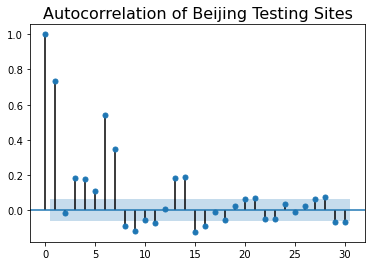

In [23]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_pacf(_df['Brooklyn Battery'], alpha=.05)
plt.title('Autocorrelation of Beijing Testing Sites', fontsize = 16);

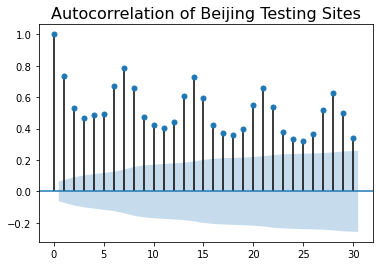

In [24]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(_df['Brooklyn Battery'], alpha=.05)
plt.title('Autocorrelation of Beijing Testing Sites', fontsize = 16);

In [62]:
_df

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
datetime,,,,,,,,,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,140775,81923,109286,1,0,2018,1,1,1,-1,0,1
2018-01-02,47160,21875,60610,19887,67000,106264,164930,95649,117211,1,1,2018,1,2,1,-1,0,0
2018-01-03,54005,24607,67983,22067,71725,115952,175150,103506,123974,1,2,2018,1,3,1,-1,0,0
2018-01-04,20484,8303,14502,6167,26625,28406,64137,37820,38114,1,3,2018,1,4,1,-1,0,0
2018-01-05,38007,16839,49850,13929,55153,80477,135253,74375,91229,1,4,2018,1,5,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-08,55105,24644,60591,25524,66662,106502,164588,100146,121270,9,1,2020,37,8,3,4,0,0
2020-09-09,56553,22692,62026,22821,67238,104707,163610,99250,118513,9,2,2020,37,9,3,4,0,0
2020-09-10,55672,20742,60627,20495,65909,100158,159519,97574,114546,9,3,2020,37,10,3,4,0,0


In [92]:
_arimax_707 = pd.DataFrame()
_arimax_707['bridges'] = bridges
_arimax_707['ARIMAX_707'] = l1
_arimax_707

,bridges,ARIMAX_707
0,Brooklyn Battery,5416.884196
1,Cross Bay,2984.171861
2,Henry Hudson,5625.149750
3,Marine Parkway,4568.374614
4,Queens Midtown,6490.411621
5,Throgs Neck,10062.600368
6,Triboro Bronx,10470.955367
7,Triboro Manhattan,3695.295120
8,Verrazano,8785.338638
9,Whitestone,10156.343771


In [22]:
_arimax_707 = pd.DataFrame()
_arimax_707['bridges'] = bridges
_arimax_707['ARIMAX_707'] = l1
_arimax_707

,bridges,ARIMAX_707
0,Brooklyn Battery,5416.884196
1,Cross Bay,2984.171861
2,Henry Hudson,5625.149750
3,Marine Parkway,4568.374614
4,Queens Midtown,6490.411621
5,Throgs Neck,10062.600368
6,Triboro Bronx,10470.955367
7,Triboro Manhattan,3695.295120
8,Verrazano,8785.338638
9,Whitestone,10156.343771


In [18]:
_arimax_707 = pd.DataFrame()
_arimax_707['bridges'] = bridges
_arimax_707['ARIMAX_707'] = l1
_arimax_707

,bridges,ARIMAX_707
0,Brooklyn Battery,5380.612500
1,Cross Bay,3070.145893
2,Henry Hudson,5721.382300
3,Marine Parkway,4733.339197
4,Queens Midtown,6473.295685
5,Throgs Neck,9899.432032
6,Triboro Bronx,10185.690166
7,Triboro Manhattan,3555.979075
8,Verrazano,8681.789023
9,Whitestone,10024.649482


In [67]:
_arimax_707['SARIMAX_707'] = l1
_arimax_707

,bridges,ARIMAX_707,SARIMAX_707
0,Brooklyn Battery,5074.906009,5033.227333
1,Cross Bay,2896.753200,2875.775714
2,Henry Hudson,4392.307992,4518.836266
3,Marine Parkway,4723.397467,4757.148215
4,Queens Midtown,5106.611011,5139.652622
5,Throgs Neck,8280.711846,8294.155380
6,Triboro Bronx,6512.923057,6518.488501
7,Triboro Manhattan,2518.803089,2507.930127
8,Verrazano,5071.075134,5166.545028
9,Whitestone,7367.182183,7526.185880


In [71]:
lockdown = pd.DataFrame({
  'holiday': 'lockdown',
  'ds': pd.date_range(start='2020-03-21', end='2020-06-07'),
  'lower_window': 0,
  'upper_window': 1,
})
phase_1 = pd.DataFrame({
  'holiday': 'Phase_1',
  'ds': pd.date_range(start='2020-06-08', end='2020-06-21'),
  'lower_window': 0,
  'upper_window': 1,
})
phase_2 = pd.DataFrame({
  'holiday': 'Phase_2',
  'ds': pd.date_range(start='2020-06-22', end='2020-07-05'),
  'lower_window': 0,
  'upper_window': 1,
})
phase_3 = pd.DataFrame({
  'holiday': 'Phase_3',
  'ds': pd.date_range(start='2020-07-06', end='2020-07-18'),
  'lower_window': 0,
  'upper_window': 1,
})
phase_4 = pd.DataFrame({
  'holiday': 'Phase_4',
  'ds': pd.date_range(start='2020-07-19', end='2020-12-31'),
  'lower_window': 0,
  'upper_window': 1,
})


holidays = pd.concat((lockdown, phase_1, phase_2, phase_3, phase_4))
holidays

,holiday,ds,lower_window,upper_window
0,lockdown,2020-03-21,0,1
1,lockdown,2020-03-22,0,1
2,lockdown,2020-03-23,0,1
3,lockdown,2020-03-24,0,1
4,lockdown,2020-03-25,0,1
...,...,...,...,...
161,Phase_4,2020-12-27,0,1
162,Phase_4,2020-12-28,0,1
163,Phase_4,2020-12-29,0,1
164,Phase_4,2020-12-30,0,1


In [72]:
tr_start,tr_end = '2018-01-01','2020-08-20'
te_start,te_end = '2020-08-21','2020-09-12'
tra = _df_merged[tr_start:tr_end]['Brooklyn Battery'].dropna()
tes = _df_merged[te_start:te_end]['Brooklyn Battery'].dropna()
exog_train = _df_ohe_df[tr_start:tr_end]
exog_test = _df_ohe_df[te_start:te_end]

In [73]:
m = Prophet(holidays=holidays,
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
tra = tra.reset_index()
tra.columns = ['ds', 'y']
m.fit(tra)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [85]:
future = m.make_future_dataframe(periods=23)
future

,ds
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
981,2020-09-08
982,2020-09-09
983,2020-09-10
984,2020-09-11


In [92]:
future = pd.DataFrame(data= pd.date_range(start= '2020-08-21', end = '2020-09-12'), columns =['ds'])

In [93]:
future

,ds
0,2020-08-21
1,2020-08-22
2,2020-08-23
3,2020-08-24
4,2020-08-25
5,2020-08-26
6,2020-08-27
7,2020-08-28
8,2020-08-29
9,2020-08-30


In [91]:
tes

datetime
2020-08-21    53822
2020-08-22    36817
2020-08-23    33512
2020-08-24    52900
2020-08-25    53262
2020-08-26    56023
2020-08-27    56449
2020-08-28    55428
2020-08-29    27376
2020-08-30    40607
2020-08-31    53652
2020-09-01    54205
2020-09-02    53388
2020-09-03    58136
2020-09-04    56280
2020-09-05    36971
2020-09-06    36329
2020-09-07    31281
2020-09-08    55105
2020-09-09    56553
2020-09-10    55672
2020-09-11    56878
2020-09-12    39373
Freq: D, Name: Brooklyn Battery, dtype: int64

In [100]:
m.predict(future)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Phase_1,Phase_1_lower,Phase_1_upper,Phase_2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-08-21,38101.702726,36588.195425,63415.040858,38097.297079,38102.723597,0.0,0.0,0.0,0.0,...,4297.082097,4297.082097,4297.082097,3288.107247,3288.107247,3288.107247,0.0,0.0,0.0,49699.063622
1,2020-08-22,38098.110942,23942.147153,50726.111461,38076.400539,38113.597400,0.0,0.0,0.0,0.0,...,-7594.245154,-7594.245154,-7594.245154,3542.264438,3542.264438,3542.264438,0.0,0.0,0.0,38058.301778
2,2020-08-23,38094.519157,22423.654703,49805.328612,38046.494078,38133.546372,0.0,0.0,0.0,0.0,...,-9662.091834,-9662.091834,-9662.091834,3797.463084,3797.463084,3797.463084,0.0,0.0,0.0,36242.061959
3,2020-08-24,38090.927373,33230.443215,59051.133271,38009.790520,38149.565097,0.0,0.0,0.0,0.0,...,-10.125006,-10.125006,-10.125006,4051.226574,4051.226574,4051.226574,0.0,0.0,0.0,46144.200492
4,2020-08-25,38087.335589,36218.179368,63290.538164,37966.978757,38173.573682,0.0,0.0,0.0,0.0,...,3218.650000,3218.650000,3218.650000,4301.374578,4301.374578,4301.374578,0.0,0.0,0.0,49619.531719
5,2020-08-26,38083.743804,36518.520692,63764.166476,37927.841126,38208.624835,0.0,0.0,0.0,0.0,...,3736.650527,3736.650527,3736.650527,4546.085280,4546.085280,4546.085280,0.0,0.0,0.0,50378.651163
6,2020-08-27,38080.152020,39272.093672,65650.213572,37878.660046,38240.368406,0.0,0.0,0.0,0.0,...,6014.079370,6014.079370,6014.079370,4783.941302,4783.941302,4783.941302,0.0,0.0,0.0,52890.344244
7,2020-08-28,38076.560236,38056.622511,65449.299377,37821.816494,38275.708396,0.0,0.0,0.0,0.0,...,4297.082097,4297.082097,4297.082097,5013.958062,5013.958062,5013.958062,0.0,0.0,0.0,51399.771946
8,2020-08-29,38072.968451,26280.603787,54010.769495,37767.582236,38320.635050,0.0,0.0,0.0,0.0,...,-7594.245154,-7594.245154,-7594.245154,5235.593900,5235.593900,5235.593900,0.0,0.0,0.0,39726.488750
9,2020-08-30,38069.376667,23388.950254,51147.913130,37703.260848,38368.185099,0.0,0.0,0.0,0.0,...,-9662.091834,-9662.091834,-9662.091834,5448.742019,5448.742019,5448.742019,0.0,0.0,0.0,37868.198404


In [ ]:
pred = m.predict()

In [108]:
def return_prophet_rmse(bridge):
    """
    returns arima rmse
    """
    tr_start,tr_end = '2018-01-01','2020-08-20'
    te_start,te_end = '2020-08-21','2020-09-12'
    tra = _df_merged[tr_start:tr_end][bridge].dropna()
    tes = _df_merged[te_start:te_end][bridge].dropna()
    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    tra = tra.reset_index()
    tra.columns = ['ds','y']
    tes = tes.reset_index()
    tes.columns = ['ds','y']
    
    
    m = Prophet(holidays=holidays,
           changepoint_prior_scale= 0.5,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
    
    m.fit(tra)
    
    future = pd.DataFrame(data= pd.date_range(start= '2020-08-21', end = '2020-09-12'), columns =['ds'])
    
    
    pred = m.predict(future)
    return np.sqrt(mean_squared_error(tes['y'],pred['yhat']))

In [103]:
bridges

['Brooklyn Battery',
 'Cross Bay',
 'Henry Hudson',
 'Marine Parkway',
 'Queens Midtown',
 'Throgs Neck',
 'Triboro Bronx',
 'Triboro Manhattan',
 'Verrazano',
 'Whitestone']

In [109]:
fb_prophet_1 = []
for i in tqdm(bridges):
    fb_prophet.append(return_prophet_rmse(i))

100%|██████████| 10/10 [05:06<00:00, 30.65s/it]


In [115]:
_arimax_707['fb_prophet_1'] = fb_prophet[-10:]
_arimax_707

,bridges,ARIMAX_707,SARIMAX_707,fb_prophet,fb_prophet_1
0,Brooklyn Battery,5074.906009,5033.227333,5725.572935,7873.282697
1,Cross Bay,2896.753200,2875.775714,4168.910659,3296.678936
2,Henry Hudson,4392.307992,4518.836266,5250.787214,6099.712080
3,Marine Parkway,4723.397467,4757.148215,6379.201240,4610.790834
4,Queens Midtown,5106.611011,5139.652622,8116.112951,6100.500781
5,Throgs Neck,8280.711846,8294.155380,6985.117748,7216.992386
6,Triboro Bronx,6512.923057,6518.488501,6389.050726,6503.175218
7,Triboro Manhattan,2518.803089,2507.930127,3296.679739,4020.971637
8,Verrazano,5071.075134,5166.545028,4754.962910,5035.669121
9,Whitestone,7367.182183,7526.185880,7262.443322,8944.088627


In [123]:
_arimax_707.columns = ['bridges', 'ARIMAX_707', 'SARIMAX_707_10012', 'fb_prophet_001', 'fb_prophet_005']
_arimax_707.to_csv('results.csv', index=False, header=True)

In [117]:
_df_merged

,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone,...,dayofweek_5,dayofweek_6,quarter_2,quarter_3,quarter_4,Phase_0,Phase_1,Phase_2,Phase_3,Phase_4
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [120]:
for i in _df_merged.columns:
    _df_merged[i] = _df_merged[i].astype('float')

In [121]:
# model_VARMAX = sm.tsa.VARMAX(_df_merged[tr_start:tr_end][bridges],
#                              order=(7,7), trend = 'n',exog = exog_train, enforce_stationarity=False, enforce_invertibility=False)
# results = model_VARMAX.fit(maxiter=1000, disp=True)
# results.summary()

C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



KeyboardInterrupt: 